# Task report : Deeptweets

Team name: PGX- DS-T76

Username: orcldsapp176 

Name: Barday Soulaimane

Email: soulaimanbarday@gmail.com

# Introduction

The DeepTweets competition set out the task of categorizing tweets into Politics or Sports. This report outlines the journey through data extraction, preprocessing, and feature engineering. The primary focus was on comparing the effectiveness of two machine learning approaches, fine-tuning their hyperparameters, and selecting the most suitable model for the final testing phase.



# Imports

### In this project we'll need libraries for:


Data manipulation and analysis: pandas


Numerical operations and array manipulation: numpy


Text data pre-processing (regular expressions): re


Text data processing (Natural Language Processing): spacy


Feature extraction from text: TfidfVectorizer

Machine learning models: MultinomialNB, LogisticRegression, GaussianNB


Model evaluation: accuracy_score, classification_report, confusion_matrix


Data splitting & hyperparameter tuning: train_test_split, GridSearchCV

Data pre-processing (scaling): StandardScaler

Model evaluation (ROC curves): roc_curve, auc


Categorical label encoding: LabelEncoder

In [1]:
import pandas as pd         
import numpy as np         
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder



# Data extraction

Let's start by extracting the data from the given files

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

Let's take a look at the form and the shape of the data

In [3]:
train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,'#SecKerry: The value of the @StateDept and @U...
1,304834304222064640,Politics,'@rraina1481 I fear so'
2,303568995880144898,Sports,'Watch video highlights of the #wwc13 final be...
3,304366580664528896,Sports,'RT @chelscanlan: At Nitro Circus at #AlbertPa...
4,296770931098009601,Sports,'@cricketfox Always a good thing. Thanks for t...


In [4]:
train.shape

(6525, 3)

In [5]:
test.head()

,TweetId,TweetText
0,306486520121012224,'28. The home side threaten again through Maso...
1,286353402605228032,'@mrbrown @aulia Thx for asking. See http://t....
2,289531046037438464,'@Sochi2014 construction along the shores of t...
3,306451661403062273,'#SecKerry\u2019s remarks after meeting with F...
4,297941800658812928,'The #IPLauction has begun. Ricky Ponting is t...


In [6]:
test.shape

(2610, 2)

Checking for any null values

In [7]:
train.isnull().sum()

TweetId      0
Label        0
TweetText    0
dtype: int64

In [8]:
test.isnull().sum()

TweetId      0
TweetText    0
dtype: int64

Getting an overview of the distribution of the data

In [9]:
train['Label'].value_counts()

Label
Sports      3325
Politics    3200
Name: count, dtype: int64

# Cleaning data

Removing hashtags, mentions, URLs, the string "rt" from the beginning of retweets, any characters that are not alphanumeric or whitespace and any empty tweets after cleaning  

In [19]:
def cleaning(table,col):
    table[col] = table[col].str.lower()
    table[col] = table[col].apply(lambda elem: re.sub(r"(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|^rt|[^A-Za-z0-9\s]", "", elem))
    table = table[table[col].str.strip() != ""]     
    return table

In [20]:
def cleaning_test(table, col):

    table[col] = table[col].str.lower()
    def clean_text(text):
        cleaned_text = re.sub(r"(#[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|^rt|[^A-Za-z0-9\s]", "", text)
        if not cleaned_text:
            cleaned_text = " "
        return cleaned_text

    table[col] = table[col].apply(clean_text)
    return table

Removing the TweetId column from the training data because it has no use for us in the training phase

In [21]:
train.drop(['TweetId'],axis=1)

,Label,TweetText
0,Politics,the value of the and is measured not in dol...
1,Politics,i fear so
2,Sports,watch video highlights of the final between a...
3,Sports,rt at nitro circus at
4,Sports,always a good thing thanks for the feedback
...,...,...
6520,Politics,photo pm has laid a wreath at martyrs monument...
6521,Sports,the secret of the chennai pitch crumbling on ...
6522,Sports,he isnt on twitter either
6523,Sports,which england player would you take out to din...


Applying the cleaning logic on our training and test data

In [22]:
train = cleaning(train,'TweetText')

Overview of the cleaned data

In [31]:
train.head()

,TweetId,Label,TweetText
0,304271250237304833,Politics,the value of the and is measured not in dol...
1,304834304222064640,Politics,i fear so
2,303568995880144898,Sports,watch video highlights of the final between a...
3,304366580664528896,Sports,at nitro circus at
4,296770931098009601,Sports,always a good thing thanks for the feedback


In [33]:
test = cleaning_test(test, 'TweetText')
test.head()

,TweetId,TweetText
0,306486520121012224,28 the home side threaten again through mason ...
1,286353402605228032,thx for asking see it derives from a series...
2,289531046037438464,construction along the shores of the black sea
3,306451661403062273,u2019s remarks after meeting with foreign mini...
4,297941800658812928,the has begun ricky ponting is the first play...


# Processing data

## Lemmatization

Pocessesing text by converting words to their base forms (lemmatization) using spaCy's pre-trained english language model.

In [34]:
def preprocess_text(text):
    text = text.lower()
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    print(lemmatized_tokens)
    return ' '.join(lemmatized_tokens)


Applying the processing logic on our data

In [35]:
X = train['TweetText'].apply(preprocess_text)
Y = train['Label']

[' ', 'the', 'value', 'of', 'the', ' ', 'and', ' ', 'be', 'measure', 'not', 'in', 'dollar', 'but', 'in', 'term', 'of', 'our', 'deep', 'american', 'value']
[' ', 'I', 'fear', 'so']
['watch', 'video', 'highlight', 'of', 'the', ' ', 'final', 'between', 'australia', 'and', 'west', 'indie', 'at']
['  ', 'at', 'nitro', 'circus', 'at', '     ']
[' ', 'always', 'a', 'good', 'thing', 'thank', 'for', 'the', 'feedback']
['dr', 'rajan', 'fiscal', 'consolidation', 'will', 'create', 'more', 'space', 'for', 'monetary', 'policy', 'to', 'act']
['fact', 'more', 'than', '800000', 'defense', 'employee', 'will', 'be', 'force', 'to', 'take', 'unpaid', 'leave', 'if', 'congress', 'do', 'not', 'stop', 'impend', 'spending', 'cut']
['1st', 'test', 'over', '39', '0', 'run', '1', 'wkt', 'm', 'wade', '0', 'm', 'clarke', '24', ' ', '1014', '  ']
['some', 'of', 'africas', 'top', 'team', 'will', 'try', 'and', 'take', 'a', 'step', 'close', 'to', 'the', ' ', 'this', 'week', 'check', 'out', 'qualifying', 'fixture']
['can

['possible', 'fa', 'cup', 'quarterfinal', 'date', 'set', ' ']
[' ', 'langer', 'rapt', 'with', 'warrior', 'fightback', 'at', 'the', 'waca', 'read', 'why']
['you', 'can', 'follow', 'live', 'update', 'photo', 'and', 'blog', 'straight', 'from', 'the', 'bcim', 'car', 'rally', 'on', 'our', 'tumblr', 'blog']
['wake', 'forest', 'just', 'drop', ' ', 'miami', 'this', 'year', 'ncaa', 'tournament', 'bracket', 'be', 'go', 'to', 'be', 'the', 'hard', 'multiple', 'choice', 'test', 'ever']
['photoset', 'social', 'state', 'of', 'the', 'union', 'stat', 'accord', 'to', 'google', 'the', 'top', 'four', 'rise', 'search', 'term', 'during', 'this']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'suga', 'january', '24', '2013am']
['also', 'on', 'this', 'week', 'be', 'two', 'champ', 'manager', ' ', 'u2019s', 'darren', 'ferguson', 'amp', 'officialu2019s', 'david', 'flitcroft']
['I', 'know', 'it', 'because', 'I', 'have', 'see', 'it', 'good', 'democrats', 'can', 'come', 'to

['the', ' ', 'new', 'uniform', 'tonight', 'be', 'fresh', 'gt']
['like', 'our', ' ', '360xb0', 'panorama', ' ', 'click', 'check', 'making', 'of', 'video', ' ', 'click']
['happen', 'now', 'president', 'obama', 'join', 'a', ' ', 'live', 'from', 'the', 'white', 'house']
['president', 'hollande', 'speak', 'at', 'indiafrance', 'trade', 'conference', 'photo', 'gallry', ' ', 'business', 'standard']
['mitt', 'romney', 'deliver', 'concession', 'speech', 'to', 'supporter', 'in', 'boston', 'po234tu']
['indian', 'author', 'shortlist', 'for', 'man', 'booker', 'prize', ' ', 'hindustan', 'time']
['miss', 'saturday', ' ', 'do', 'not', 'worry', 'we', 'get', 'you', 'cover', ' ']
['u201clet', 'we', 'give', 'practical', 'recognition', 'to', 'the', 'injustice', 'of', 'the', 'past', 'by', 'build', 'a', 'future', 'base', 'on', 'equality', 'amp', 'u201d', ' ']
['the', 'president', 'we', 'need', 'to', 'modernise', 'our', 'political', 'system', 'the', 'government', 'will', 'seek', 'to', 'ensure', 'political', 'p

['to', 'stop', 'chinese', 'hacker', 'focus', 'on', 'defense', 'not', 'diplomacy', ' ', 'on', 'stay', 'safe', 'in', 'cyberspace']
[' ', 'the', 'mcc', 'make', 'this', 'decision']
['I', 'know', 'that', 'my', 'student', 'and', 'I', 'will', 'carry', 'these', 'scar', 'for', 'the', 'rest', 'of', 'our', 'life', 'u2014rachel', 's', ' ']
[' ', 'thank', 'you', 'for', 'understand']
['tomorrow', 'and', 'thursday', 'the', 'champions', 'league', 'and', 'fa', 'cup', 'trophy', 'will', 'be', 'in', 'our', 'kingston', 'store', ' ']
['1999', 'again', 'need', 'one', 'to', 'win', 'of', 'three', 'ball', 'donald', 'and', 'klusener', 'other', 'how', 'to', 'run', 'and', 'sa', 'be', 'bundle', 'out', 'in', 'the', 'semis']
['40', 'off', 'all', 'nutrition', 'at', 'the', 'official', 'maximuscle', 'shop', 'for', '2', 'day', 'plus', 'free', 'delivery', '2526', 'february', 'only']
['remember', 'those', 'who', 'die', 'in', 'amp', 'after', 'the', 'munich', 'air', 'disaster', '55', 'year', 'ago', 'today', 'crew', 'club', '

[' ', 'yes', 'that', 'it', 'do', 'but', 'be', 'not', 'brilliant']
['west', 'wing', 'week', '120712', 'or', 'I', 'have', 'to', 'pinch', 'myself', ' ', 'welcome', 'to', 'the', 'west', 'wing', 'week', 'yourguide', 'to', 'everything', 'that']
['it', 'turn', 'out', 'irregular', 'war', 'be', 'actually', 'quite', 'regular', ' ', 'on', 'the', 'history', 'of', 'insurgency']
['out', 'lyon', 'you', 'ripper', 'bowl', 'tendulkar', 'through', 'the', 'gate', 'big', 'spin', 'take', 'the', 'edge', 'onto', 'stump', 'great', 'pressure', 'out', 'for', '81', '4196']
[' ', 'time', 'well', 'spend', 'd']
[' ', 'be', 'a', 'very', 'important', 'weapon', 'to', 'prepare', 'child', 'for', 'their', 'future', 'role', 'as', 'leader', 'of', 'the', 'community']
['mother', 'language', 'day', 'do', 'you', 'know', 'this', 'song', 'sing', 'along', 'in', 'your', 'language', 'just', 'click']
['  ', 'excellent', 'interview', 'with', ' ', 'on', 'protection', 'of', 'civilian', 'in', 'conflict', 'with', 'gideon', 'rise', 'at', '

['these', 'cut', 'be', 'wrong', 'theyu2019re', 'not', 'smart', 'theyu2019re', 'not', 'fair', 'theyu2019re', 'a', 'selfinflicted', 'wound', 'that', 'do', 'not', 'have', 'to', 'happen']
['bhoomi', 'poojan', 'for', 'installation', 'of', 'cctv', 'at', 'metal', 'amp', 'stainless', 'steel', 'bazaar', 'cp', 'tank', 'mumbai', 'spend', 'rs', '10l', 'from', 'mplad']
['u201ci', 'feel', 'much', 'more', 'comfortable', 'with', 'my', 'ranking', 'and', 'myselfu201d', 'andreas', ' ', 'reveal', 'to', ' ', 'read', 'why', '  ']
['   ', 'u200e', 'need', 'abve', 'blood', 'for', ' ', 'farida', ' ', 'narayana', 'hrudayalaya', 'suraram', 'jeedimetla', 'call', ' ', '96765']
[' ', 'look', 'good', 'not', 'long', 'now']
['we', 'do', 'not', 'need', 'any', 'more', 'slogan', 'what', 'we', 'need', 'be', 'leadership']
['donald', 'what', 'type', 'of', 'tix', 'be', 'you', 'try', 'to', 'buy', 'amp', 'what', 's', 'happen', 'when', 'you', 'try', 'please', 'maybe', 'try', 'foxtix', 'website']
['prof', 'thomas', 'on', 'the', 

['  ', 'fulltime', 'steaua', '20', 'ajax', 'agg', '22', 'aet', 'steaua', 'win', 'on', 'penalty', '42', '  ']
['from', 'a', 'media', 'perspective', 'big', 'story', 'be', 'whether', 'gambhir', 'and', 'sehwag', 'or', 'either', 'will', 'retain', 'their', 'place']
[' ', 'ha', 'ha', 'hilarious']
['15', 'december', '1989', ' ', 'be', 'visit', 'at', 'pollsmoor', 'prison', 'for', '3', 'hour', 'by', 'dullah', 'and', 'farida', 'omar']
['the', 'employment', 'situation', 'in', 'november', ' ', 'while', 'more', 'work', 'remain', 'to', 'be', 'do', 'today', 'employment', 'report', 'provide', 'fu']
['medhekar', 'well', 'say']
['our', 'three', 'brazilian', 'boy', 'have', 'be', 'at', 'the', 'bridge', 'today', ' ']
['19', 'december', '1956', ' ', 'and', 'the', '155', 'other', 'accuse', 'appear', 'in', 'court', 'for', 'the', 'first', 'time', 'for', 'the', 'treason', 'trial']
[' ', 'we', 'make', 'a', 'fundamental', 'decision', 'to', 'allocate', 'some', 'of', 'our', 'reserve', 'for', 'fund', 'infrastructure'

['pmu2019s', 'instruction', 'on', 'north', 'koreau2019s', 'announcement', 'of', 'plan', 'missile', 'launch', 'which', 'it', 'call', 'a', 'u201csatelliteu201d', 'dec', '1']
['  ', 'great', 'tournament', 'really', 'enjoy', 'every', 'moment', 'thx', 'for', 'everything', ' ', 'look', 'fw', 'to', 'next', 'year']
['for', 'the', 'fashionista', 'who', 's', 'the', 'first', 'lady', 'and', 'the', 'first', 'daughter', 'wear', 'for', 'inauguration', 'dayu2026']
['only', 'six', 'off', 'the', '15th', '3119', '170', 'look', 'to', 'be', 'minimum', 'here', 'hogg', 'to', 'bowl', ' ']
['the', 'second', 'inauguration', 'of', 'barack', 'obama', ' ', 'supreme', 'court', 'chief', 'justice', 'john', 'roberts', 'administer', 'the', 'oath', 'of', 'offic']
[' ', 'as', 'plumb', 'as', 'you', 'd', 'like', 'but', 'technology', 'have', 'a', 'way', 'of', 'add', 'even', 'more', 'doubt', ' ']
[' ', 'score', 'west', 'indie', 'vs', 'zimbabwe', '782']
['rove', 'ground', 'camera', 'of', 'celebration', 'at', 'the', 'white', '

['the', 'president', 'plan', 'begin', 'with', 'make', 'america', 'a', 'magnet', 'for', 'job', 'and', 'hightech', 'manufacture', ' ']
['vladimir', 'putin', 'will', 'attend', 'a', 'meeting', 'of', 'the', 'council', 'of', 'cis', 'head', 'of', 'state', 'on', 'december', '5', ' ']
['ian', 'botham', 'take', '528', 'wicket', 'in', '218', 'match', 'at', '2844', 'for', 'england', 'james', 'anderson', 'reach', '529', 'wicket', 'in', '261', 'match', 'at', '3047']
[' ', 'in', '1st', '2', 'set', 'I', 'serve', 'well', 'against', 'he', 'than', 'in', 'any', 'tournament', 'in', 'past', 'two', 'year', '  ']
['relive', 'in', 'sudarshinis', 'asean', 'expedition', 'so', 'far', ' ', 'sudarshini', 'will', 'arrive', 'in', ' ', 'on', '29th', 'march', 'after', '127', 'day', 'at', 'sea']
['if', 'you', 'use', 'a', 'tv', 'phone', 'laptop', 'and', 'tablet', 'simultaneously', 'to', 'keep', 'up', 'with', 'sport', 'you', 'have', 'a', 'problemof', 'being', 'way', 'too', 'awesome']
['video', 'british', 'tennis', 'player

['watch', 'first', 'lady', 'michelle', 'obama', 'read', 'twa', 'the', 'night', 'before', 'christmas']
['how', 'can', 'civil', 'society', 'help', 'food', 'security', ' ']
[' ', 'a', 'loaded', 'gun', 'do', 'we', 'have', 'a', 'responsiblity', 'to', 'protect', 'follow', 'foreign', 'affair', 'debate', 'w', 'eea', 'at', '3', 'pm', 'cet']
['be', 'the', ' ', 'the', 'car', 'to', 'return', ' ', 'to', 'the', 'top', 'of', ' ']
[' ', 'cup', 'can', 'you', 'guess', 'where', 'we', 've', 'be', 'today', 'not', 'long', 'to', 'go', 'now', ' ']
[' ', 'minister', 'we', 'be', 'provide', 'nutritious', 'food', 'to', 'the', 'poor', 'community', 'at', 'affordable', 'price', 'through', 'the', 'new', ' ', 'security', 'bill']
['vladimir', 'putin', 'have', 'congratulate', 'shinzo', 'abe', 'on', 'his', 'election', 'as', 'prime', 'minister', 'of', 'japan']
['dr', 'rajan', 'macro', 'economic', 'stabilisation', 'will', 'spur', 'confidence', 'building', 'once', 'confidence', 'build', 'up', 'there', 'will', 'be', 'more', 

['1st', 'test', 'over', '49', '4', 'run', 'm', 'clarke', '31', 'm', 'henrique', '5', ' ', '1285', '  ']
['the', 'us', 'be', 'bless', 'with', 'courageous', 'friend', 'happy', 'birthday', 'to', 'the', 'iron', 'lady', 'margaret', 'thatcher', ' ', 'a', 'tower', 'of', 'strength', 'in', 'the', 'cause', 'of', 'liberty']
[' ', 'yes', 'indeed', 'more', 'the', 'pity']
['  ', 'see', 'you', 'soon']
['economical', 'over', 'from', 'lynn', 'just', '6', 'off', 'it', '4114', '54', 'off', '24', 'need', ' ']
['wicket', 'lyon', 'have', 'ashwin', 'play', 'on', 'unlucky', 'for', 'ravi', 'hit', 'the', 'ball', 'onto', 'his', 'foot', 'then', 'back', 'on', 'the', 'stump', 'out', 'for', '3', 'ind', '7372']
['the', ' ', 'star', 'of', 'buzkashi', 'boy', 'be', 'on', 'their', 'way', 'to', 'the', '  ', 'wish', 'they', 'luck']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'suga', 'february', '26', '2013am']
['there', 's', '10', 'over', 'to', 'go', 'and', 'eng', 'lion', 'need'

['I', 'be', 'a', 'hunter', 'of', 'small', 'game', 'and', 'own', 'a', 'shotgun', 'to', 'do', 'so', 'but', 'it', 'be', 'time', 'to', 'find', 'a', 'way', 'to', 'stop', 'gun', 'violence', 'u2014gary', 'f']
['pakistan', 'lose', '6', 'for', '22', 'to', 'crumble', 'to', '169', 'all', 'out', 'be', 'that', 'the', 'game', 'or', 'can', 'ajmal', 'work', 'his', 'magic', 'again', ' ']
['why', 'be', '   ', 'drl']
['new', 'zealand', 'bowler', 'chris', 'martin', 'be', 'seven', 'duck', 'short', 'of', 'courtney', 'walshu2019s', 'test', 'record', 'of', '43']
['  ', 'watch', 'now', 'prime', 'minister', 'dr', 'manmohan', 'singh', 'and', 'french', 'president', 'francois', 'hollande', ' ', 'to', 'make', 'statement', 'to', 'the', 'm']
['a', 'rice', 'farmer', 'in', 'vietnam', 'can', 'lose', '1037', 'of', 'harvest', 'before', 'it', 'reach', 'the', 'market', 'how', 'to', 'prevent', 'loss', ' ']
[' ', 'want', 'to', 'keep', 'it', 'sweet', '  ']
[' ', 'we', 'like', 'what', 'you', 'do', 'there', 'jay']
['  ', 'send',

['pm', 'I', 'want', 'europe', 'to', 'be', 'a', 'success', 'and', 'I', 'want', 'a', 'relationship', 'between', 'britain', 'amp', ' ', 'that', 'keep', 'we', 'in', 'it']
['1st', 'test', 'over', '42', '4', 'run', 'm', 'wade', '2', 'm', 'clarke', '27', ' ', '1104', '  ']
['no', 'people', 'in', 'one', 'part', 'of', 'the', 'world', 'could', 'really', 'be', 'free', 'while', 'their', 'brother', 'in', 'other', 'part', 'be', 'still', 'under', 'foreign', 'rule']
['pms', 'comment', 'after', '4', 'minister', 'meeting', 'on', 'dec', '1', 'on', 'north', 'koreas', 'plan', 'missilesatellitelaunch']
['michael', 'kiddgilchrist', 'defy', 'the', 'law', 'of', 'gravity', 'gt']
['president', 'obama', 'urge', 'congress', 'to', 'prevent', 'tax', 'hike', 'on', 'middle', 'class', 'americans']
['petr', 'cech', 'speak', 'with', 'czech', 'journalist', 'after', 'the', 'game', 'tonight', ' ']
['  ', 'digger', 'read', 'todays', ' ', 'article', 'to', 'his', 'mate', 'at', 'traeger', 'park', ' ']
[' ', 'book', 'britain', '

['inexperienced', 'attack', 'what', 'ehsan', 'adil', 'remove', 'graeme', 'smith', 'in', 'his', 'first', 'over', 'at', 'the', 'test', 'level', ' ']
['hogg', 'all', 'over', 'pomersbach', 'four', 'dot', 'ball', 'in', 'a', 'row', 'now']
['in', '1', 'hour', 'learn', 'about', 'empower', ' ', 'youth', 'amp', 'combat', 'homophobia', 'through', 'sport', 'with', ' ', 'at', ' ', 'drl']
['  ', 'check', 'out', 'my', 'late', 'piece', 'on', 'moqtada', 'alsadr', 'back', 'in', 'black', ' ', 'via']
[' ', 'just', 'the', 'premium', 'zone', 'you', 'have', 'purchase', 'ticket', 'for', 'note', 'turn', '15', 'sunday', 'ticket', 'be', 'already', 'sell', 'out']
['protectionism', 'be', 'counter', 'productive', 'it', 'delay', 'recovery', 'and', 'deepen', 'recession', 'anand', 'sharma', 'at', 'nasscom']
[' ', 'foreign', 'assistance', 'isnu2019', 't', 'a', 'charity', 'it', 'be', 'an', 'investment', 'in', 'a', 'free', 'world', 'drl']
[' ', 'he', 'd', 'be', 'the', 'only', 'batsman', 'to', 'score', 'a', 'fifty', 'make

['cahill', 'jt', 'be', 'a', 'massive', 'character', 'and', 'massive', 'leader', 'for', 'we', 'and', 'its', 'good', 'to', 'have', 'he', 'back']
['do', 'watch', 'the', ' ', 'change', 'your', 'view', 'on', 'women', 'cricket', 'tell', 'we', 'what', 'be', 'your', 'favourite', 'thing', 'about', 'the', 'women', 'game']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'sugajanuary', '9', '2013am']
['watch', 'obama', ' ', 'address', 'with', 'enhance', 'graphic', 'chart', 'and', 'useful', 'stat', 'on', 'his', 'plan', 'to', 'keep', 'we', 'move', 'forward']
['putin', 'we', 'must', 'agree', 'on', 'disclosure', 'term', 'with', 'offshore', 'zone', 'and', 'improve', 'our', 'investment', 'climate', 'to', 'relieve', 'economy', 'from', 'offshore', 'activity']
['ministry', 'of', 'commerce', 'and', 'industry', 'have', 'announce', 'the', 'setting', 'up', 'of', 'ebiz', 'indias', 'first', 'government', 'to', 'business', 'portal']
['  ', 'where', 'do', 'you', 'think', 'j

['  ', 'proudest', 'moment', 'of', 'my', 'life', 'achieve', 'my', 'childhood', 'dream', 'thank', 'go', 'to', 'codemaster', 'and', 'microsoft', 'make', 'it', 'happen', 'http']
['clinical', 'south', 'africa', 'march', 'on']
['telephone', 'conversation', 'with', 'prime', 'minister', 'of', 'iraq', 'nouri', 'almaliki']
[' ', 'indeed', 'mine', 'too']
['   ', 'mean', 'take', 'risk', 'and', 'proactively', 'determine', 'what', 'the', 'future', 'will', 'be', 'like', ' ', 'ilf']
[' ', 'watson', 'hold', 'at', 'love', 'for', '53']
['25', 'year', 'ago', 'larry', 'legend', 'win', 'his', '3rd', 'and', 'final', 'threepoint', 'contest', 'gt']
['  ', 'great', ' ', 'essay', 'w', 'new', 'document', 'show', 'why', 'bretton', 'wood', 'architect', 'harry', 'dexter', 'white', 'spy', 'for', 'soviet']
[' ', 'bulgaria', 'hold', 'for', '31']
['ellyse', 'perry', 'strike', 'again', 'and', 'she', 'have', 'just', 'claim', 'the', 'vital', 'wicket', 'of', 'stafanie', 'taylor', 'for', '5']
['  ', 's', 'dist', 'fellow', '

[' ', 'great', 'to', 'hear', 'you', 'have', 'a', 'fan', 'site', 'for', 'cricket', ' ', 'feel', 'free', 'to', 'share', 'your', 'view', 'with', 'we']
['the', 'prime', 'minister', 'just', 'finish', 'his', 'statement', 'on', 'the', ' ', 'report', 'into', ' ', 'read', 'in', 'full', 'here', ' ']
['congrat', 'to', 'the', 'detroit', ' ', 'on', 'make', 'it', 'to', 'the', 'world', 'series', 'part', 'of', 'the', 'heart', 'and', 'soul', 'of', 'detroit']
['  ', 'be', 'now', 'live', 'from', 'the', 'king', 'power', 'stadium', 'as', ' ', 'host', ' ', 'in', 'the', ' ', 'full', 'commentary', 'now', 'at', 'http']
['everton', 'boss', 'david', 'moyes', 'oldham', 'be', 'on', 'a', 'really', 'good', 'run', 'so', 'we', 'have', 'to', 'play', 'well', 'and', 'give', 'they', 'all', 'the', 'respect', 'they', 'deserve', ' ', 'v']
['one', 'of', 'the', 'advantage', 'of', 'old', 'age', 'be', 'that', 'people', 'respect', 'you', 'just', 'because', 'of', 'your', 'grey', 'hairampsay', 'all', 'manner', 'of', 'nice', 'thing'

['to', ' ', 'fan', 'around', 'the', 'world', 'we', 'love', 'you', 'happy', 'valentine', 'day', 'd', 'x', ' ']
['if', 'you', 'miss', 'it', 'watch', 'the', 'president', ' ', 'address', 'with', 'enhance', 'graphic', 'amp', 'stat', 'on', 'his', 'plan', 'to', 'grow', 'our', 'economy']
['anderson', 'take', 'his', '529th', 'international', 'wicket', 'to', 'become', 'england', 'lead', 'overall', 'bowler', 'ahead', 'of', 'ian', 'botham', ' ']
['putin', 'we', 'must', 'expand', 'the', 'opportunity', 'for', 'russian', 'family', 'to', 'adopt', 'orphan']
['check', 'out', 'the', 'late', 'issue', 'of', 'india', 'perspective']
['putin', 'we', 'advocate', 'a', 'solution', 'to', 'the', 'syrian', 'crisis', 'that', 'would', 'prevent', 'the', 'country', 'dissolution', 'and', 'end', 'the', 'ongoing', 'civil', 'war']
['medvedev', 'the', 'government', 'take', 'a', 'principled', 'stand', 'on', 'its', 'commitment', 'to', 'provide', 'funding', 'for', 'education']
[' ', 'make', 'sharp', 'return', 'to', 'action', '

['1st', 'test', '652', 'r', 'ashwin', 'to', 'm', 'henrique', '4', 'run', '1748', '  ']
['  ', 'very', 'illuminate', 'commentator', 'workshop', 'from', 'star', 'india', 'insight', 'into', 'who', 'the', 'viewer', 'be', 'and', 'what', 'heshe', 'seek', 'from', 'co']
['govt', 'of', 'manipur', 'welcome', 'the', 'rally', 'participant', 'with', 'an', 'amazing', 'cultural', 'performance', ' ']
[' ', 'will', 'rock', ' ', 'fan', 'with', 'a', 'special', '1', 'hour', 'live', 'show', 'on', 'march', '16', 'from', '630pm', 'at', 'the', 'legend', 'lane', 'stage']
['9', 'golfer', '9', 'putter', '9', 'golf', 'ball', '9', 'make', 'you', 'have', 'to', 'see', 'this', 'to', 'believe', 'it', 'gt']
['australia', 'allrounder', 'lisa', 'sthalekar', 'have', 'today', 'announce', 'her', 'retirement', 'from', 'international', 'cricket']
['surgeon', 'general', 'say', 'its', 'hazardous', 'to', 'breathe', 'ill', 'have', 'another', 'cigarette', 'because', 'I', 'can', 'not', 'see', 'tell', 'I', 'who', 'you', 're', 'go', 

['here', 'it', 'be', 'first', 'shoot', 'of', 'the', 'bcim', 'car', 'rally', 'convoy', 'on', 'the', 'go', 'enroute', 'bangladesh', ' ']
['but', 'there', 'be', 'a', 'solution', 'ignore', 'those', 'politician', 'religious', 'leader', 'medium', 'amp', 'folk', 'on', 'twitter', 'who', 'have', 'nothing', 'well', 'to', 'talk', 'about']
['medvedev', 'I', 'support', 'open', 'access', 'to', 'dissertation', 'and', 'publish', 'examination', 'result', 'accord', 'to', 'the', 'principle', 'of', 'open', 'datum']
['do', 'china', 'have', 'a', 'meritocratic', 'selfreforming', 'system', ' ', 'or', 'be', 'oneparty', 'rule', 'on', 'the', 'way', 'out']
['so', 'true', ' ', 'sophia', 'haque', 'be', 'my', 'guest', 'on', 'the', 'bournvita', 'quiz', 'contest', 'in', 'the', 'mid', '1990', 'go', 'too', 'soon']
[' ', 'you', 'll', 'have', 'to', 'wait', 'and', 'see', 'the', 'final', '11', 'when', 'it', 'come', 'to', 'the', 'toss', 'ahead', 'of', 'the', 'first', 'match']
['the', ' ', 'family', 'rally', 'behind', 'andrew

['pre', 'obama', 'depart', 'the', 'white', 'house', 'before', 'his', 'motorcade', 'take', 'he', 'to', 'the', 'capitol', 'po38mo']
['joe', 'johnson', 'hit', 'not', 'one', 'but', 'two', 'buzzer', 'beater', 'tonight', 'one', 'to', 'force', 'ot', 'and', 'one', 'to', 'win', 'the', 'game', 'for', 'the', ' ']
['just', 'wake', 'up', 'and', 'miss', 'all', 'the', 'action', 'never', 'fear', '2013', ' ', 'men', 'final', 'highlight', 'be', 'here']
['hope', 'welcome', 'cut', 'return', '  ']
[' ', 'thank', 'rashid']
[' ', 'book', 'book', 'of', 'the', 'day', 'an', 'epic', 'history', 'of', 'georgia', 'and', 'its', 'invader', 'from', 'the', 'cimmerian', 'to', 'the', 'russians']
['178', 'the', 'new', 'target', 'after', 'the', 'match', 'have', 'be', 'shorten', 'again', 'to', '17', 'over', 'five', 'over', 'for', 'the', 'powerplay', 'rain', 'back', 'though', ' ']
['swati', 'its', 'not', 'such', 'a', 'serious', 'remark', 'my', 'dear']
['  ', 'in', 'case', 'you', 'miss', 'it', 'first', 'lady', 'michelle', 'ob

['  ', 'interesting', 'balanced', 'take', 'in', ' ', 'on', 'why', ' ', 'be', 'important', 'even', 'if', 'you', 'do', 'not', 'agree', 'with', 'he', 'ht']
['call', 'for', 'great', 'bric', 'cooperation', 'on', 'tax', 'admin']
[' ', 'trophy', 'a', 'late', 'comeback', 'by', 'coventry', 'be', 'not', 'quite', 'enough', 'and', 'so', ' ', 'be', 'go', 'to', 'wembley', '32', 'winner', 'on', 'agg']
[' ', 'we', 've', 'have', 'a', 'sweepstake', 'on', 'when', 'qld', 'will', 'reach', 'the', '120', 'set', 'by', 'the', 'blue', '17', 'over', 'methink', 'you']
['gibb', 'look', 'to', 'have', 'do', 'a', 'hamstring', 'trouble', 'for', ' ', 'or', 'as', 'they', 'say', 'beware', 'the', 'injure', 'batsman', '018', ' ']
[' ', 'exactly']
['hm', 'state', 'govt', 'have', 'announce', 'rs', '6', 'lakh', 'exgratia', 'for', 'the', 'deceased', 'and', 'rs', '50000rs', '1', 'lakh', 'to', 'the', 'injure', 'in', ' ', 'hyu2019bad', 'blast']
['pakistan', 'have', '2', 'century', 'and', 'a', '10wicket', 'haul', 'in', 'cape', 'to

['follow', 'the', 'team', 'tonight', 'newton', '    ', 'buck', ' ']
['obama', 'send', 'I', 'a', 'comprehensive', 'immigration', 'reform', 'bill', 'in', 'the', 'next', 'few', 'month', 'and', 'I', 'will', 'sign', 'it', 'right', 'away']
['  ', 'what', 'about', 'my', 'johnnie', 'walker', 'question', 'future', 'career', 'as', 'a', 'pub', 'trivia', 'host']
['mr', 'president', 'america', 'have', 'not', 'dictate', 'to', 'other', 'nation', 'america', 'have', 'free', 'other', 'nation', 'from', 'dictator']
['on', 'jan', '24', 'pm', ' ', 'attend', 'the', '1st', 'meeting', 'of', 'the', 'regulatory', 'reform', 'council']
[' ', 'have', 'year', 'to', 'stand', 'up', 'to', 'china', 'u2013', 'I', 'will', 'do', 'it', 'on', 'day', 'one']
['sehwag', 'bowl', 'in', 'the', 'most', 'bizarre', 'fashion', 'sachin', 'begin', 'with', 'three', '4s', 'in', 'four', 'ball', 'its', 'all', 'happen', 'in', 'chennai']
['medvedev', 'the', 'region', 'need', 'to', 'be', 'induce', 'to', 'compete', 'for', 'investor', 'regional'

['putin', 'I', 'do', 'not', 'think', 'those', 'who', 'take', 'part', 'in', 'rally', 'should', 'be', 'imprison', 'but', 'use', 'physical', 'force', 'against', 'police', 'officer', 'be', 'inadmissible']
['vladimir', 'putin', 'have', 'meet', 'with', 'yoshiro', 'mori', 'special', 'envoy', 'of', 'the', 'japanese', 'government', 'and', 'former', 'prime', 'minister', 'of', 'japan']
['a', 'meeting', 'with', 'brazilian', 'president', 'dilma', 'rousseff', 'will', 'be', 'hold', 'on', 'december', '14']
['cook', 'we', 'can', 'take', 'a', 'lot', 'from', 'this', 'move', 'forward', 'into', 'the', 'champion', 'trophy']
['   ', 'go', 'for', 'a', 'ride', 'around', 'the', ' ', 'track', 'have', 'a', 'look', 'at', 'the', 'fangio', 'standnmarieee', ' ']
['a', 'ticket', 'to', 'bollywood', ' ', 'in', 'moscow']
['student', 'who', 'love', 'to', 'read', 'inspire', 'opening', 'of', ' ', 'library', 'at', 'north', 'west', 'school', ' ']
[' ', 'tea', 'on', 'day', 'two', 'india', '284', ' ', 'with', 'both', 'wicket', 

[' ', 'no', 'its', 'just', 'a', 'fun', 'run']
['follow', 'the', 'general', 'resignation', 'of', 'the', 'cabinet', 'today', 'pm', 'noda', 'leave', 'the', 'pms', 'office', 'as', 'the', 'staff', 'bid', 'he', 'farewell', 'early', 'this', 'afternoon']
[' ', 'great', 'to', 'hear', 'thank', 'for', 'the', 'feedback']
['somber', 'reaction', 'to', 'project', 'obama', 'win', 'at', 'romney', 'headquarters', 'u2013', 'po227tu']
['england', 'lucky', 'wc', 'team', 'ever']
[' ', 'I', 'try', 'to', 'enjoy', 'what', 'I', 'do', 'every', 'moment', 'of', 'life', 'I', 'have', 'be', 'a', 'blessing', 'I', 'm', 'fortunate', 'to', 'have', 'this', 'opportunity', 'and', 'to', 'succeed']
['1st', 'test', '1424', 'j', 'pattinson', 'to', 'ms', 'dhoni', 'b', '4', 'run', '5248', '  ']
['at', 'collin', 'place', 'today', 'give', 'u', 'chance', 'to', 'win', ' ', 'f1xae', '2seater', 'ride', 'at', '  ', 'come', 'down', 'for', 'chance', 'to', 'win']
['meet', 'the', 'panama', 'ambassador', 'in', 'delhi', 'to', 'discuss', 'bila

['hope', 'you', 'enjoy', 'our', ' ', 'stat', ' ', 'for', 'a', 'recap', 'of', 'they', 'plus', 'a', 'few', 'more', 'see']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'fujimura', 'november', '13', '2012pm']
['if', 'something', 'can', 'harm', 'or', 'kill', 'ten', 'of', 'civilian', 'in', 'quick', 'succession', 'it', 'do', 'not', 'belong', 'in', 'anyone', 'home', 'u2014calvin', 'a']
['real', 'reform', 'mean', 'strong', 'border', 'security', 'and', 'we', 'can', 'build', 'on', 'the', 'progress', 'my', 'administration', 'have', 'already', 'make']
['pakistan', 'be', 'now', '11', 'for', '0', 'their', 'high', 'opening', 'partnership', 'of', 'the', 'series', ' ']
['do', 'you', 'know', 'the', 'entire', ' ', 'circuit', 'come', 'together', 'in', '7', 'week', 'check', 'out', 'this', 'stepbystep', 'guide', 'co', ' ']
['pms', 'remark', 'at', 'conferment', 'of', 's', 'k', 'singh', 'award']
[' ', 'survey', 'expenditure', 'on', 'social', 'service', 'increase', 'c

['1st', 'test', 'over', '145', '1', 'run', 'b', 'kumar', '21', 'ms', 'dhoni', '219', ' ', '5378', '  ']
['by', '2050', 'the', 'world', 'population', 'be', 'expect', 'to', 'reach', '9', 'billion', 'people', 'and', 'demand', 'for', 'food', 'will', 'increase', 'by', '60', 'percent']
['pm', 'recognise', 'uks', 'highly', 'successful', 'chinese', 'community', 'amp', 'celebrates', 'ukchina', 'relation', 'at', ' ', 'reception']
['benitez', 'frank', 'have', 'be', 'play', 'a', 'lot', 'of', 'game', 'manage', 'the', 'squad', 'mean', 'we', 'can', 'keep', 'fresh', 'leg', 'on', 'the', 'pitch']
['it', 'be', 'only', '101', 'day', 'to', 'the', 'start', 'of', 'the', ' ', 'and', 'we', 'want', 'you', 'to', 'help', 'we', 'put', 'together', 'the', 'city', 'guide', 'for', 'the', 'event']
[' ', 'trophy', 'in', 'the', 'other', 'match', 'the', 'team', 'have', 'go', 'in', '00', 'at', 'half', 'time', 'so', 'crewe', 'still', '30', 'up', 'on', 'agg', 'wembley', 'get', 'ever', 'close']
['one', 'of', 'the', 'most', 'd

['celebrate', 'the', 'atps', 'story', 'history', 'and', '40', 'year', 'of', 'the', 'emirate', ' ', 'ranking', '   ']
['together', 'we', 'can', 'bring', 'real', 'change', 'to', 'this', 'country', 'help', 'get', 'out', 'the', 'vote']
['pre', 'obama', 'speak', 'about', 'gay', 'right', 'and', 'about', 'the', 'need', 'to', 'address', 'climate', 'change', 'po80mo', 'amp', 'po81mo']
['england', 'bowler', 'stuart', 'broad', 'prepare', 'for', 'the', 'next', 'odi', 'against', 'new', 'zealand', ' ']
['statement', 'by', 'the', 'prime', 'minister', 'of', 'japan', 'on', 'the', 'nuclear', 'test', 'by', 'north', 'korea', 'february', '12', '2013']
[' ', 'let', 'we', 'know', 'how', 'it', 'go']
[' ', 'the', 'entire', 'route', 'be', 'about', '3000kms', 'from', 'kolkata', 'to', 'kunme']
[' ', 'debate', ' ', 'decision', 'to', 'cut', ' ', 'watch', 'it', 'live', 'now', 'n']
[' ', 'reach', ' ', '2r', 'after', 'a', '62', '62', 'win', 'over', '   ']
['aus', 'xi', 'for', '1st', 'test', 'warner', 'cowan', 'hughes'

['u2019s', ' ', 'care', 'sector', 'get', 'boost', 'with', 'new', 'center', 'for', 'collect', 'blood', 'fund', 'by', ' ']
['meet', 'on', 'the', 'grain', 'market', 'spring', 'sow', 'government', 'support', 'for', 'farmer', 'and', 'grain', 'price', 'regulation']
['1st', 'test', '1303', 'j', 'pattinson', 'to', 'ms', 'dhoni', '4', 'run', '4648', '  ']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'sugajanuary', '7', '2013am']
[' ', 'by', '2018', 'the', 'amount', 'of', 'nonenergy', 'export', 'must', 'increase', 'by', 'over', '50', 'as', 'compare', 'to', '2012']
['  ', 'sure', 'call', 'I', 'tomorrow', 'noonish', 'to', 'discuss']
['medvedev', 'offshore', 'resource', 'development', 'require', 'modern', 'geological', 'exploration', 'technology', 'stable', 'legal', 'framework']
['video', 'the', 'aegon', 'gb', 'fed', 'cup', 'team', 'celebrate', 'victory', ' ']
['  ', 'so', 'we', 'will', 'be', 'chase', '147', 'from', '32', 'over', 'to', 'claim', 'the', 'ry

['u201ciu2019', 'm', 'happy', 'to', 'be', 'back', 'home', 'it', 'be', 'a', 'very', 'rewarding', 'amp', 'enrich', 'experience', 'to', 'resume', 'normal', 'life', 'amp', 'to', 'hear', 'the', 'laughter', 'of', 'the', 'childrenu201d', 'nm']
[' ', 'yes', 'which', 'usually', 'escape', 'mention']
['year', 'in', 'review', 'the', 'good', 'of', 'the', 'white', 'house', 'blog', ' ', 'it', 'be', 'a', 'busy', 'year', 'for', 'president', 'obama', 'and', 'his', 'administration']
['  ', 'make', 'your', 'prediction', 'for', ' ', 'good', 'liveaction', 'short', 'film', ' ', 'amp', 'check', 'back', 'sunday']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'fujimura', 'november', '20', '2012am']
['nsw', 'chase', 'qld', '5150', 'in', 'the', ' ', 'final', 'live', 'streaming']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'sugafebruary', '7', '2013pm']
[' ', 'if', 'you', 'agree', 'we', 'can', 'not', 'afford', 'to', 'cut', 'vit

['the', 'prime', 'minister', 'have', 'begin', 'his', 'update', 'to', 'parliament', 'on', 'ongoing', 'situation', 'in', ' ', 'watch', 'live']
['our', ' ', 'game', 'at', 'home', 'to', 'official', 'will', 'now', 'take', 'place', 'on', 'sunday', 'march', '17', 'kickoff', '4', 'pm']
['270', 'by', 'kumar', 'sangakkara', 'be', 'the', 'high', 'score', 'by', 'a', 'test', 'wicketkeeper', 'although', 'he', 'only', 'keep', 'for', 'part', 'of', 'the', 'match', 'v', 'zimbabwe', 'in', '2004']
[' ', 'thank', 'for', 'play', 'they']
['bcim', 'car', 'rally', ' ', 'route', 'survey']
['  ', 'the', 'adler', 'tpp', 'be', 'now', 'operational', 'it', 'will', 'help', 'resolve', 'the', 'energy', 'issue', 'in', 'sochi', ' ', 'adler', 'thermal', 'power', 'plant', 'http']
['like', 'many', 'americans', 'greg', 'anthony', 'have', 'have', 'enough', 'excuse', 'america', 'canu2019', 't', 'afford', 'another', 'four', 'year', 'like', 'the', 'last']
['we', 'canu2019', 't', 'afford', 'another', 'four', 'year', 'like', 'the'

['watch', 'highlight', 'of', 'aussie', ' ', 'amp', 'u2019s', 'mixed', 'double', 'win', 'in', ' ', 'final', '  ']
['I', 'know', 'from', 'experience', 'how', 'business', 'work', 'and', 'ill', 'get', 'our', 'economy', 'move', 'again']
['who', 'be', 'your', ' ', 'so', 'far', 'gareth', 'bale', 'jack', 'wilshere', 'rvp', ' ', 'want', 'to', 'hear', 'from', 'you', 'tweet', 'we', 'your', 'thought']
['   ', 'player', ' ', 'win', 'in', 'three', 'set', 'out', 'in', 'usa', '15k', 'event', 'semi', 'next', 'congrat', 'from', 'your', 'team', ' ']
['meet', 'mohammad', 'shahzad', 'who', 'learn', 'his', 'cricket', 'in', 'refugee', 'camp', 'and', 'be', 'once', 'serve', 'tea', 'by', 'ms', 'dhoni']
['top', '5', 'team', 'a', 'tight', 'game', 'the', 'izzone', 'rock', 'dickie', 'v', 'and', 'magic', 'can', 'not', 'ask', 'for', 'a', 'well', 'game']
['  ', 'pm', 'u200btoday', 'president', 'hollande', 'and', 'I', 'exchange', 'view', 'on', 'a', 'number', 'of', 'bilateral', 'regional', 'and', 'multilateral', 'issue'

['obama', 'in', ' ', 'the', 'time', 'have', 'come', 'to', 'pass', 'comprehensive', 'immigration', 'reform', 'how', 'to', 'not', 'mess', 'it', 'up', 'like', 'last', 'time']
['putin', 'iu2019', 'm', 'sure', 'the', 'french', 'authority', 'do', 'not', 'want', 'to', 'offend', 'mr', 'depardieu', 'but', 'if', 'heu2019d', 'like', 'to', 'have', 'a', 'russian', 'passport', 'consider', 'it', 'settle']
['1st', 'test', '1431', 'n', 'lyon', 'to', 'b', 'kumar', '4', 'run', '5288', '  ']
['on', 'jan', '17', 'pm', 'visit', 'thailand', 'and', 'hold', 'talk', 'with', 'ms', 'yingluck', ' ', 'prime', 'minister', 'of', 'thailand']
['all', 'you', 'need', 'be', 'love', 'love', 'be', 'all', 'you', 'need']
[' ', 'on', 'federal', 'penitentiary', 'service', 'the', 'service', 'head', 'be', 'responsible', 'for', 'development', 'further', 'reform', 'should', 'be', 'realise']
['thank', 'for', 'visit', ' ', 'marcelo', 'rt', ' ', 'hoje', 'tive', 'o', 'prazer', 'de', 'conhecer', 'a', 'sede', 'da', 'atp', 'foi', 'legal',

['both', 'newcomer', 'dhawan', 'and', 'veteran', 'harbhajan', 'will', 'have', 'to', 'won', 'approval', 'for', 'their', 'selection', 'quickly']
['I', 'love', 's', 'promo', 'for', 'right', 'to', 'be', 'hear', 'very', 'well', 'do', 'guy']
['mohammedi', 'to', ' ', 'he', 'want', 'the', 'world', 'to', 'hear', 'that', ' ', 'be', 'a', 'free', 'country', 'afghanistan', 'be', 'a', 'good', 'country']
['  ', 'the', 'guerrilla', 'paradox', 'irregular', 'fighter', 'often', 'humble', 'advanced', 'foe', 'then', 'adopt', 'conventional', 'tactic']
['here', 'be', 'the', 'january', 'league1', 'manager', ' ', 'amp', 'player', ' ', 'of', 'the', 'month', 'contender', ' ']
['u2019s', 'war', 'on', 'coal', 'be', 'threaten', 'the', 'livelihood', 'of', 'american', 'worker', 'we', 'canu2019', 't', 'afford', 'four', 'more', 'year']
['watch', 'live', 'sportsday', 'with', ' ', 'be', 'available', 'via', 'the', ' ', 'website', 'here']
['u2019s', '1st', 'major', 'foreign', 'policy', 'speech', 'be', 'happen', 'now', 'at'

['  ', 'pm', 'convey', 'concern', 'to', 'uk', 'prime', 'minister', 'about', 'allegation', 'of', 'unethical', 'mean', 'in', 'secure', 'agusta', 'westland', 'helicopter', 'contract']
['10', 'december', '1993', ' ', 'and', 'fw', 'de', 'klerk', 'receive', 'the', 'nobel', 'peace', 'prize']
['entrepreneurship', 'be', 'critical', 'pillar', 'of', 'us', 'global', 'engagement']
['  ', 'beat', ' ', '762', '63', 'at', 'the', 'zagreb', 'next', 'play', ' ', 'or', ' ', 'in', 'final', '  ']
['  ', 'here', 'we', 'go', 'on', '   ', 'be', 'at', 'goodison', 'for', 'the', ' ', 'replay', 'between', ' ', 'and', ' ', 'as', 'well', 'as', 'all']
['ultracautious', 'approach', 'may', 'not', 'be', 'prudent', 'on', 'this', 'pitch', 'when', 'an', 'unplayable', 'delivery', 'can', 'come', 'any', 'time', 'run', 'vitallet', 'see', 'what', 'dhoni', 'do']
[' ', 'on', 'improve', 'public', 'administration', 'one', 'of', 'the', 'objective', 'be', 'to', 'increase', 'the', 'transparency', 'of', 'government', 'work']
['  ', 'we

[' ', 'exactly']
['igor', ' ', 'upset', ' ', '763', '46', '64', 'on', 'home', 'soil', 'in', 'rotterdam', 'to', 'notch', 'first', 'top', '10', 'win', 'at', '  ']
['  ', 'just', 'see', 'the', 'league', 'goal', 'of', 'the', 'year', 'contender', 'absolutely', 'ridiculous', 'selection']
['wigan', 'vs', 'sunderland', 'gyan', 'be', 'expect', 'to', 'make', 'debut', 'after', 'record', 'deal', 'to', 'bring', 'he', 'to', 'stadium', 'of', 'light', 'wigan', 'look', 'for', '1st', 'win', 'at', 'dw']
[' ', 'rally', 'to', 'deny', ' ', '672', '766', '64', 'in', 'the', ' ', 'final', 'to', 'win', 'his', 'first', ' ', 'title', 'at', 'vina', 'del', 'mar']
['ill', 'share', 'my', 'plan', 'to', 'create', '12', 'million', 'job', 'and', 'expand', 'educational', 'opportunity', 'on', ' ', 'tonight', 'at', '10', 'pm', 'et']
[' ', 'move', 'six', 'place', 'to', 'no', '16', ' ', 'return', 'to', 'top', '100', 'at', 'no', '92', 'late', ' ']
[' ', 'hi', 'lee', ' ', 'part', 'of', 'the', 'judging', 'criterion', 'be', 'to',

['1st', 'test', 'over', '148', '3', 'run', 'b', 'kumar', '24', 'I', 'sharma', '0', ' ', '5499', '  ']
['   ', 'president', 'obama', 'supporter', 'chant', 'four', 'more', 'year', 'near', 'lafayette', 'park']
['a', 'look', 'down', 'pennsylvania', 'avenue', 'today']
['britain', 'national', 'interest', 'be', 'well', 'serve', 'in', 'a', 'flexible', 'adaptable', 'and', 'open', 'european', 'union']
['thru', 'to', 'my', 'twitter', 'account', 'at', 'last', 'now', 'to', 'catch', 'up', 'with', 'what', 's', 'happen', 'in', 'the', 'world', 'let', 'begin', 'with', 'the', 'oscar', 'happy', 'with', 'the', 'winner']
['pm', 'on', 'antihunger', 'campaign', 'I', 'welcome', 'energy', 'amp', 'commitment', 'of', 'hundred', 'of', 'thousand', 'who', 'will', 'campaign', 'on', 'this', 'issue']
['this', 'day', '14', 'year', 'ago', 'anil', 'kumble', 'become', 'only', 'the', 'second', 'bowler', 'in', 'test', 'history', 'to', 'take', 'all', '10', 'wicket', 'in', 'an', 'innings', 'v', 'pak', 'at', 'delhi']
[' ', 'see

['magomedsalam', 'magomedov', 'name', 'presidentu2019s', 'deputy', 'chief', 'of', 'staff', 'ramazan', 'abdulatipov', 'name', 'act', 'president', 'of', 'daghestan']
['ten', 'over', 'complete', 'in', 'the', '  ', '175', 'beer', 'into', 'the', 'attack']
['the', 'reliance', 'icc', 'womenu2019s', 'odi', 'batting', 'table', 'be', 'still', 'top', 'by', 'india', 'captain', 'mithali', 'raj', 'who', 'have', 'a', '39', 'rating', 'point', 'lead', 'over', 'bate']
['west', 'wing', 'week', '021513', 'or', 'u201cyouu2019re', 'a', 'herou201d', ' ', 'this', 'week', 'the', 'president', 'deliver', 'the', 'first', 'state', 'of', 'the', 'union', 'ad']
['four', 'to', 'marsh', 'lead', 'edge', 'race', 'across', 'the', 'slippery', 'waca', 'surface', ' ']
['in', 'league', 'two', 'gillingham', 'stay', 'top', 'despite', 'lose', 'at', 'home', 'to', 'oxford', 'while', 'accrington', 'move', 'out', 'of', 'the', 'bottom', 'two', 'after', 'a', '30', 'win', 'at', 'rochdale']
[' ', 'f1', 'fly', 'from', 'the', 'us', 'to', 

['out', 'behrendorff', 'claim', 'his', 'second', 'the', 'big', 'fish', 'pomersbach', 'frustrate', 'by', 'hogg', 'luke', 'hit', 'high', 'to', 'stoinis', 'out', 'for', '37', '38', '282']
['agritech', 'portal', 'from', 'the', 'tnau']
['paul', 'how', 'good', 'be', 'he', 'now']
['double', 'sub', 'oscar', 'and', 'moses', 'on', 'for', 'hazard', 'and', 'lamp']
[' ', 'thank', 'you']
['x', 'crowd', 'filing', 'into', 'romney', 'headquarters', 'in', 'boston', ' ', 'po165tu']
['not', 'a', 'bad', 'location', 'to', 'play', 'a', 'warmup', 'game', '  ']
['dr', 'rajan', 'on', 'cad', 'how', 'much', 'we', 'take', 'and', 'how', 'we', 'finance', 'it', 'be', 'important']
['the', 'obama', 'economy', 'have', 'not', 'be', 'kind', 'to', 'woman', 'woman', 'deserve', 'real', 'reform', 'for', 'a', 'real', 'recovery']
['further', 'shortlist', 'for', 'goal', 'fan', 'managerial', 'and', 'the', 'player', 'award', 'will', 'be', 'announce', 'in', 'the', 'come', 'week']
['a', 'society', 'that', 'do', 'not', 'value', 'its'

[' ', 'omar', 'there', 'be', 'no', 'ban', 'on', 'newspaper', 'in', 'kashmir', 'paper', 'be', 'choose', 'not', 'to', 'print', 'because', 'restriction', 'make', 'delivery', 'of', 'news']
['the', 'black', 'key', 'amp', 'jack', 'white', 'be', 'like', 'the', 'who', 'amp', 'jimi', 'hendrix']
['first', 'round', 'result', 'from', 'aegon', 'gb', 'proserie', 'cardiff', 'ward', 'beat', 'rice', '764', '62', 'corrie', 'beat', 'martin', '764', '63', ' ', 'more', 'to', 'follow']
['d1993', 'they', 'be', 'just', 'for', 'twenty20', 'match', ' ', 'I', 'would', 'say', 'they', 're', 'rare', 'but', 'I', 'see', '2', 'in', 'one', 'day', 'a', 'couple', 'of', 'final', 'day', 'ago']
['with', 'ballance', 'unable', 'to', 'bat', 'aus', 'a', 'have', 'win', 'the', 'match', 'by', '45', 'run', 'they', 'lead', 'the', 'series', '40', 'the', 'last', 'match', 'of', 'the', 'series', 'will', 'be', 'play', 'fri']
['will', 'chinese', 'communism', 'survive', 'a', 'debate', 'yes', ' ', 'vs', 'no']
['congratulation', 'to', ' ', '

[' ', 'survey', 'traffic', 'handle', 'by', 'port', 'grow', 'by', '3', 'in', '201112', 'non', 'major', 'port', 'grow', 'by', '115']
['1221962', ' ', 'arrive', 'in', 'cairo', 'egypt', 'on', 'his', 'clandestine', 'trip', 'to', 'get', 'support', 'for', 'the', 'armed', 'struggle']
[' ', 'thank', 'you', 'and', 'thank', 'you', 'for', 'come']
['nz', 'lineup', 'watle', 'rutherford', 'williamson', 'taylor', 'b', 'mccullum', 'elliott', 'franklin', 'n', 'mccullum', 'ellis', 'southee', 'mill']
['  ', 'check', 'our', 'twitter', 'timeline', 'from', 'yesterday', 'guy', 'great', 'result', 'for', 'richard', 'well', 'do']
['hadyh', 'yes', 'just', 'read', 'that', 'will', 'be', 'a', 'discussion', 'point', 'in', 'show', 'tonight']
['reistration', 'open', 'for', ' ', 'drive', 'career', 'drive', 'success', 'seminar', 'inspire', 'next', 'gen', 'of', 'engineer', 'amp', 'manufacturer']
['succinct', 'rt', ' ', 'if', 'ajmal', 'could', 'bowl', 'a', 'ball', 'like', 'that', 'from', 'sthalekar', 'pakistan', 'could', '

['  ', 'check', 'out', 'the', 'trailer', 'for', 'our', 'upcoming', ' ', 'film', 'series', 'start', 'july', 'in', ' ']
['disappointment', 'for', 'eng', 'lion', 'with', 'ballance', 'have', 'to', 'retire', 'hurt', 'the', 'first', 'ball', 'of', 'mcdermott', '8th', 'over', 'strike', 'the', 'englishman', 'in', 'the', 'face']
['92', 'the', 'indsa', 'ticket', 'be', 'on', 'sale', 'now', 'detail', 'of', 'ticket', 'for', 'other', 'india', 'game', 'will', 'be', 'announce', 'in', 'due', 'course']
['  ', 'the', 'resilience', 'of', 'indians', 'be', 'what', 'keep', 'we', 'go', ' ', 'hyderabad', 'be', 'bustle', 'as', 'always', 'though', 'my', 'hotel', 'report', 'multipl']
['1st', 'test', 'over', '23', '5', 'run', 'e', 'cowan', '23', 'd', 'warner', '0', ' ', '451', '  ']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'suga', 'january', '18', '2013am']
['  ', 'I', 'm', 'tired', 'just', 'watch', 'this', 'set', 'unfold', 'the', 'physical', 'demand', 'of', 'the', 'g

['tony', 'parker', 'be', 'do', 'what', 'tony', 'parker', 'do', 'dominate', 'game']
['   ', 'write', 'about', 'embrace', ' ', 'in', 'the', 'workplace', 'check', 'it', 'out', '   ']
[' ', 'hobb']
['julian', 'newman', 'be', 'an', '11yearold', 'who', 'play', 'high', 'school', 'basketball', 'thank', 'to', 'the', 'internet', 'he', 'just', 'make', ' ']
['worth', 'a', 'read', 'and', 'a', 'rt', 'president', 'obamas', 'plan', 'to', 'reduce', 'gun', 'violence']
[' ', 'thank', 'guy', 'let', 'hope', 'the', 'test', 'series', 'be', 'a', 'cracker']
[' ', 'eap', 'have', 'you', 'seem', 'this', 'great', 'picture', 'from', 'st', 'ana', 'school', 'in', 'the', 'philippine', 'name', 'eap', 'photo', 'of', 'the', 'year', '  ']
[' ', 'aegon', 'gb', 'fed', 'cup', 'team', 'advance', 'to', 'tomorrow', 'promotional', 'playoff', 'at', '0730', 'gmt', 'v', 'bulgaria', 'bring', 'it', 'on']
['we', 'need', 'your', 'support', 'to', 'get', 'america', 'back', 'on', 'track', 'find', 'out', 'where', 'to', 'vote', 'tomorrow', 

['embassy', 'of', 'india', 'yangon', 'seminar', 'on', 'privatization']
['it', 'be', 'fawad', 'ahme', 'in', 'on', 'the', 'act', 'now', 'with', 'handscomb', 'take', 'a', 'great', 'catch', 'to', 'dismiss', 'forr', 'for', '26', 'qld', '797', ' ']
['  ', 'at', '1919', 'amp', '6', 'hour', '21', 'minute', 'this', 'double', 'match', 'between', 'switzerland', 'amp', 'czech', 'republic', 'be', 'now', 'the', 'long', 'double', 'r']
['vallarpadam', 'terminal', 'cochin', 'port', 'trust', 'we', 'recently', 'relax', 'cabotage', 'to', 'make', 'cpt', 'a', 'international', 'transhipment', 'hub']
['whose', 'responsibility', 'be', 'praveen', 'kumar', 'angermanagement', 'issue']
[' ', 'good', 'luck', 'adam']
['bid', 'in', 'our', ' ', 'memorabilia', 'auction', 'yet', 'frame', 'pic', 'of', 'button', '2003', ' ', 'sign', 'by', 'brabham', 'amp', '198588', 'winner']
['  ', 'air', 'chief', 'marshall', 'nak', 'browne', 'explain', 'to', 'the', 'prime', 'minister', 'a', 'manoeuvre', 'by', 'sarang', 'helicopter']
[' 

['win', 'or', 'bust', 'in', 'hobart', 'an', ' ', 'blog', 'from', '   ']
['fox', 'to', 'bake', 'off', 'for', 'comic', 'relief']
['1st', 'test', 'over', '31', '1', 'run', 'm', 'clarke', '0', 'd', 'warner', '12', ' ', '663', '  ']
[' ', 'true', 'tragic']
['five', 'wicket', 'to', 'ashwin', 'can', 'clarke', 'rescue', 'australia', '153', 'for', '5']
[' ', 'reach', 'third', 'successive', ' ', 'quarterfinal', 'after', 'defeat', ' ', '61', '62', '64', '  ']
['congratulation', 'to', 'player', 'of', 'the', ' ', 'final', 'ashley', 'renouf', 'from', 'qld', 'who', 'take', '319']
['sa', 'have', 'currently', 'go', '14', 'test', 'unbeaten', 'if', 'it', 'avoid', 'defeat', 'at', 'centurion', 'it', 'would', 'be', 'a', 'new', 'sa', 'record', 'of', 'most', 'match', 'without', 'a', 'loss']
['what', 'a', 'match', 'on', 'rla', ' ', 'and', ' ', 'into', 'a', 'fifth', 'set', 'who', 'be', 'you', 'pick', '  ']
['prof', 'thomas', 'on', ' ', 'security', 'bill', 'burden', 'of', 'the', 'state', 'will', 'not', 'be', 'mo

[' ', 'get', 'there', 'early', 'to', 'get', 'the', 'good', 'from', 'the', 'firstin', 'firstserve', 'policy', 'good', 'luck']
['fact', 'in', 'the', 'last', 'three', 'year', 'american', 'manufacturer', 'have', 'add', 'nearly', '500000', 'job']
[' ', 'if', 'you', 'hit', 'a', 'police', 'officer', 'it', 'do', 'not', 'matter', 'what', 'party', 'you', 'be', 'from', 'this', 'be', 'a', 'crime', 'in', 'any', 'country', 'include', 'russia']
['let', 'move', 'anniversary', 'news', 'recipe', 'partnership', 'make', 'it', 'easy', 'for', 'family', 'to', 'eat', 'healthy', 'at', 'home']
['good', 'morning', ' ', 'plenary', 'start', 'with', ' ', 'fishery', 'policy', ' ', 'report', 'by', ' ', 'at', '830am']
[' ', 'every', 'tournament', 'esp', 'major', 'tourn', 'be', 'special', 'win', '3', 'in', 'a', 'row', 'be', 'incredible', 'thrilling', 'full', 'of', 'joy', 'right', 'now']
['the', 'first', 'half', 'be', 'underway']
[' ', 'watson', 'break', 'for', '43']
['catch', 'up', 'with', 'the', 'day', 'sport', 'news'

['everton', 'v', 'oldham', '1945', 'gmt', 'steven', 'naismith', 'and', 'marouane', 'fellaini', 'drop', 'out', 'of', 's', 'start', 'xi', ' ', 'fellaini', 'be', 'not', 'in', 'the', 'squad', 'at', 'all']
[' ', 'thank', 'for', 'follow']
['when', 'two', 'team', 'be', 'battle', 'for', 'their', 'playoff', 'live', 'thing', 'be', 'bind', 'to', 'get', 'interesting']
[' ', 'why', 'maybe', 'your', 'assumption', 'about', 'I', 'be', 'faulty']
['ian', 'bell', 'go', 'but', 'england', 'with', 'an', 'easy', 'task', 'in', 'auckland', '  ']
['  ', 'get', 'off', 'to', 'a', 'strong', 'start', 'against', 'timea', 'babo', 'from', 'hungary', 'break', 'twice', 'for', '30']
['  ', 'vs', 'traver', 'qf', 'now', 'underway', 'at', ' ', 'follow', 'live', 'score', ' ']
[' ', 'scandal', 'mep', 'in', 'environment', 'quiz', 'consumer', 'health', 'amp', 'eu', 'at', '530pm', 'cet', 'live']
[' ', 'dford', 'the', ' ', 'staff', ' ', 'flatout', 'most', 'goodnatured', 'people', 'in', 'pro', 'sport', 'they', 'make', 'a', 'hard',

['m', 'the', 'podcast', 'be', 'embed', 'on', 'that', 'page', 'or', 'try', 'this', 'link']
['      ', 'yes', 'we', 'be', 'lt28day', 'to', 'go', ' ']
[' ', 'trust', 'congrat', ' ', 'girl', 'cup', 'south', 'winner', ' ', 'rainham', 'school', 'go', 'to', 'wembley', 'after', 'victory', ' ', '2da']
['  ', 'serve', '17', 'ace', 'past', ' ', 'to', 'reach', ' ', '3rd', 'rd', 'for', '6th', 'straight', 'year', 'read', 'report', '  ']
[' ', 'thank']
['australia', 'bat', 'in', 'their', 'bid', 'for', 'a', 'sixth', 'women', 'world', 'cup', 'title', 'comms', 'here', ' ']
['president', 'obama', 'use', ' ', 'to', 'tweet', 'your', 'support', 'of', 'my', 'plan', 'to', 'create', 'job', 'and', 'strengthen', 'the', 'middle', 'class']
['when', 'my', 'fist', 'clench', 'crack', 'it', 'open', 'b4', 'I', 'use', 'it', 'amp', 'lose', 'my', 'coolwhen', 'I', 'smile', 'tell', 'I', 'some', 'bad', 'news', 'before', 'I', 'laugh', 'amp', 'act', 'like', 'a', 'foolthe', 'who']
['india', 'beat', 'australia', 'by', 'eight', '

[' ', 'why', 'do', 'you', 'think', 'england', 'will']
['obama', 'u201camerica', 'move', 'forward', 'only', 'when', 'we', 'do', 'so', 'together', 'and', 'that', 'the', 'responsibility', 'of', 'improve', 'this', 'union', 'remain', 'the', 'task', 'of', 'us', 'allu201d']
['plan', 'order', 'of', 'the', 'inaugural', 'parade', ' ', 'the', 'presidential', 'escort', 'the', 'presidential', 'escort', 'be', 'a', 'military', 'and']
[' ', 'what', 'else', 'can', 'you', 'do', 'but', 'be', 'happy', 'amp', 'bring', 'that', 'joy', 'to', 'other', 'people', ' ']
['collingwood', 'go', 'under', 'the', 'knife']
[' ', 'tell', ' ', 'why', 'he', 's', 'captain', 'america', ' ']
['follow', 'first', 'lady', 'michelle', 'obama', ' ', 'on', 'twitter', ' ', 'yesterday', 'on', 'first', 'lady', 'michelle', 'obamas', 'birthday', 'the', 'wh']
[' ', 'gsm', 'hungary', 'in', 'dead', 'double', '64', '26', '62', 'over', 'konta', 'and', 'robson', 'aegon', 'gb', 'fed', 'cup', 'team', 'beat', 'hungary', 'overall', '2', 'rubber', 

[' ', 'ha', 'ha', 'thank']
['meet', 'on', 'the', 'socioeconomic', 'development', 'forecast', 'until', '2030', 'and', 'the', 'main', 'parameter', 'of', 'the', 'russian', 'budget', 'system']
['cartoon', 'lyon', 'be', 'jealous', 'of', 'watson', ' ']
['jonathan', 'ouegnin', 'use', 'nothin', 'but', 'hop', 'to', 'boomshakalaka', 'the', 'guy', 'in', 'front', 'of', 'he', 'gt', ' ', 'via']
['before', 'blockbuster', 'film', 'there', 'be', 'blockbuster', 'book', 'but', 'the', 'original', 'les', 'mis', 'be', 'not', 'so', 'down', 'on', 'revolution']
['be', 'underway', 'in', 'barcelona']
['  ', 'will', 'face', ' ', 'in', ' ', 'final', 'after', 'beat', ' ', '63', '36', '62', '  ']
['what', 'be', 'your', 'prediction', 'for', 'the', 'first', 'test', 'between', 'india', 'and', 'australia']
['help', 'make', 'life', 'well', 'for', 'people', 'with', '  ', 'join', 'the', ' ', 'today', ' ', 'please', 'retweet']
['34', 'be', 'bring', 'in', 'within', 'a', 'define', 'timeframe', 'to', 'ensure', 'quick', 'trial'

[' ', 'ha', 'ha', 'now', 'that', 'be', 'push', 'it']
[' ', 'have', 'live', 'commentary', 'from', 'today', 'game', 'which', 'you', 'can', 'listen', 'to', 'right', 'here']
['young', 'person', 'emergency', 'accommodation', 'scheme', 'nightstop', 'north', 'east', 'win', 'prime', 'minister', ' ', 'award']
['  ', 'foreign', 'secretary', ' ', 'condemn', 'report', 'of', 'north', 'korean', 'nuclear', 'test']
['u2019s', 'late', 'stimulus', 'will', 'cost', '450', 'billion', 'amp', 'bear', 'a', 'strong', 'resemblance', 'to', 'the', '2009', 'stimulus', 'bill']
['on', 'jan', '9', 'pm', ' ', 'receive', 'a', 'courtesy', 'call', 'from', 'fukushima', 'prefecture', 'governor', 'yuhei', 'sato']
['watson', 'make', '17', '46', 'india', 'continue', 'to', 'focus', 'on', 'spin', 'australia', 'trail', 'by', '158', 'run', 'scorecard', ' ']
['lastwicket', 'pair', 'manage', 'to', 'avoid', 'innings', 'defeat', 'that', 'and', 'moise', 'henrique', 'batting', 'be', 'australia', 'only', 'positive', 'from', 'this', 'tes

['  ', 'check', 'it', 'out', 'vice', 'president', 'biden', 'be', 'give', 'remark', 'at', 'the', 'postinauguration', 'luncheon', 'live', 'on', 'ch', '1', 'hd', 'info', 'on', 'the', 'n']
[' ', 'useu', 'transatlantic', 'trade', 'and', 'investment', 'pa', 'rtnership', 'be', 'historic', 'agreement', 'to', 'grow', 'prosperity', 'on', 'both', 'side', 'of', 'atlantic']
[' ', 'that', 'be', 'the', 'previous', 'good', 'conor', ' ', '29901']
['on', 'nov', '11th', 'pm', ' ', 'observe', 'kokokara', 'matsuri', 'a', 'childrearing', 'support', 'event', 'hold', 'by', 'shinjuku', 'ward']
['1st', 'test', '156', 'wicket', 's', 'watson', 'be', 'out', 'c', 'virender', 'sehwag', 'b', 'ravichandran', 'ashwin', '341', '  ']
['rafael', 'benitez', 'say', 'there', 'be', 'a', 'nornal', 'meeting', 'yesterday', 'between', 'player', 'and', 'staff', 'the', 'type', 'that', 'you', 'see', 'after', 'game', 'everywhere']
['for', 'team', 'news', 'for', 'all', 'of', 'the', ' ', 'fixture', 'go', 'to']
['medvedev', 'in', ' ', '

['  ', 'I', 'm', 'get', 'ready', '4', 'the', 'big', 'match', '2nite', ' ', 'training', 'stretching', 'and', 'visualize', ' ', 'be', 'carbo']
['  ', 'people', 'deserve', 'to', 'be', 'protect', 'regardless', 'of', 'who', 'they', 'be', 'amp', 'who', 'they', 'love', ' ', 'io', 'drl']
['  ', 'what', 's', 'widely', 'agree', 'to', 'be', 'the', 'good', 'spell', 'in', 'the', 'history', 'of', 'test', 'cricket']
['with', 'globalization', 'be', 'the', 'idea', 'of', 'home', 'geographical', 'or', 'imaginary', ' ', 'my', 'conversation', 'with', ' ', 'amp', 'ahdaf', 'soueif']
['kane', 'williamson', 'be', 'play', 'a', 'gem', 'for', 'new', 'zealand', 'who', 'be', 'handily', 'place', 'in', 'their', 'chase', ' ']
['weekly', 'address', 'end', 'the', 'war', 'in', 'afghanistan', 'and', 'rebuild', 'america']
['sign', 'up', 'for', 'your', 'chance', 'to', 'score', 'a', 'guitar', 'sign', 'by', ' ', 'and', ' ']
['pm', 'why', 'iu2019', 'm', 'lead', 'the', 'big', 'delegation', 'a', 'british', 'prime', 'minister', '

[' ', 'hey', 'thank', 'for', 'share']
['shahid', 'afridi', 'make', 'comeback', 'no', '52', 'or', 'be', 'it', '53']
['50', 'to', 'marsh', '29', 'ball', 'five', 'four', 'and', 'three', 'six', '170', '69', 'off', '40', 'need', ' ']
['  ', 'meet', 'mohammad', 'shahzad', 'who', 'learn', 'his', 'cricket', 'in', 'refugee', 'camp', 'and', 'be', 'once', 'serve', 'tea', 'by', 'ms', 'dhoni']
['cover', 'be', 'come', 'off', 'watch', 'cameron', 'smith', 'demolish', 'brad', 'hogg', 'for', '26', 'run', 'in', 'an', 'over', '  ']
['dale', 'steyn', 'swing', 'out', 'younis', 'khan', 'can', 'pakistan', 'avoid', 'an', 'innings', 'defeat', ' ']
['sa', 'odi', 'side', 'ab', 'abbott', 'amla', 'behardien', 'faf', 'ingram', 'kleinveldt', 'mclaren', 'miller', 'm', 'morkel', 'r', 'peterson', 'phangiso', 'smith', 'steyn', 'tsotsobe']
['goal', 'tevez', 'score', 'man', 'city', '2', ' ', '0', 'chelsea', '84', 'min', 'play']
['new', 'zealand', 'be', 'already', 'two', 'down', 'after', 'be', 'insert', 'in', 'the', 'third'

[' ', 'we', 'be', 'work', 'to', 'prefect', ' ', 'both', 'in', 'the', 'us', 'and', 'around', 'the', 'world']
[' ', '60', 'partially', 'stateowne', 'company', 'now', 'have', 'innovation', 'development', 'programme', 'funding', 'will', 'reach', '3', 'trillion', 'rouble', 'in', '20112013']
[' ', 'heena', ' ', 'also', 'family', 'must', 'raise', 'their', 'boy', 'to', 'respect', 'woman', 'and', 'not', 'as', 'inferior', 'being', 'it', 'all', 'start', 'at', 'home']
['  ', 'pm', 'abe', 'of', ' ', 'and', 'msakie', 'abe', 'have', 'arrived', 'in', ' ', 'he', 'will', 'meet', 'with', 'pm', 'dung', 'and', 'other', 'lead', 'figure', 'of', 'this']
['de', 'villier', 'leave', 'south', 'africa', 'in', 'control']
['defend', 'champ', ' ', 'overcome', 'slow', 'start', 'to', 'beat', ' ', '57', '60', '62', 'in', ' ', 'opener', ' ']
['plumb', 'and', 'plumber', ' ', 'rahat', 'ali', 'get', 'alviro', 'petersen', 'out', 'early', 'south', 'africa', '13', 'for', '1']
['well', 'well', 'lionel', 'messi', 'take', 'to', '

['328', '18', '210', '37', '73', 'and', 'now', '95', 'and', 'count', ' ', 'michael', 'clarke', 'last', 'six', 'inning', 'against', 'india']
['medicare', 'under', ' ', 'obamacare', 'cut', '716', 'billion', 'from', 'medicare', ' ']
['tough', 'talk', 'from', 'both', 'side', 'try', 'to', 'strike', 'a', 'deal', 'to', 'avert', 'the', 'fiscal', 'cliff', 'book', 'tag', 'for', 'our', '330p', 'et', 'release', 'here']
['in', 'the', ' ', 'washup', 'we', 'like', 'to', 'get', 'fan', 'feedback', 'we', 'hope', 'u', 'enjoy', 'our', 'coverage', 'on', ' ', 'amp', 'digital', 'medium', 'let', 'we', 'know', 'what', 'u', 'think']
['  ', 'just', 'like', 'a', 'night', 'out', 'in', 'leed', 'mate']
['president', 'and', 'mrs', 'obama', 'visit', 'troop', 'on', 'christmas', 'day', ' ', 'president', 'barack', 'obama', 'deliver', 'remark', 'as', 'he', 'and', 'first']
['  ', 'bcim', 'rally', 'enter', 'bangladesh', ' ', 'bangladesh', 'news', '24', 'hour', ' ']
['condolence', 'to', 'kazakh', 'president', 'nursultan', 'n

['big', 'wicket', 'for', 'the', 'west', 'indies', 'jess', 'cameron', 'go', 'for', 'an', 'excellent', '75', 'off', '76', 'ball', 'australia', 'be', '1814']
['the', 'last', '50', 'have', 'come', 'off', 'only', '12', 'ball', 'include', 'this', '102', 'm', 'giant', '  ']
[' ', 'cup', 'if', 'you', 've', 'not', 'see', 'it', 's', 'stunning', ' ', 'final', 'image', 'gallery', 'be', 'worth', 'a', 'few', 'min', 'of', 'your', 'time']
['a', '50', 'for', 'sachin', 'tendulkar', 'but', 'india', 'still', 'in', 'trouble', '113', 'for', '3', ' ']
['caroline', 'wozniacki', 'suffer', 'a', 'shock', 'defeat', 'by', 'chinas', 'qiang', 'wang', 'in', 'the', 'opening', 'round', 'of', 'the', 'malaysian', 'open', ' ']
['what', 'cause', ' ', 'to', 'say', ' ', 'be', 'tardy', 'amp', ' ', 'to', 'dub', ' ', 'a', 'diva', 'read', 'our', 'qampa', ' ']
['england', 'move', 'on', 'to', '75', 'for', 'one', 'from', '14', 'over', 'and', 'appear', 'very', 'comfortable', 'at', 'present']
['our', 'inauguration', 'live', 'event', 

[' ', '400', 'up', 'for', 'india', 'with', 'a', 'huge', 'six', 'off', 'lyon', 'india', '7403', 'lead', 'by', '23']
['1st', 'test', '1291', 'n', 'lyon', 'to', 'ms', 'dhoni', '4', 'run', '4578', '  ']
['arkady', 'bakhin', 'have', 'be', 'appoint', 'first', 'deputy', 'defence', 'minister', 'oleg', 'ostapenko', 'have', 'be', 'appoint', 'deputy', 'defence', 'minister']
['  ', 'parliamentary', 'consultative', 'committee', 'on', 'external', 'affair', 'to', 'meet', 'in', 'rajgir', 'nalanda', 'on', '12', 'feb', 'to', 'focus', 'on', 'indias', 'cultur']
['a', 'great', 'innings', 'from', 'bell', 'with', '127', 'in', 'england', 'day', '1', 'total', 'of', '3577', 'in', 'the', 'queenstown', 'warm', 'up', 'match', ' ']
['  ', 'want', 'webdigital', 'assistant', 'to', 'work', 'in', 'ta', 'digital', 'team', ' ', 'application', 'close', '18', 'february']
['alonso', 'I', 'share', 'felipe', 'opinion', 'that', 'f138', 'on', 'another', 'planet', 'compare', 'to', '1', 'we', 'begin', 'w', '1st', 'day', 'of', 'te

['elijah', 'johnson', 'could', 'run', 'for', 'mayor', 'in', 'lawrence', 'and', 'would', 'win', 'easily']
['find', 'out', 'what', 'mep', 'be', 'on', 'our', 'twitter', 'in', 'our', 'handy', 'list']
['  ', '80', 'of', 'people', 'live', 'in', 'care', 'home', 'have', 'dementia', 'or', 'severe', 'memory', 'problem', 'amp', 'less', 'than', '12', 'have', 'good', 'quality', 'of', 'l']
['what', 'be', 'your', 'favourite', 'moment', 'of', 'the', ' ']
[' ', 'yeah', 'not', 'bad', 'but', 'not', 'great', 'either']
['tough', 'chance', 'for', 'pujara', 'at', 'silly', 'point', 'but', 'it', 'be', 'catch', 'like', 'these', 'that', 'can', 'turn', 'a', 'match', 'around']
[' ', 'I', 'do', 'understand', 'and', ' ', 'speak', 'of', 'the', 'pandit', 'in', 'the', 'show']
[' ', 'robson', 'win', 'the', 'first', 'set', 'in', '21', 'minute', '60']
[' ', 'if', 'you', 'agree', 'its', 'time', 'for', 'congress', 'to', 'work', 'with', 'the', 'president', 'and', 'ensure', 'that', 'hard', 'work', 'lead', 'to', 'a', 'decent',

['1st', 'test', 'over', '4', '3', 'run', 'c', 'pujara', '2', 'v', 'sehwag', '7', ' ', '191', '  ']
['jerry', 'buss', 'be', 'a', 'legend', 'not', 'only', 'in', 'basketball', 'but', 'in', 'all', 'of', 'sport', 'the', 'doctor', 'will', 'be', 'miss']
['thursday', 'be', ' ', 'tell', 'we', 'about', 'the', 'most', 'romantic', 'place', 'in', 'europe', 'share', 'it', 'with', ' ', 'amp', 'add', 'a', 'pic']
[' ', 'we', 'see', 'how', 'well', 'technology', 'work', 'with', 'the', 'bell', 'dismissal']
['noball', 'four', 'mixed', 'bag', 'by', 'behrendorff', 'produce', 'a', 'beamer', 'which', 'be', 'hit', 'for', 'four', 'by', 'burn', '295', '13', ' ']
['photo', 'gallery', 'behind', 'the', 'scene', 'in', 'january', '2013', ' ', 'the', 'white', 'house', 'photo', 'office', 'just', 'release', 'a', 'set', 'of', 'behind', 'th']
['  ', 'say', 'I', 'm', 'really', 'pleased', 'I', 'play', 'well', 'today', 'especially', 'mentally', 'I', 'get', 'off', 'to', 'a', 'good', 'start', 'and', 'even', 'when', 'she']
['pho

['  ', 'how', 'do', 'we', 'prevent', 'people', 'be', 'pigeonhole', 'base', 'on', 'their', 'gender', 'more', 'by', ' ']
[' ', 'have', 'not', 'just', 'fail', 'to', 'control', 'our', 'mount', 'debt', 'u2013', 'heu2019', 'accelerate', 'it', 'at', 'an', 'unprecedented', 'pace']
['keep', 'up', 'to', 'date', 'on', 'president', 'obamas', 'immigration', 'proposal', ' ', 'last', 'week', 'the', 'president', 'travel', 'to', 'nevada', 'to', 'redoub']
['four', 'to', 'end', 'the', 'over', 'by', 'marsh', 'after', '7', ' ', 'need', '62', 'off', '36', ' ']
['ali', 'I', 'do']
['cnn', 'project', 'obama', 'win', 'state', 'of', 'new', 'hampshire', 'u2013', 'graphic', 'po182tu']
['australia', 'spinner', 'nathan', 'lyon', 'be', 'trend', 'worldwide', 'after', 'take', 'the', 'wicket', 'of', 'sachin', 'tendulkar']
['u201cif', 'you', 'work', 'hard', 'and', 'meet', 'your', 'responsibility', 'you', 'can', 'get', 'ahead', 'no', 'matter', 'where', 'you', 'come', 'from', 'what', 'you', 'look', 'like', 'or', 'who', 'yo

['book', 'of', 'the', 'day', 'why', 'the', 'scope', 'of', 'chinas', 'foreign', 'investment', 'be', 'actually', 'pretty', 'small']
['dmitry', 'medvedev', 'have', 'meet', 'with', 'prime', 'minister', 'of', 'the', 'netherlands', 'mark', 'rutte', '  ']
['one', 'run', 'off', 'the', '12th', 'over', 'hogg', 'show', 'he', 's', 'still', 'get', 'it', '182', '12', ' ']
['new', 'report', 'show', 'volunteering', 'and', 'civic', 'involvement', 'at', 'fiveyear', 'high']
['you', 'generally', 'do', 'not', 'see', 'goalie', 'scoring', 'enter', 'this', 'handball', 'goalie', 'gt']
['rafael', 'benitez', 'be', 'soon', 'to', 'speak', 'to', 'medium', 'ahead', 'of', 'tomorrow', 'fa', 'cup', 'game', 'live', 'stream', 'here', ' ']
['wow', 'a', 'fantastic', 'finish', 'in', 'the', 't20', 'still', 'dislike', 'the', 'game', 'though']
['meet', 'minister', 'from', 'odisha', 'ap', 'maha', 'amp', 'officer', 'of', 'coastal', 'state', 'navy', 'cg', 'at', 'msdc', 'agree', 'on', 'critical', 'maritime', 'issue']
['this', 'be'

[' ', 'glad', 'we', 'be', 'able', 'to', 'keep', 'the', 'uk', 'up', 'to', 'date', 'thank']
['mep', 'debate', 'your', 'voting', 'right', 'in', 'national', 'election', 'when', 'live', 'abroad', 'article']
['shakib', 'al', 'hasan', 'have', 'be', 'rule', 'out', 'of', 'bangladeshs', 'tour', 'to', 'sri', 'lanka', 'due', 'to', 'injury', 'check', 'the', 'full', 'squad', 'at']
[' ', 'not', 'bad', 'at', 'all', 'p']
[' ', 'ok', 'thank', 'for', 'let', 'we', 'know', 'we', 'try', 'to', 'be', 'more', 'up', 'to', 'date', 'with', 'different', 'view', 'of', 'the', 'open', 'glad', 'that', 'come', 'across', ' ', 'thank']
['stick', 'at', 'an', 'airport', 'discuss', 'your', 'eu', 'passenger', 'right', 'amp', 'how', 'to', 'improve', 'they', 'with', 'mep', 'brian', 'simpson', 'we', 'd', '4', 'pm', 'cet']
['qampa', 'session', 'with', 'vint', 'cerf', 'one', 'of', 'the', 'internet', 'founder', 'at', 'rgf', ' ', 'bonus', 'a', 'different', 'side', 'to', 'rahul', 'gandhi']
['  ', 'come', 'up', 'at', '230', 'google',

['president', 'obamas', 'record', 'and', 'proposal', 'for', 'cut', 'spending', ' ', 'as', 'part', 'of', 'his', 'balanced', 'approach', 'to', 'deficit', 'reduct']
['comment', 'by', 'pm', 'abe', 'on', 'adoption', 'of', 'resolution', 'by', 'unsc', 'on', 'launch', 'of', 'missile', 'by', 'north', 'korea', 'which', 'it', 'call', 'satelliten']
['  ', 'new', 'figure', 'show', 'million', 'more', 'volunteering', 'reverse', 'decline', ' ']
['pm', 'congratulates', 'winner', 'of', ' ', 'and', 'praise', 'the', 'newspaper', 'support', 'they', ' ']
[' ', 'thank', 'you']
['pm', 'and', ' ', 'in', ' ', 'on', 'create', 'an', ' ', 'that', 'will', 'last', 'a', 'lifetime', ' ']
['meet', 'with', 'president', 'of', 'russian', 'olympic', 'committee', 'alexander', 'zhukov']
[' ', 'sorry', 'do', 'not', 'have', 'a', 'picture', 'of', 'that']
['    ', 'you', 've', 'make', 'the', 'good', 'sponsorship', 'of', 'a', 'sport', 'event', 'or', 'comp', 'shortlist', 'for', 'your', ' ', 'work', ' ', 'well', 'de']
[' ', 'yes', 

['  ', 'bahut', 'khubsurat', 'hai', 'har', 'baat', 'lekinagar', 'dil', 'bhi', 'hota', 'toh', 'kya', 'baat', 'hotilikhi', 'jaati', 'phir', 'daastaanemohabbatik', 'afsaan']
['a', 'majestic', 'hundred', 'by', 'ian', 'bell', 'overnight', ' ', 'and', 'here', 'the', 'highlight', 'in', '30', 'second', '  ']
['benjani', 'of', ' ', 'have', 'hit', 'back', 'at', 'critic', 'by', 'insist', 'he', 'will', 'rediscover', 'his', 'good', 'form']
['as', 'much', 'as', 'I', 'love', 'steven', 'seagal', 'his', 'hair', 'in', 'the', 'carlton', 'dry', 'ad', 'be', 'quite', 'clearly', 'make', 'entirely', 'of', 'sharpie']
['weekly', 'address', 'congress', 'must', 'act', 'now', 'to', 'stop', 'the', 'sequester', ' ', 'president', 'obama', 'urge', 'congress', 'to', 'stop', 'the', 'sequ']
['sh', 'a', 'p', 'singh', 'former', 'director', 'cbi', 'join', 'as', 'member', 'upsc', 'today']
[' ', 'give', 'tip', 'to', 'the', 'medium', 'at', 'the', '  ', 'night']
[' ', 'd', 'awesome', 'thank', 'for', 'take', 'part']
[' ', 'org',

['14', 'january', '1986', ' ', 'move', 'to', 'a', 'new', 'cell', 'in', 'pollsmoor', 'prison', 'while', 'his', 'be', 'be', 'paint']
['anand', 'sharma', 'to', 'address', 'india', 'france', 'economic', 'conference', 'at', '315pm', 'today']
['dmitry', 'medvedev', 'visit', 'the', 'baltiysky', 'assist', 'living', 'residence', 'during', 'his', 'visit', 'to', 'st', 'petersburg', ' ']
['9', 'bcim', 'car', 'rally', 'detail', ' ', 'photo']
['resolve', 'the', 'mumbai', 'trans', 'harbor', 'link', 'amp', 'jnpt', 'problem', 'at', 'today', 'msdc', 'mthl', 'be', 'a', 'crucial', 'infra', 'project', 'to', 'connect', 'mumbai', 'to', 'the', 'hinterland']
[' ', 'amp', ' ', 'discussion', 'with', 'eu', 'amp', 'eu', 'in', 'justice', 'from', '3', 'pm', 'cet']
['  ', 'should', 'people', 'be', 'able', 'to', 'join', 'the', 'police', 'force', 'at', 'high', 'rank', 'find', 'out', 'about', 'our', 'proposal', ' ']
['opening', 'remark', 'by', 'mr', 'chandrajit', 'banerjee', 'director', 'general', 'cii', 'at', 'the', 'b

['for', 'all', 'people', 'who', 'have', 'find', 'themselves', 'in', 'the', 'position', 'of', 'be', 'in', 'jail', 'amp', 'try', 'to', 'transform', 'society', 'forgiveness', 'be', 'natural']
['do', 'you', 'know', 'abraham', ' ', 'didnu2019', 't', 'sign', 'the', 'first', 'draft', 'of', 'the', 'emancipation', 'proclamation', 'because', 'of', 'a', 'typo']
['play', 'to', 'resume', 'at', '630', 'local', 'time', 'and', 'be', 'reduce', 'to', '18overs', 'each', 'innings', ' ']
['saeed', 'ajmal', 'have', 'rise', 'to', 'third', 'place', 'in', 'the', ' ', 'for', 'test', 'bowler']
['asianamerican', 'play', 'significant', 'role', 'in', 'we', 'history', 'say', ' ', 'head', '  ']
['an', 'undefeated', 'century', 'from', 'ramnaresh', 'sarwan', 'help', 'west', 'indie', 'to', 'a', 'sevenwicket', 'victory', 'over', 'zimbabwe', 'on', 'sunday']
['  ', 'if', 'you', 'can', 'not', 'make', 'it', 'to', 'melbourne', 'for', 'the', ' ', 'then', 'you', 'can', 'watch', 'it', 'live', 'on', 'a', 'cinema', 'screen', 'in',

['six', 'hogg', 'almost', 'get', 'burn', 'catch', 'at', 'long', 'off', 'but', 'the', ' ', 'batsman', 'have', 'just', 'enough', 'on', 'it', '158', '8', ' ']
['today', 'see', 'the', 'launch', 'of', ' ', 'help', 'make', 'a', 'difference', 'to', 'your', 'community', 'amp', 'sign', 'up', ' ']
['for', 'now', 'though', 'well', 'say', 'good', 'luck', 'to', ' ', 'amp', ' ', 'fan', 'have', 'a', 'safe', 'journey', 'amp', 'well', 'see', 'you', 'at', 'wembley']
['new', 'issue', 'read', 'about', 'japan', 'cautious', 'hawk', 'the', 'soviet', 'spy', 'who', 'build', 'modern', 'capitalism', 'israel', 'warlord', ' ', 'more']
['attack', 'I', 'be', 'not', 'an', 'agenda']
[' ', 'budget', 'provision', 'of', 'portable', 'fire', 'extinguisher', 'in', 'guardcumbrake', 'van', 'ac', 'coach', 'and', 'pantry', 'car', 'in', 'all', 'train']
['the', 'act', 'provide', 'a', 'safe', 'and', 'secure', 'working', 'environment', 'to', 'all', 'woman', 'irrespective', 'of', 'their', 'age', 'and', 'employment', 'status']
['open

['onps3', ' ', 'look', 'great']
['1st', 'test', '63', 'p', 'siddle', 'to', 'v', 'sehwag', '4', 'run', '331', '  ']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'sugajanuary', '7', '2013pm']
['the', 'main', 'predictor', 'of', 'poverty', 'in', ' ', 'be', 'landlessness', 'these', 'exciting', 'new', 'program', 'be', 'transform', 'the', 'problem']
['  ', 'pity', 'neeraj', 'pandey', 'have', 'to', 'give', 'insell', 'out', 'and', 'throw', 'in', 'the', 'whole', 'romance', 'stuff', 'and', 'random', 'song', 'but', 'on', 'the', 'whole', 'specia']
[' ', 'robson', 'lose', 'her', 'serve', 'as', 'team', 'gb', 'trail', '12', 'in', 'the', '2nd']
['in', 'future', 'will', 'celebrity', 'include', 'editor', 'amp', 'politician', 'please', 'offer', 'constructive', 'solution', 'be', 'original', 'not', 'an', 'opportunist']
['the', 'year', 'in', 'review', 'white', 'house', 'tweet', 'in', '2012', ' ', 'as', '2012', 'have', 'now', 'draw', 'to', 'a', 'close', 'the', 'whit

[' ', 'thank', 'u']
['the', 'hill', 'of', 'meghalaya', 'india', 'u2013', 'in', 'picture', ' ', 'via']
['victim', 'of', 'medium', 'trial', 'should', 'explore', 'nontrp', 'motivate', 'digital', 'medium', 'such', 'as', 'you', 'tube', 'to', 'make', 'their', 'case']
['aravinda', 'de', 'silva', 'use', 'to', 'be', 'call', 'mad', 'max', 'its', 'time', 'the', 'nickname', 'pass', 'on', 'to', 'ms', 'dhoni', 'say', 'sharda', 'ugra']
['  ', 'hear', 'from', 'our', ' ', 'team', 'after', 'another', 'successful', 'road', 'show', 'today', 'they', 'be', 'in', 'dudley']
[' ', 'hey', 'you', 'thank', 'I', 'weep', 'myself', 'through', 'that', 'one', ' ', 'hug']
[' ', 'ok', 'well', 'take', 'that', 'feedback', 'on', 'thank']
['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'fujimura', 'november', '29', '2012am']
['1st', 'test', 'over', '5', '3', 'run', 'e', 'cowan', '2', 's', 'watson', '4', ' ', '60', '  ']
['dr', 'rajan', 'every', 'expenditure', 'have', 'to', 'be', 'exa

['  ', 'live', 'posthaverst', 'loss', 'event', 'on', 'find', 'new', 'solution', 'to', 'help', 'sustain', 'amp', 'enhance', 'food', 'production', '  ']
['fact', 'if', 'congress', 'refuse', 'to', 'act', 'by', 'friday', 'more', 'than', '370000', 'mentally', 'ill', 'child', 'and', 'adult', 'will', 'go', 'without', 'treatment']
[' ', 'robson', 'get', 'aegon', 'gb', 'fed', 'cup', 'team', 'off', 'to', 'a', '10', 'lead', 'against', 'hungary', 'defeat', 'greta', 'arn', '06', '62', '61', 'in', '1hr', '33', 'min']
['the', 'prime', 'minister', 'will', 'respond', 'to', ' ', 'report', 'in', ' ', 'after', '1230', 'today', 'watch', 'live', '  ']
['   ', 'cardiff', ' ', 'visit', 'cardiff', 'bay', 'lot', 'to', 'do', 'and', 'see', 'just', 'a', 'mile', 'or', 'so', 'away', 'from', 'the', 'swalec', 'stadium', ' ']
['be', 'all', 'charge', 'up', 'early', 'start', 'for', 'the', 'day', 'today', 'we', 'head', 'out', 'to', 'imphal', 'manipur', '11', 'hour', 'offroad', 'drive', 'await', 'we']
['happy', 'birthday',

['be', 'still', 'accept', 'application', 'for', 'deputy', 'web', 'editor', 'please', 'pass', 'along', 'to', 'your', 'talented', 'journalist', 'friend']
['16', 'thank', 'for', 'the', 'link', 'rymo']
[' ', 'check', 'out', 'our', 'ontrack', 'event', 'section', 'on', 'our', 'website', 'for', ' ', 'detail']
['while', ' ', 'have', 'refuse', 'to', 'act', 'american', 'worker', 'have', 'lose', 'their', 'job', 'amp', 'china', 'have', 'become', 'the', 'world', 'top', 'manufacturer']
['all', 'eye', 'on', ' ', 'tonight', '  ']
['obama', 'administration', 'launch', 'college', 'scorecard', ' ', 'editor', 'note', 'this', 'post', 'be', 'originally', 'publish', 'on', 'the', 'offic']
['just', 'see', 'an', 'elephant', 'be', 'transport', 'in', 'an', 'open', 'rickety', 'truck', 'on', 'mumbais', 'road', 'people', 'in', 'car', 'nearby', 'be', 'honkingjeere', 'at', 'it', 'moron']
[' ', 'book', 'policymaker', 'could', 'learn', 'a', 'thing', 'or', 'two', 'from', 'this', 'biography', 'of', 'volcker', 'the', 'infl

[' ', 'cricket', 'james', 'anderson', 'be', 'now', 'england', 'lead', 'wickettaker', 'in', 'all', 'form', 'having', 'overtake', 'sir', 'ian', 'bothams', 'mark', 'of', '528']
['be', 'north', 'korea', 'signal', 'something', 'with', 'its', 'nuclear', 'test', 'nosometime', 'a', 'test', 'be', 'just', 'a', 'test']
['expand', 'government', 'meet', 'the', 'guideline', 'for', 'the', 'government', 'performance', 'to', '2018', ' ']
['european', 'economic', 'and', 'social', 'committee', 'take', 'the', 'pulse', 'of', 'worker', 'and', 'employer', 'organisation', 'interview']
[' ', 'survey', 'dbt', 'with', 'unique', 'identification', 'number', 'aadhaar', 'have', 'potential', 'to', 'plug', 'leakage', 'in', 'distribution', 'of', 'scheme']
['ian', 'bell', 'other', 'sport', 'be', 'do', 'it', 'itu2019s', 'important', 'what', 'have', 'happen', 'doesnu2019', 't', 'happen', 'again']
['vladimir', 'putin', 'and', 'dmitry', 'medvedev', 'lay', 'flower', 'at', 'the', 'monument', 'to', 'pyotr', 'stolypin']
[' ', '

['sweden', 'india', 'business', 'council', 'meet', 'kick', 'off', 'on', '29', 'jan']
['chant', 'of', 'mitt', 'mitt', 'break', 'out', 'in', 'boston', 'as', 'romney', 'appearance', 'seem', 'to', 'be', 'imminent']
['  ', 'cricket', 'scotland', 'name', 'squad', 'to', 'face', 'afghanistan', ' ']
[' ', 'you', 'can', 'enter', 'at', 'any', 'gategate', '10', 'be', 'the', 'recommend', 'gate', 'as', 'its', 'close', 'to', 'your', 'seat', ' ']
['chinau2019s', 'success', 'be', 'not', 'provide', 'the', 'world', 'with', 'an', 'alternative', 'model', 'but', 'show', 'that', 'alternative', 'exist']
['u2019s', 'war', 'on', 'coal', 'have', 'leave', 'middleclass', 'family', 'struggle', 'with', 'high', 'cost', 'and', 'few', 'job']
['  ', 'watch', 'a', 'great', 'video', 'with', 'our', ' ', 'player', 'as', 'they', 'have', 'lot', 'of', 'fun', 'try', 'out', 'uk', ' ']
['ronaldo', 'have', 'now', 'score', 'on', 'his', 'last', '6', 'visit', 'to', 'the', 'nou', 'camp', ' ', 'his', 'spotkick', 'mean', 'its', ' ', '01

[' ', 'I', 'be', 'just', 'try', 'to', 'focus', 'on', 'myself', 'I', 'go', 'thru', 'a', 'little', 'physical', 'crisis', 'myself', 'after', '1st', 'set', 'there', 's', 'a', 'lot', 'of', 'tension']
['a', 'ton', 'to', 'aus', 'a', 'skipper', ' ', '100', 'from', '111', 'ball', '9x4s', '1x6', '322142nd']
['real', 'madrid', 'will', 'play', 'either', 'sevilla', 'or', 'atletico', 'madrid', 'in', 'the', ' ', 'final', 'after', 'overcome', 'barcelona']
[' ', 'you', 'see', 'that', 's', 'the', 'thing', 'cycling', 'be', 'not', 'just', 'a', 'sport', 'in', 'australia', 'its', 'view', 'as', 'such', 'go', 'to', 'holland', ' ', 'that', 's', 'normal', 'attire']
['big', 'crowd', 'in', 'for', 'the', ' ', 'final', 'despite', 'chris', 'gayles', 'absence', 'chittagong', 'field', 'against', 'dhaka', 'comms']
[' ', 'the', 'total', 'number', 'of', 'fan', 'to', 'have', 'pass', 'through', 'football', 'league', 'turnstile', 'be', 'just', 'under', '2192', 'billion']
['be', 'about', 'to', 'release', 'our', 'marchapril',

[' ', 'manager', 'steve', 'bruce', 'have', 'tell', 'reporter', 'he', 'will', 'not', 'be', 'make', 'any', 'more', 'wholesale', 'addition', 'to', 'his', 'squad', 'this', 'season']
['lau', ' ']
['out', 'watson', 'out', 'on', 'the', 'stroke', 'of', 'lunch', 'an', 'ashwin', 'delivery', 'bounce', 'high', 'catch', 'the', 'shoulder', 'and', 'be', 'catch', 'aus', '134']
['breakfast', 'with', 'the', 'great', 'cricketer', 'kapil', 'dev', 'revolve', 'aroundgolf', 'sometimes', 'I', 'wonder', 'which', 'be', 'his', 'big', 'passion']
['out', 'siddle', 'be', 'clean', 'bowl', 'by', 'jadeja', 'go', 'for', 'the', 'big', 'sweep', 'out', 'for', '2', '7137']
['swati', ' ', 'fair', 'enough']
['government', 'again', 'appeal', 'to', 'the', 'bank', 'employee', 'not', 'to', 'join', 'the', 'strike', 'on', '2021', 'february', '2013', 'visit', 'pib', 'website']
['president', 'interference', 'with', 'domestic', 'political', 'process', 'be', 'unacceptable', 'those', 'receive', 'money', 'from', 'abroad', 'can', 'not', 

['gee', 'that', 'would', 'not', 'have', 'even', 'be', 'a', 'wide', 'in', 'indoor', 'cricket', '  ']
['1st', 'test', 'over', '153', '3', 'run', 'I', 'sharma', '1', 'b', 'kumar', '36', ' ', '5679', '  ']
['deputy', 'secretary', 'blank', 'travel', 'to', 'bmw', 'in', 'spartanburg', 'sc', 'to', 'highlight', 'revitalization', 'of', 'american', 'manufacturing']
['six', 'white', 'into', 'the', 'maximum', 'action', 'now', 'he', 's', 'on', '57', 'off', '44', 'ball', '1106', '13', ' ']
['the', 'stake', 'of', 'the', ' ', 'nomination', ' ', 'amp', ' ', 'discuss', 'we', ' ', 'strike', 'w', 'gideon', 'rise']
['marquez', 'your', 'ticket', 'to', 'the', ' ', 'be', 'dispatch', 'last', 'week', 'so', 'you', 'should', 'receive', 'they', 'in', 'a', 'week', 'or', 'so']
[' ', '350', 'up', 'for', 'india', '5354', 'trail', 'by', '26']
['50', 'up', 'for', 'cameron', 'white', 'big', 'performance', 'in', 'a', 'big', 'match', '1100', '125', ' ']
['summary', 'of', 'emergency', 'economic', 'measure', 'for', 'the', 're

['1st', 'test', 'over', '58', '7', 'run', 'j', 'pattinson', '10', 'm', 'henrique', '13', ' ', '1497', '  ']
['to', 'donate', 'to', ' ', 'go', 'to', ' ', 'or', 'text', 'rall60', 'xa310', 'to', '70070']
['  ', 'today', ' ', 'attendance', '25061', ' ', 'a', '2nd', 'sunday', 'record', 'previous', '22098', 'in', '09', 'tournament', 'attendance', '684457', 'th']
['build', 'in', '1933', 'visakhapatnam', 'port', 'be', 'indias', 'large', 'coaliron', 'ore', 'port', 'amp', 'have', 'a', '200', 'km', 'rail', 'network', 'within', 'its', 'facility']
['day', '4', 'bcim', 'car', 'rally', 'today', 'be', 'the', 'last', 'day', 'of', 'the', 'rally', 'in', 'bangladesh', 'in', 'about', 'an', 'hour', 'convoy', 'will', 'depart', 'for', 'indian', 'border']
['lasith', 'malinga', 'have', 'be', 'vote', 'by', 'you', 'the', 'fan', 'mvp', 'for', ' ']
[' ', 'if', 'you', 'agree', 'its', 'time', 'for', 'republicans', 'in', 'congress', 'to', 'protect', 'middleclass', 'familiesu2014not', 'tax', 'loophole', 'for', 'million

['barry', 'posen', 'make', 'the', 'case', 'for', 'a', 'less', 'activist', 'us', 'foreign', 'policy']
['my', 'vision', 'for', 'a', 'vibrant', 'rural', 'america', 'put', 'forth', 'agriculture', 'policy', 'that', 'support', 'farmer', 'and', 'rancher', 'read', 'my', 'plan']
['my', 'quarterly', 'newsletter', 'be', 'out', 'please', 'visit', ' ', 'for', 'more', 'information']
['   ', 'our', 'engagement', 'with', 'the', 'rest', 'of', 'the', 'world', 'begin', 'by', 'make', 'important', 'choice', 'together']
['a', 'special', 'thank', 'to', 'our', ' ', 'crew', 'we', 'could', 'not', 'have', 'do', 'it', 'without', 'you', 'thank', 'everyone', 'for', 'follow', 'and', 'see', 'you', 'next', 'year']
['blade', 'runner', 'pistorius', 'story', 'look', 'to', 'be', 'straight', 'out', 'of', 'ripley', 'believe', 'it', 'or', 'not']
['as', 'always', 'use', 'the', ' ', 'hashtag', 'with', 'your', 'answer', ' ', 'first', 'right', 'will', 'get', 'add', 'to', 'our', 'hall', 'of', 'fame', 'list']
['thank', 'for', 'all

['photo', 'the', 'convoy', 'have', 'start', 'roll', 'out', 'to', 'sylhet', 'from', 'dhaka', 'stay', 'tune', 'for', 'more', 'pic']
['   ', 'my', 'job', 'be', 'not', 'just', 'to', 'talk', 'to', 'leader', 'of', 'the', 'world', 'but', 'to', 'talk', 'to', 'you', ' ', 'the', 'future', ' ']
['suzie', 'bate', 'have', 'jump', 'five', 'place', 'to', 'claim', 'a', 'careerbest', 'number', 'two', 'spot', 'in', 'the', 'late', ' ', 'for', 'women', 'odi', 'batter']
['joint', 'meeting', 'of', 'board', 'of', 'trustee', 'of', 'the', 'siberian', 'and', 'southern', 'federal', 'university']
['  ', 'good', 'luck', 'for', 'the', ' ', 'race', '  ', 'I', 'have', 'not', 'see', 'you', 'in', 'so', 'long', 'see', 'you', 'at', '   ']
['president', 'obama', 'announce', 'additional', 'humanitarian', 'aid', 'for', 'the', 'syrian', 'people']
['be', 'now', 'on', 'instagram', 'too', 'follow', 'we', 'at', ' ']
['  ', 'to', 'play', '3', 'of', 'the', '4', 'clay', 'event', 'during', 'the', 'south', 'americanmexican', 'golden'

['video', 'in', 'englishpress', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'suga', 'february', '1', '2013', 'pm']
['the', 'prime', 'minister', 'have', 'visit', 'the', 'house', 'of', 'veteran', 'in', 'st', 'petersburg', ' ']
['1', 'in', '8', 'people', 'sleep', 'hungry', 'every', 'day', 'infographic', 'on', ' ', 'in', 'the', 'world', ' ']
['medvedev', 'only', 'facility', 'essential', 'for', 'ensure', 'the', 'governmentu2019', 'strategic', 'goal', 'must', 'be', 'keep', 'as', 'federal', 'property']
['33', 'goi', 'have', 'also', 'appoint', 'a', 'group', 'under', 'dr', 'ganguly', 'exdg', 'icmr', 'to', 'study', 'adverse', 'health', 'effect', 'on', 'human', 'amp', 'other', 'specie', 'in', 'india']
['winner', 'decide', 'at', ' ', 'individual', 'championship', '  ']
['  ', 'tourism', 'ministry', 'will', 'have', 'to', 'change', 'its', 'slogan', 'to', ' ', 'unless', 'we', 'flush', 'down', 'communal', 'extremist', 'dreg', 'of', 'all', 'r']
['1st', 'test', 'over', '137', '7', 'run', 'b', '

[' ', 'minister', 'state', 'be', 'free', 'to', 'pass', 'on', 'burden', 'of', 'distribution', 'to', 'the', 'consumer', 'under', 'the', 'new', 'bill', 'similar', 'to', 'provision', 'under', 'tpds']
['william', 'gallas', 'of', ' ', 'make', 'his', 'debut', 'play', '70', 'minute', 'in', 'a', 'reserve', 'game', 'against', 'qpr', 'spur', 'win', 'the', 'game', '31']
['get', 'involve', 'oldham', 'fan', 'can', 'you', 'overcome', 'everton', 'at', 'goodison', 'what', 'be', 'you', 'chance', 'text', '81111', 'or', 'tweet', '  ', 'v']
['  ', 'be', 'ready', 'to', 'play', 'a', 'long', ' ', 'final', 'against', 'murray', 'will', 'it', 'be', 'a', '5setter', '  ']
['27', 'day', '19hrs', 'amp', '31mins', 'follow', 'the', 'coundown', 'at', ' ', 'rt', '  ', 'how', 'many', 'day', 'till', ' ']
[' ', 'when', 'terror', 'and', 'tragedy', 'visit', 'our', 'neighbor', 'many', 'nation', 'give', 'of', 'themselves', 'to', 'help', 'but', 'only', 'one', 'be', 'expect', 'to']
['gallery', 'miss', 'swansea', 'opentop', 'bus'

['when', 'you', 'travel', 'from', 'one', 'place', 'to', 'the', 'other', 'you', 'be', 'surround', 'by', 'securitynitu2019s', 'difficult', 'to', 'stop', 'and', 'talk', 'to', 'people', 'as', 'one', 'would', 'like', 'nm']
['david', 'petraeus', 'end', 'a', 'week', 'in', 'the', 'spotlight', 'behind', 'closed', 'door', 'on', 'the', 'hill', 'emily', 'schmidt', 'report', 'on', 'today', 'benghazi', 'testimony', 'py10fr']
[' ', 'take', 'a', 'photo', 'with', 'his', 'cell', 'phone', 'at', 'the', 'brandenburg', 'gate', 'in', 'berlin', ' ']
[' ', 'doesnu2019', 't', 'lose', 'a', 'set', 'en', 'route', 'to', 'the', ' ', 'title', 'beat', 'lopez', '62', '63', 'in', 'the', 'final', ' ']
['vpt', 'hpcloperated', 'single', 'point', 'mooring', 'spm', 'pipe', 'import', 'crude', 'directly', 'from', 'oil', 'tanker', 'at', 'high', 'sea', 'to', 'shore']
[' ', 'hi', 'chris', 'not', 'sure', 'what', 'you', 'mean', 'every', 'game', 'be', 'film']
['u201cwe', 'may', 'not', 'be', 'able', 'to', 'help', 'everybody', 'but', 

['mark', 'jones', '193358', 'u2013', 'age', '24', 'centrehalf', ' ']
[' ', 'drl', 'do', 'you', 'have', 'question', 'for', 'our', 'panelist', 'on', ' ', 'and', 'youth', 'empowerment', 'watch', 'live', 'at']
['if', 'you', 'want', 'to', 'get', 'involve', 'with', 'fantasy', 'premier', 'league', 'on', 'the', 'official', 'website', 'contact', ' ', 'to', 'join', 'his', 'league']
[' ', 'robson', 'hold', 'for', '10', 'second', 'set']
['  ', 'rt', 'we', 'now', 'have', 'a', 'new', 'photo', 'and', 'video', 'section', 'for', 'quick', 'download', 'and', 'a', 'new', 'look', 'at']
[' ', 'injury', 'time', 'out', 'for', 'babo', 'look', 'like', 'a', 'right', 'toe', 'blister']
[' ', 'I', 'want', 'to', 'go', 'all', 'the', 'way', 'in', '  ']
['1st', 'test', 'over', '84', '1', 'run', 'n', 'lyon', '12', 'm', 'henrique', '75', ' ', '2329', '  ']
['my', 'respect', 'for', 'human', 'being', 'be', 'base', 'not', 'on', 'the', 'colour', 'of', 'a', 'manu2019s', 'skin', 'nor', 'authority', 'he', 'may', 'wield', 'but',

['live', ' ', 'amp', 'sarah', 'amin', 'share', 'their', 'success', 'amp', 'challenge', 'with', ' ', 'join', 'the', 'caption', 'qampa', 'now', 'at']
['photo', 'u2026', 'and', 'we', 'be', 'back', 'on', 'indian', 'soil', 'an', 'overwhelming', 'feeling', 'be', 'rule', 'we', 'as', 'we', 'drive', 'from', 'bangladesh', 'to']
['sreesanth', 'look', 'distinctive', 'with', 'his', 'shaven', 'head', 'but', 'bowling', 'have', 'be', 'undistinguished', 'yet', 'lose', 'some', 'pace', 'too', 'big', 'game', 'for', 'he']
[' ', 'survey', 'fdi', 'inflow', 'in', 'service', 'sector', 'grow', 'robustly', 'at', '5762', 'compare', 'to', 'growth', 'of', 'overall', 'fdi', 'inflow', 'at', '336', 'in', '201112']
['fact', 'if', 'congress', 'do', 'not', 'act', 'small', 'business', 'lending', 'will', 'decrease', 'by', '540', 'millionu2014eliminating', 'financing', 'to', 'hire', 'more', 'worker']
['  ', 'nice', 'night', 'of', 'hoop', 'ahead', 'no', '12', 'syracuse', 'and', 'no', '22', 'marquette', 'get', 'thing', 'start

['goal', 'real', 'madrid', 'score', 'a', 'third', 'through', 'nraphaxebl', 'varane', 'who', 'rise', 'high', 'to', 'head', 'home', ' ', '03', ' ', 'agg', '14']
['update', 'from', 'bruce', 'reed', 'on', 'the', 'president', 'plan', 'to', 'reduce', 'gun', 'violence']
['be', 'on', 'google', 'plus', 'check', 'out', 'our', 'page', 'and', 'discuss', 'all', 'thing', ' ']
['19', 'feb', '1990', 'u2019s', 'first', 'south', 'african', 'passport', 'be', 'issue']
['benitez', 'but', 'we', 'be', 'confident', 'we', 'can', 'go', 'there', 'and', 'get', 'the', 'win']
['rock', 'chalk', 'jayhawk', 'bill', 'self', 'and', 'ku', 'just', 'electric', 'slide', 'past', 'oklahoma', 'state', 'for', 'a', 'big', 'double', 'ot', 'victory']
['our', 'north', 'star']
['meeting', 'of', 'council', 'for', 'interethnic', 'relation']
['  ', 'indiafrica', 'share', 'future', ' ', 'via']
['bcim', 'car', 'rally', 'convoy', 'have', 'now', 'arrive', 'in', 'silchar', 'assam', ' ']
['ohio', 'family', 'canu2019', 't', 'afford', 'another

[' ', 'only', '3', 'ground', 'from', 'the', 'first', 'season', 'in', '1888', 'remain', 'in', 'use', 'today', ' ', 'deepdale', 'turf', 'moor', 'amp', 'anfield', 'which', 'be', 'use', 'by', 'everton']
['thorpe', 'look', 'to', 'finish', 'on', 'a', 'high']
['the', 'challenge', 'for', ' ', 'in', 'mali', 'avoid', 'a', 'hasty', 'withdrawal', 'or', 'a', 'drawnout', 'occupation']
['  ', 'so', 'be', 'up', 'and', 'away', 'with', 'our', ' ', 'discussion', 'and', ' ', 'amp', ' ', 'will', 'join', 'we']
['vice', 'president', 'biden', 'meet', 'with', 'law', 'enforcement', 'official', 'in', 'philadelphia']
['yes', 'rt', '  ', 'do', 'this', 'one', 'count', ' ']
['1st', 'test', '696', 'r', 'jadeja', 'to', 'm', 'henrique', '4', 'run', '1879', '  ']
['big', 'celebration', 'of', 'cnnprojected', 'obama', 'win', 'in', 'nycu2019s', 'time', 'square', 'u2013', 'po222tu']
['big', 'over', 'for', ' ', '18', 'from', 'it', '2113', '14', 'beer', 'back', 'on', ' ']
[' ', 'hi', 'neil', ' ', 'playoff', 'match', 'be', 'a'

['20', 'off', '12', 'now', '2139', ' ']
['  ', 'prime', 'minister', 'david', 'cameron', 'congratulates', ' ', 'on', 'launch', 'their', '1000th', 'young', 'entrepreneur']
['fact', 'we', 'business', 'have', 'add', 'more', 'than', '61', 'million', 'job', 'in', 'the', 'last', '35', 'month', ' ']
['my', 'five', 'point', 'plan', 'will', 'create', '12', 'million', 'new', 'job', 'and', 'get', 'america', 'back', 'on', 'the', 'road', 'to', 'economic', 'prosperity']
['will', 'be', 'watch', 'the', 'fast', 'woman', 'in', 'the', 'world', 'doco', 'on', ' ', 'test', 'driver', 'susie', 'wolff', ' ', 'l8r', 'this', 'year']
['medvedev', 'access', 'to', 'privatisation', 'auction', 'must', 'be', 'simplify', 'information', 'on', 'major', 'deal', 'must', 'be', 'make', 'available', 'for', 'public', 'discussion']
['98', 'hi', 'william', ' ', 'you', 'll', 'be', 'pleased', 'to', 'hear', 'its', 'palace', 'v', 'boro']
[' ', 'ticket', 'will', 'be', 'post', 'approximately', '6', 'week', 'before', 'the', 'tournament'

['the', 'prime', 'minister', 'have', 'meet', 'with', 'representative', 'of', 'the', 'state', 'duma', 'parliamentary', 'party', '  ']
[' ', 'rock32', '  ', 'for', 'his', 'work', 'in', 'the', '1996', 'film', 'kazaam']
[' ', 'yes', 'will', 'do']
['  ', 'text', 'fl', 'bantam', 'or', 'fl', 'swan', 'to', '82772', 'to', 'win', 'tkts', 'to', ' ', 'final', 'entry', 'xa33', '  ']
['day', '3', 'sylhet', 'bangladesh', 'start', 'today', 'check', 'out', 'our', 'facebook', 'page', 'for', 'photo', 'from', 'day', '1', 'and', 'day', '2', ' ']
['west', 'wing', 'week', '010413', 'or', 'welcome', 'to', '2013', 'the', 'annual', 'resolution', 'edition']
['dmitry', 'medvedev', 'have', 'visit', 'the', 'russian', 'exhibition', 'at', 'the', '22nd', 'havana', 'international', 'book', 'fair']
['team', 'be', 'out', 'and', 'be', 'about', 'to', 'kickoff']
['everton', 'v', 'oldham', '1945', 'gmt', 'matt', 'smith', 'have', 'only', 'score', '7', 'goal', 'this', 'season', ' ', 'with', 'three', 'of', 'they', 'come', 'agai

['frank', 'calzon', 'appease', 'the', 'castro', 'will', 'not', 'free', 'alan', 'gross', 'a', 'response', 'to', ' ']
['ramire', 'be', 'bring', 'down', 'and', 'mata', 'take', 'the', 'freekick', 'which', 'go', 'over', 'the', 'bar']
['icymi', 'be', 'about', 'to', 'release', 'our', 'marchapril', 'issueitll', 'be', 'online', 'tuesday', 'have', 'a', 'sneak', 'peek', 'at', 'the', 'cover']
['woman', 'low', 'earner', 'and', 'selfemploye', 'to', 'benefit', 'under', 'new', ' ', 'pension', 'read', 'more']
['the', 'stat', 'can', 'not', 'split', 'the', ' ', 'or', ' ', 'in', 'tonight', ' ', 'decider', '  ']
['visit', 'to', 'northern', 'fleet', 'naval', 'base']
['weekly', 'wrap', 'up', 'u201cwe', 'donu2019', 't', 'give', 'upu201d', ' ', 'watch', 'the', 'west', 'wing', 'week', 'here', 'here', 'a', 'quick', 'glimpse', 'at', 'what', 'happen', 'this']
['want', 'to', 'go', 'to', 'wembley', 'today', 'your', 'last', 'chance', 'to', 'enter', 's', ' ', 'final', 'ticket', 'competition', ' ', 'detail', 'on', 'our

['mib', 'to', 'meet', 'ms', 'aurelie', 'filipetti', 'french', 'minister', 'of', 'culture', 'amp', 'communication', 'and', 'thierry', 'fremaux', 'md', 'festival', 'de', 'canne', 'at', '4', 'pm', 'today']
['wire', 'of', 'cctv', 'camera', 'be', 'lie', 'cut', 'in', 'hyderabad', 'no', 'end', 'to', 'laxity', 'either', 'be', 'brutalise', 'or', 'think', 'terrorism', 'happen', 'to', 'other', 'people']
[' ', 'surveypriority', 'of', 'govt', 'will', 'be', 'to', 'fight', 'high', 'inflation', 'by', 'reduce', 'fiscal', 'impetus', 'to', 'demand', 'amp', 'to', 'incentivize', 'food', 'production']
[' ', 'have', 'fun']
['medvedev', 'russiau2019s', 'foreign', 'debt', 'be', 'extremely', 'low', 'about', '3', 'of', 'the', 'gdp', 'the', 'year', '2012', 'end', 'with', 'no', 'budget', 'deficit']
['follow', 'the', 'team', 'during', 'tonightu2019s', 'debate', '       ']
['meet', 'with', 'alexander', 'khloponin', 'on', 'the', 'implementation', 'of', 'the', 'north', 'caucasus', 'development', 'programme']
[' ', 'tr

['pm', 'we', 'would', 'not', 'be', 'here', 'today', 'without', 'tireless', 'campaigning', 'of', 'family', 'who', 'have', 'suffer', 'I', 'pay', 'tribute', 'to', 'they', '  ']
['we', 'agree', 'on', 'maximum', 'possible', 'flexibility', 'within', 'budget', 'as', 'explain', 'by', 'ep', 'president', ' ', 'on', ' ', 'cut', ' ']
['ross', 'taylor', 'be', 'catch', 'behind', 'off', 'stuart', 'broad', 'but', 'review', 'the', 'decision']
['sky', 'sport', 'reveal', '60', 'televise', 'game']
['video', 'of', 'last', 'week', 'hot', 'topic', '  ', 'pension', 'amp', ' ', 'test', ' ', 'video']
['for', 'more', 'on', 'how', 'to', 'reform', 'housing', 'infrastructure', 'and', 'education', 'read', 's', 'late', 'essay', ' ']
[' ', 'the', 'next', 'five', 'year', 'will', 'be', 'critically', 'important', 'as', 'the', 'main', 'outline', 'and', 'new', 'priority', 'of', 'the', 'postcrisis', 'world', 'become', 'clear']
['video', 'david', 'cameron', 'set', 'out', 'why', 'he', 'think', 'we', 'can', 'all', 'play', 'a',

['happy', '50th', 'birthday', 'mj', 'gt']
['maria', 'de', 'villota', 'clear', 'to', 'drive', 'again', 'after', 'lose', 'she', 'right', 'eye', 'in', 'a', 'crash', 'while', ' ', 'testing', 'last', 'july', ' ']
['yu', 'thank']
['  ', 'we', 'be', 'make', 'all', 'arrangement', 'to', 'bring', 'back', 'the', '5', 'rescue', 'indian', 'seafarer', 'from', 'mv', 'icebergi', 'safely', 'and', 'at', 'the', 'early']
['two', 'blast', 'in', 'dilsukh', 'nagar', 'in', 'hyderabad', 'several', 'casualty', '5o', 'report', 'injure']
['the', 'decision', 'stand', 'taylor', 'out', 'for', '28', 'and', 'new', 'zealand', 'in', 'all', 'sort', 'of', 'trouble', 'at', '675']
['want', 'to', 'see', 'england', 'play', 'in', 'the', ' ', 'ticket', 'be', 'sell', 'quickly', 'for', 'its', 'match', 'at', 'cardiff', 'and', 'the', 'oval', 'buy', 'at']
['  ', 'prize', 'money', 'set', 'to', 'top', 'us5', 'million', 'as', 'atp', 'board', 'approve', 'prize', 'money', 'distribution', 'for', '2013', ' ']
['video', '50', 'year', 'amp',

['south', 'stream', 'will', 'create', 'condition', 'for', 'the', 'reliable', 'supply', 'of', 'russian', 'gas', 'to', 'europe', 'pipeline', 'construction', 'have', 'begin']
['ambition', 'make', 'you', 'look', 'pretty', 'ugly', 'kick', 'amp', 'squealing', 'gucci', 'little', 'piggy', ' ', 'radiohead']
['congrat', 'to', 'pk', 'bansal', 'his', ' ', 'have', 'leave', 'fare', 'unchanged', 'while', 'promise', 'to', 'enhance', 'passenger', 'safety', 'amp', 'amenity']
[' ', 'we', 'aim', 'to', 'please', ' ', 'thank', 'for', 'the', 'feedback']
[' ', 'may', 'think', 'govu2019', 't', 'should', 'u201cfacilitate', 'some', 'redistributionu201d', 'u2013', 'but', 'it', 'hasnu2019', 't', 'work', 'for', 'small', 'business']
[' ', '450', 'up', 'for', 'india', 'from', '128', 'over', 'lead', 'up', 'to', '70']
['cnn', 'project', 'obama', 'win', 'state', 'of', 'pennsylvania', 'u2013', 'graphic', 'po178tu']
['24', 'against', 'the', 'bus', 'owner', '3', 'govt', 'be', 'ensure', 'the', 'rape', 'survivor', 'receive',

['15', 'min', 'away', 'from', 'play', 'start', 'in', 'the', ' ', 'final', 'at', 'the', 'mcg', 'live', 'score', ' ', 'live', 'blog']
[' ', 'how', 'come']
[' ', 'bet', 'and', 'if', 'you', 'fancy', 'a', 'flutter', 'but', 'have', 'another', 'league', 'love', 'head', 'to', ' ', 'to', 'select', 'your', 'club']
['  ', 'uk', ' ', 'deployment', '90', 'already', 'on', 'logistical', 'support', 'offer', 'of', 'up', 'to', '40', 'for', 'eu', 'training', 'mission', 'and', '200', 'to', 'train', 'we']
['  ', 'check', 'the', 'link', 'open', 'give', 'the', 'link', 'once', 'again', 'n']
['one', 'letter', 'two', 'meeting', 'and', '12', 'team', ' ', 'the', 'birth', 'of', 'league', 'football', 'by', 's', 'fletcher', ' ']
['congratulation', 'to', 'the', 'new', 'height', 'community', 'project', 'in', 'kingstande', 'the', 'late', 'pm', ' ', 'award', 'winner']
['president', 'obamas', 'get', 'ready', 'rt', 'if', 'you', 're', 'excited', 'to', 'hear', 'his', ' ', 'speech', 'tonight']
[' ', 'have', 'be', 'a', 'pleas

['1037', 'of', 'all', 'rice', 'grow', 'be', 'lose', 'postharvest', 'before', 'retailer', 'learn', 'about', 'postharv', 'loss', 'now', 'at', ' ']
['on', 'jan', '16', 'pm', 'visit', 'viet', 'nam', 'this', 'year', 'mark', '40th', 'anniversary', 'of', 'diplomatic', 'relation', 'with', 'viet', 'nam']
['goooaaaaaaallllllll', 'mitchell', 'johnson']
['goal', 'leighton', 'baine', 'double', 'everton', 'lead', 'from', 'the', 'penalty', 'spot', 'but', 'he', 's', 'lucky', 'as', 'dean', 'bouzanis', 'get', 'his', 'hand', 'to', 'it', ' ', '20', 'oldham']
['u200fmt', 'budget', ' ', 'on', 'the', ' ', 'outcome', 'the', 'only', 'option', 'be', 'a', 'budget', 'of', 'moderation', '3', 'decrease', 'of', 'overall', 'ceiling', 'be', 'not', 'a', 'setback']
['vladimir', 'putin', 'have', 'sign', 'a', 'decree', 'on', 'measure', 'to', 'protect', 'russian', 'orphan']
['  ', 'thunder', 'get', 'awardworthy', 'performance', 'from', 'kevin', 'durant', '19', 'pts16', 'reb6', 'ast', 'in', '10272', 'win', 'over', 'bull', '

['  ', 'welcome', 'to', 'organize', 'for', 'action', 'follow', ' ', 'for', 'the', 'late', 'news', 'and', 'update', 'on', 'our', 'effort', 'to', 'help', 'president', 'obama', 'keep', 'we', 'mo']
['we', 'promote', 'more', 'american', 'business', 'with', '  ']
['1999', 'you', 've', 'just', 'drop', 'the', 'world', 'cup', 'u2014', 'gibb', 'drop', 'steve', 'waugh', 'wjilst', 'celebrate', 'his', 'wicket', 'in', 'the', 'super', 'six']
[' ', 'clash', ' ', 'set', 'for', 'a', 'thrilling', 'finish', 'with', 'wa', 'need', 'just', '6', 'run', 'for', 'victory', 'amp', 'the', 'tiger', '2', 'wicket', 'action', 'start', '1030am', 'local']
['marlon', 'samuel', 'seem', 'to', 'have', 'start', 'a', 'trend', 'ricky', 'ponting', 'now', 'fine', 'for', 'throw', 'bat', 'in', 'a', 'domestic', 'game']
['four', 'to', 'hodge', 'off', 'a', 'massive', 'inside', 'edge', 'coulternile', 'bowling', 'with', 'some', 'venom', '168', ' ']
['well', 'england', 'just', 'lose', 'the', ' ', 'vs', 'india', 'a', 'shame', 'but', 'its

['20', 'january', '1962', ' ', 'amp', 'joe', 'matthews', 'meet', 'with', 'john', 'mwankangale', 'mp', 'a', 'member', 'of', 'the', 'tanganyika', 'african', 'union']
['if', 'you', 'miss', 'dot', 'advert', 'on', 'radiation', 'from', 'mobile', 'tower', 'amp', 'handset', 'in', 'most', 'newspaper', 'today', 'here', 'a', 'copy']
['photo', 'pm', 'david', 'cameron', 'be', 'host', 'cabinet', 'in', ' ', 'today', 'discuss', 'new', 'plan', 'for', 'high', 'speed', 'rail', '  ']
['I', 've', 'recommend', 'late', 'dewang', 'mehta', 'name', 'for', 'a', 'padma', 'award', 'he', 'be', 'instrumental', 'in', 'make', 'india', 'fledgling', 'it', 'industry', 'a', 'global', 'powerhouse']
['  ', 'break', 'patriot', 'qb', 'tom', 'brady', 'sign', 'a', '3', 'yr', 'contract', 'extension', 'through', '2017', 'keep', 'he', 'wnew', 'england', 'thru', 'age', '40', 'via', ' ']
['ben', 'cutting', 'say', 'a', 'rematch', 'with', 'the', ' ', 'would', 'make', 'a', 'fitting', 'big', 'final', '  ']
['on', 'the', 'blog', 'sunny',

['dmitry', 'medvedev', 'have', 'meet', 'with', 'prime', 'minister', 'of', 'the', 'united', 'kingdom', 'david', 'cameron', '  ']
[' ', 'for', 'they']
['out', 'thomas', 'take', 'a', 'blinder', 'to', 'remove', 'wright', 'another', 'pull', 'shot', 'this', 'time', 'topedge', 'off', 'coulternile', 'out', 'for', '16', '139', '44']
['read', 'prime', 'minister', 'speech', 'to', ' ', 'on', 'his', 'priority', 'for', 'uk', 'g8', 'presidency', '  ']
['  ', '24', 'january', ' ', 'switzerland', ' ', 'day', 'at', 'india', 'adda', 'during', 'the', 'sideline', 'of', 'the', ' ', '2013']
['the', 'us', 'senates', 'lame', 'filibuster', 'reform']
['goal', 'cristiano', 'ronaldo', 'get', 'his', 'second', 'of', 'the', 'night', 'for', 'real', 'madrid', 'as', 'he', 'slot', 'home', 'unmarke', '  ', '02', ' ', 'agg', '13']
['  ', 'it', 'be', 'a', 'thrill', 'to', 'announce', 'the', ' ', 'good', 'picture', 'winner', 'from', 'the', ' ', 'congratulation', 'argo', 'mo']
['out', 'warner', 'perishe', 'harbhajan', 'get', '

[' ', 'india', 'now', 'lead', 'the', 'bordergavaskar', 'trophy', '10']
['  ', 'chancellor', 'I', 'want', 'to', 'see', 'more', 'bank', 'on', 'the', 'high', 'street', 'so', 'customer', 'have', 'more', 'choice']
[' ', '136', 'club', 'have', 'play', 'in', 'the', 'football', 'league', 'for', 'a', 'full', 'list', 'see', 'amp', 'to', 'see', 'which', 'you', 've', 'hear', 'of', 'see']
['meet', 'on', 'pension', 'system', 'development']
['dmitry', 'medvedev', 'chair', 'a', 'meeting', 'on', 'honour', 'the', 'commitment', 'to', 'raise', 'teacher', 'salary']
[' ', 'thank', 'for', 'follow']
['root', 'beat', 'record', 'of', 'amisslambbevanmisbahulhaqten', 'doeschatecooper', 'who', 'manage', '25', 'or', 'more', 'in', 'their', 'first', '5', 'inning']
['weekly', 'address', 'congress', 'must', 'protect', 'the', 'middle', 'class', 'from', 'income', 'tax', 'hike']
['president', 'obama', 'our', 'top', 'priority', 'must', 'be', 'to', 'do', 'everything', 'we', 'can', 'to', 'grow', 'the', 'economy', 'and', 'cre

['thing', 'tim', 'bresnan', 'have', 'find', 'the', 'salad', 'bar', ' ']
['  ', 'pm', ' ', 'u200bwe', 'discuss', 'the', 'prospect', 'of', 'enhanced', 'cooperation', 'in', 'the', 'development', 'of', 'the', 'defence', 'industrial', 'base', 'of', 'india']
['  ', 'the', 'referee', 'be', 'give', 'cowdenbeath', 'v', 'partick', 'thistle', '5', 'more', 'minute', 'before', 'decide', 'if', 'the', 'game', 'can', 'continue', '  ']
[' ', 'book', 'book', 'of', 'the', 'day', ' ', 'detail', 'how', 'eastwest', 'espionage', 'be', 'hardly', 'thing', 'of', 'the', 'past']
['if', 'you', 'want', 'to', 'read', 'a', 'good', 'football', 'blog', 'then', 'take', 'a', 'look', 'at', 'this', 'one']
[' ', 'its', 'part', 'and', 'parcel', 'of', 'play', 'these', 'big', 'event', 'against', 'the', 'good', 'player', 'in', 'the', 'world']
['four', 'more', 'white', 'power', 'thomas', 'over', 'cover', 'off', 'the', 'back', 'foot', '08', ' ']
['hello', 'imphal', 'after', 'a', '14hour', 'continuous', 'drive', 'through', 'one', 

['video', 'in', 'english', 'press', 'conference', 'by', 'chief', 'cabinet', 'secretary', 'february', '5', '2013am']
['  ', 'pm', 'we', 'welcome', 'the', 'appointment', 'of', 'a', 'french', 'special', 'representative', 'for', 'the', 'economic', 'relationship', 'with', 'india']
['food', 'minister', 'the', 'food', 'scheme', 'of', 'the', 'state', 'be', 'within', 'the', 'broad', 'framework', 'of', 'the', ' ', 'security', 'bill', 'we', 'welcome', 'they']
['inequality', 'may', 'be', 'an', 'inevitable', 'product', 'of', 'capitalism', 'but', 'that', 'do', 'not', 'mean', 'society', 'can', 'not', 'do', 'anything', 'about', 'it']
[' ', 'congratulation', 'will', 'pick', 'up', 'a', 'copy', 'soon']
['former', 'president', 'dignitary', 'amp', 'supporter', 'be', 'all', 'in', 'place', 'be', 'ready', 'for', 'the', 'inauguration', 'monitor', 'here']
['1st', 'test', '134', 'h', 'singh', 'to', 's', 'watson', '6', 'run', '280', '  ']
['23', 'the', 'board', 'of', 'the', 'football', 'league', 'be', 'not', 'con

In [36]:
test_X = test['TweetText'].apply(preprocess_text)

['28', 'the', 'home', 'side', 'threaten', 'again', 'through', 'mason', 'bennett', 'after', 'he', 'get', 'on', 'the', 'end', 'of', 'a', 'long', 'long', 'throw', 'and', 'stab', 'a', 'yard', 'wide']
['  ', 'thx', 'for', 'ask', 'see', ' ', 'it', 'derive', 'from', 'a', 'series', 'of', 'abbreviation', 'for', 'pound', 'avoirdupois', 'a', 'unit', 'of', 'mass']
[' ', 'construction', 'along', 'the', 'shore', 'of', 'the', 'black', 'sea']
['u2019s', 'remark', 'after', 'meet', 'with', 'foreign', 'minister', 'westerwelle', 'transcript', '  ', 'video']
['the', ' ', 'have', 'begin', 'ricky', 'ponting', 'be', 'the', 'first', 'player', 'to', 'go', 'under', 'the', 'hammer', 'he', 'go', 'to', 'mumbai', 'indians', 'for', 'base', 'price', 'of', 'usd', '400000']
['viswanathan', 'anand', 'draw', 'with', 'fabiano', 'caruana', 'at', 'zurich']
['have', 'your', 'say', 'on', 'tonight', 'game', ' ', 'send', 'a', 'text', 'to', '81892', 'start', 'with', 'kop', 'tweet', 'we', ' ', 'or', 'email', 'lfctvcom']
['the', ' 

[' ', 'thank', 'so', 'much']
['what', 'can', 'we', 'do', 'to', 'prevent', ' ', 'amp', 'girl', ' ', 'twitter', 'chat', 'today', '11', 'am', 'est', ' ']
[' ', 'conflict', 'party', 'increasingly', 'breach', 'international', 'law', ' ', 'right', 'panel', 'find']
['lorenzo', 'go', 'fast', 'on', 'second', 'sepang', 'morning', 'report']
['weather', 'condition', 'have', 'improve', 'for', 'day', '3thereu2019s', 'no', 'wind', 'and', 'track', 'temperature', 'be', 'high', 'u2013', 'watch', 'the', 'lap', 'time', 'drop']
['the', 'late', 'enewsletter', 'on', 'the', 'un', 'work', 'in', ' ', 'be', 'out', 'subscribe', 'to', 'receive', 'the', 'next', 'issue', 'by', 'email']
['hmm', 'we', 'have', 'not', 'give', 'you', 'any', ' ', 'for', 'a', 'while', 'let', 'try', 'something', 'different']
[' ', 'hi', 'you', 'can', 'get', 'more', 'info', 'on', 'the', ' ', 'interim', 'security', 'force', 'for', ' ', 'here']
['readout', 'of', 'u2019s', 'meet', 'with', 'he', 'dr', 'nkosazana', 'dlaminizuma', 'chairperson', '

['crutchlow', ' ', 'and', ' ', 'conclude', 'successful', 'sepang', 'test']
['quinton', 'de', 'kock', 'denesh', 'ramdin', 'dane', 'vilas', 'dinesh', 'chandimal', 'all', 'go', 'unsold', 'and', 'the', 'first', 'set', 'of', 'wicketkeeper', 'be', 'over', ' ']
['fast', 'bowler', 'again', 'nathan', 'coulternile', 'bp', '100000', ' ', 'and', ' ', 'be', 'eye', 'he', ' ']
['ducati', 'confirm', 'that', ' ', 'will', 'be', 'in', 'jerez', 'from', 'tomorrow', 'for', 'a', 'test', 'behind', 'closed', 'door', 'alongside', 'franco', 'battaini']
['do', 'you', 'know', 'how', 'many', ' ', 'agreement', 'be', 'sign', 'in', '2012', 'find', 'out', 'on', 'the', 'revamp', ' ', 'peacemaker', 'website']
[' ', 'ban', 'kimoon', 'amp', ' ', 'president', 'before', 'talk', 'in', ' ']
['fa', 'youth', 'cup', 'head', 'of', 'academy', 'mark', 'allen', 'rally', 'the', 'troop', 'ahead', 'of', 'tuesday', 'showdown', 'with', 'derby', 'at', 'pride', 'park']
[' ', 'civilian', 'casualty', 'figure', 'drop', 'for', 'the', 'first', '

['stevie', 'g', 'message', 'in', 'tonight', 'matchday', 'programme', ' ']
['u2018un', 'peacemakeru2019', 'relaunche', 'check', 'out', 'the', 'revamp', ' ', 'support', 'tool', 'for', 'peacemake', 'professional']
['new', 'zealand', 'experiment', 'with', 'england', 'test']
[' ', 'fedex', ' ']
['a', 'special', 'feature', 'on', 'luis', 'suarez', 'will', 'air', 'for', 'the', 'first', 'time', 'on', ' ', 'tonight', ' ']
[' ', 'unfthey', 'all', 'fuse', 'together', 'just', 'keep', 'get', 'old', 'thank', 'so', 'much']
['a', 'peek', 'at', 's', 'side', 'of', 'the', ' ', 'garage']
['mt', 'scsu', ' ', 'welcome', ' ', 'govts', 'attention', 'to', 'recommendation', 'of', 'president', 'delegation', 'on', ' ']
['  ', 'tks']
['I', 'have', 'no', 'idea', 'why', 'I', 'do', 'not', 'hear', 'about', 'echofon', 'before', 'now', 'lol', 'go', 'right', 'to', 'my', 'pocket', 'ff', 'p']
['I', 'want', 'to', 'bounce', 'out', 'sachin', 'tendulkar', 'but', 'have', 'to', 'change', 'planjame', 'pattinson']
['  ', 'have', 'a

[' ', 'just', 'turn', 'on', 'water', 'solve']
[' ', 'to', 'meet', 'some', 'of', 'u2019s', 'next', 'generation', 'of', 'leader', 'innovator', 'at', ' ', 'berlin', 'on', 'february', '26']
['  ', 'thousand', 'have', 'assemble', 'for', 'the', 'delhi', ' ', 'event', 'man', 'and', 'woman', 'alike', 'the', 'msg', 'be', 'one', 'enough', 'no', 'more', 'v']
['no', 'bid', 'for', 'ben', 'cut', ' ']
['45', 'there', 'will', 'be', 'a', 'mininum', 'of', '2', 'minute', 'of', 'additional', 'time', 'in', 'the', 'firsthalf', 'here', 'at', 'pride', 'park']
['    ', 'lt', '    ', 'and', ' ', 'gtare', 'get', 'vote']
['ravi', 'bopara', 'bp', '100000', 'be', 'the', 'first', 'on', 'the', 'list', 'and', 'he', 'remain', 'unsold', ' ']
['think', 'about', 'start', 'a', 'security', 'base', 'irc', 'network', 'anyone', 'interest', ' ', 'no', 'skiddie', 'stuff']
['like', 'pakistanindia', 'can', 'not', 'ignore', 'the', ' ', 'story', 'in', 'bangladesh', 'read', 'pervez', 'hoodbhoy']
[' ', 'haha', 'danish', 'vid', 'p']
['

['and', 'finally', 'a', 'pic', 'of', 'the', 'dramatic', 'entrance', 'of', 'the', 'kaiser', 'chief', 'what', 'a', 'night']
['weu2019re', 'plan', 'for', 'various', 'scenario', 'to', 'assist', 'the', 'people', 'of', ' ', 'ladsous']
['loan', 'watch', 'check', 'out', 'how', 'the', ' ', 'player', 'out', 'on', 'loan', 'get', 'on', 'this', 'week']
['ms', 'dhonis', 'maiden', 'double', 'hundred', 'could', 'prove', 'his', 'careerdefine', 'innings']
['fulltime', 'manchester', 'united', 'win', 'the', 'game', '10', 'thank', 'to', 'a', 'volleyed', 'winner', 'on', '94', 'minute', 'by', 'centreback', 'michele', 'fornasier']
[' ', 'in', 'soviet', 'russia', 'your', 'job', 'love', 'you']
['rohan', 'bopannacolin', 'fleming', 'win', 'double', 'title', 'at', 'marseille']
['love', 'this', ' ', '29', 'classic', ' ', 'banner']
[' ', 'deploy', 'advance', 'team', 'to', ' ', 'on', 'saturday', 'to', 'assist', 'government', 'resolve', 'ongoing', 'crisis']
['   ', 'banner', 'keep', 'calm', 'and', 'carra', 'onu2026', 

['congratulation', 'to', 'all', 'the', 'athlete', 'of', 'the', '  ', 'game', 'awesome']
['76', 'lot', 'of', 'apology', 'today']
['new', 'on', ' ', 'read', 'about', ' ', 'effort', 'to', 'assist', 'displace', 'syrian']
['1st', 'test', 'virender', 'sehwag', 'have', 'fail', 'to', 'learn', 'from', 'sachin', 'tendulkar']
['  ', 'it', 'be', 'a', 'thrill', 'to', 'announce', 'the', ' ', 'good', 'picture', 'winner', 'from', 'the', ' ', 'congratulation', 'argo', 'mo']
['  ', 'concerned', 'over', 'report', 'of', 'rebel', 'military', 'movement', 'in', 'northern', 'mali', 'call', 'for', 'dialogue', 'to', 'address', 'situation']
['   ', 'airlift', 'north', ' ', 'wound', 'strengthen', 'presence', 'in', 'area']
['new', 'on', ' ', 'ambassador', ' ', 'on', 'empower', 'future', 'leader', 'in', 'the', 'pacific', ' ', 'via']
['sombre', 'mood', 'at', ' ', 'after', 'kill', 'of', 'blogger', 'rajibh', 'last', 'nightplan', 'to', 'conduct', 'his', 'janaaza', 'prayer', 'this', 'evening', 'there']
['1st', 'test', '

['from', 'dictatorship', 'to', 'democracy', 'u2013', 'picture', 'of', 'libyau2019', 'transition']
[' ', 'unite', 'u201cwhen', ' ', 'be', 'step', 'up', 'its', 'work', 'to', 'end', 'we', 'know', 'weu2019re', 'progress', 'un', 'system', 'worku201d', ' ']
['before', 'during', 'and', 'after', '   ']
['  ', 'great', 'effort', 'by', 'bradley', 'smith', 'so', 'far', 'he', 's', 'go', '15', 'quick', 'than', 'yesterday', 'to', 'move', 'up', 'into', '7th']
['some', 'table', 'tennis', 'for', ' ', 'amp', '63', 'ahead', 'of', 'the', ' ', 'test']
['  ', 'yeah', 'can', 'not', 'bite', 'thru', 'my', 'gold', 'medal', 'lolz']
[' ', 'bp', '100000', 'be', 'sell', 'to', ' ', 'for', '260000', ' ']
[' ', 'security', 'council', 'threaten', 'sanction', 'if', 'political', 'process', 'be', 'block']
[' ', 'amp', 'mrs', 'ban', 'with', 'some', 'of', 'the', ' ', 'boy', 'choir', ' ']
['never', 'think', 'ill', 'play', 'for', 'india', 'say', 'a', 'modest', 'ms', 'dhoni']
[' ', 'be', 'deeply', 'concerned', 'over', 'rapidly

['lucas', 'leiva', 'reflect', 'on', 'the', 'red', '20', 'victory', 'over', 'inter', 'milan', 'in', '2008', 'ahead', 'of', 'tonight', 'anfield', 'clash', '  ']
['check', 'out', 'our', 'storify', 'on', 'last', 'week', ' ', 'debate', 'on', 'multidimensional', ' ']
['diego', 'reyes', 'of', 'mex', 'celebrate', 'win', 'the', 'gold', 'medal', 'after', 'victory', 'in', 'the', 'men', ' ', 'between', 'mex', 'and', 'bra', ' ']
['speak', 'out', 'against', 'attack', 'on', 'turkishsyrian', 'border', ' ', 'reiterate', 'deep', 'concern', 'over', 'spillover', 'of', 'syrian', 'crisis']
[' ', 'envoy', 'lakhdar', 'brahimi', 'meet', 'senior', 'russian', 'and', 'we', 'diplomat', 'in', 'geneva', 'agree', 'political', 'solution', 'still', 'possible']
['a', 'few', 'rider', 'have', 'be', 'do', 'race', 'simulation', 'on', 'the', 'last', 'day', 'smith', 'do', 'one', 'this', 'morning', 'and', 'lorenzo', 'be', 'do', 'one', 'now']
['  ', 'obama', 'sign', 's119', 'billion', 'aid', 'bill', 'for', 'victim', 'of', 'supe

[' ', 'you', 'would', 'want', 'a', 'wepad', 'd']
['could', 'the', 'rain', 'prevent', 'further', 'action', 'today', ' ', 'think', 'so', 'after', 'take', 'this', 'shot', 'in', 'pitlane', 'at', ' ']
['90', 'six', 'minute', 'of', 'additional', 'time', 'to', 'play', ' ', 'dominic', 'mchale', 'come', 'on', 'for', 'marcos', 'lope']
['now', 'on', 'lfc', 'tv', 'online', ' ', 'birthday', 'boy', 'jonjo', 'in', '5', 'video']
['  ', 'support', 'response', 'to', 'air', 'crash', 'that', 'kill', 'guinean', 'high', 'official', ' ']
['one', 'year', 'to', 'go', 'until', 'the', ' ', 'winter', 'game', 'in', 'russia', 'here', 'a', 'preview', 'of', 'the', 'bolshoi', 'ice', 'dome', ' ']
['what', 'guideline', 'do', 'diplomat', 'mediate', 'between', 'conflict', 'party', 'follow', 'watch', 'the', 'video', 'in', 'the', 'late', 'dpa', 'enews']
[' ', 'well', 'its', 'all', 'base', 'on', 'what', 'you', 'want', 'to', 'do', 'with', 'it']
['join', ' ', 'for', 'a', 'live', 'google', ' ', 'on', 'the', 'follow', 'up', 'of'

['  ', 'srsg', 'karin', 'landgren', 'meet', ' ', 'leymah', 'gbowee', 'jody', 'williams', 'mairead', 'maguire', 'on', 'woman', 'peace', 'reconciliation', 'http']
['donu2019', 't', 'miss', 'the', 'us', 'pavilion', 'at', 'the', '2012', 'atf', 'at', 'mbs', 'electus', 'intu2019l', 'offer', 'man', 'vs', 'wild', 'title', 'and', 'medium', 'gear', 'to', 'the', 'adventurer', 'in', 'all', 'of', 'we']
['subs', 'news', 'gunn', 'marin', 'glendon', 'bryan', 'mchale']
['lap', 'time', 'at', 'valencia', 'be', 'fast', 'today', 'due', 'to', 'high', 'track', 'temperature', 'and', 'well', 'grip', 'less', 'wind', 'be', 'also', 'a', 'bonus', ' ']
['the', 'late', 'on', 'tom', 'lxfcthis', 'condition', 'successfully', 'surgery', 'recovery', 'time', 'tbc']
['start', 'soon', 'watch', ' ', 'give', 'remark', ' ', 'live', 'on', ' ', 'at', '11', 'be', 'et']
['do', 'you', 'miss', 'u2019s', 'address', ' ', 'yesterday', 'watch', 'the', 'video', '  ', 'read', 'his', 'remark']
[' ', 'when', 'do', 'the', 'summer', 'and', 'w

['70', 'just', 'be', 'tell', 'that', 'the', 'attendance', 'tonight', 'be', '1256', ' ', 'lengthy', 'stoppage', 'at', 'the', 'moment', 'due', 'to', 'a', 'derby', 'injury']
['match', 'highlight', 'watch', 'extend', 'highlight', 'of', 'citys', '20', 'win', 'over', 'chelsea', '  ']
['virat', 'kohli', 'face', 'pacer', 'from', '20', 'yard', 'to', 'prepare', 'for', 'australia', 'coach']
['  ', 'ummmm', 'hang', 'with', 'my', 'home', 'girl']
['the', 'top', 'four', 'team', 'at', 'the', 'end', 'of', 'the', 'roundrobin', 'stage', 'on', '19', 'may', '2013', 'will', 'qualify', 'for', 'the', 'playoff']
['pakistan', 'look', 'for', 'vengeance', 'against', 'south', 'africa', 'in', 't20s']
['   ', 'panetta', 'write', 'about', 'the', 'us', 'commitment', 'to', 'asia', 'go', 'into', 'the', 'new', 'year', '2013']
[' ', 'heya', 'p', 'I', 'm', 'not', 'atleast', 'not', 'yet', 'hehe']
[' ', 'we', 'value', 'gender', 'equality', 'know', 'that', 'country', 'be', 'more', 'peaceful', 'and', 'prosperous', 'when', 'wom

['an', 'interior', 'and', 'exterior', 'view', 'of', 'the', 'iceberg', 'skate', 'palace', 'at', '  ']
['there', 's', 'only', 'a', 'few', 'hour', 'leave', 'until', 'our', ' ', 'competition', 'close', 'head', 'over', 'to', 'our', 'blog', 'for', 'more', 'info']
['a', 'very', 'warm', 'thank', 'to', 'all', 'the', 'athletesvolunteer', 'and', 'fans2012', 'be', 'awesome', 'good', 'wish', 'to', 'all', 'in', '2013', ' ']
['fact', 'sheet', 'on', 'we', 'assistance', 'to', ' ']
['paddy', 'power', 'u2013', 'can', 'the', 'red', 'turn', 'the', 'zenit', 'tie', 'around', 'get', '114', 'on', 'lfc', 'to', 'progress', 'to', 'the', 'next', 'round', ' ']
['  ', 'here', 'what', 'to', 'do', 'at', 'a', 'super', 'bowl', 'party', 'when', 'there', 's', 'no', 'play']
['be', 'you', 'watch']
[' ', 'I', 'do', 'hehe']
[' ', 'not', 'always', 'require', 'but', 'we', 'recommend', '6', 'm', 'validity', 'on', 'we', 'passport', 'for', 'arrival', 'in', 'singapore', 'if', 'you', 've', 'get', 'time', 'get', 'a', 'new', 'one']
['

['  ', 'ban', 'kimoon', 'on', ' ', 'in', 'conflict', 'situation', 'amp', 'crisis', 'radio', 'be', 'a', 'lifeline', 'for', 'vulnerable', 'community', 'http']
[' ', 'we', 'certainly', 'hope', 'so', 'perhaps', 'at', ' ', 'in', 'may', 'stand', 'by', 'for', 'more', 'info']
[' ', 'spokesperson', ' ', 'ban', 'kimoon', 'say', 'to', 'divide', ' ', 'peace', 'prize', '200k', 'equally', 'between', ' ', 'fund', 'for', 'fall', 'staff', 'amp', 'mediation']
['   ', 'denounce', 'the', 'circulation', 'of', 'a', 'fabricate', 'document', 'ascribe', 'to', 'the', 'mission', ' ']
['how', 'be', ' ', 'protect', 'child', ' ']
['qualifi', '2', 'and', 'final', 'will', 'be', 'play', 'at', 'the', 'eden', 'garden', 'u2013', 'the', 'home', 'ground', 'of', '2012', 'winner', 'u2013', 'on', '24', 'may', '2013', 'and', '26', 'may', '2013', 'respectively']
[' ', 'ban', 'kimoon', 'meeting', ' ', 'secretary', 'of', 'state', 'kerry']
[' ', 'who', 's', 'stop', 'you', 'you', 're', 'in', 'sincity']
['head', 'over', 'to', 'our',

['it', 'take', 'a', 'while', 'but', ' ', 'have', 'finally', 'reveal', 'their', ' ', 'what', 'do', 'you', 'think']
['join', ' ', 'staff', 'in', ' ', 'for', 'a', 'google', 'hangout', 'today', 'at', '12', 'pm', 'nyc', ' ', '5', 'pm', 'london', ' ']
[' ', 'at', '1', 'year', 'to', ' ', 'vancouver', '2010', 'mascot', 'quatchi', 'be', 'see', 'hug', 'the', 'sochi', 'mascot', ' ']
['  ', 'great', 'result', 'at', ' ', 'auction', 'thrill', 'with', 'player', 'selection', 'for', ' ', 'fill', 'all', 'slot', 'as', 'plan']
['head', 'over', 'to', 'our', 'facebook', 'page', 'and', 'get', 'a', 'close', 'look', 'at', 's', 'brand', 'new', ' ']
['derby', 'v', 'city', 'academy', 'full', 'twitter', 'commentary', 'to', 'come', 'from', 'pride', 'park', 'at', 'tonight', ' ', 'fifth', 'round', 'clash', 'kickoff', '7', 'pm']
['fly', 'over', 'the', 'snowy', 'mountaintop', ' ']
['   ', 'in', 'france', 'for', 'two', 'hundred', 'year', 'we', 'have', 'stand', 'together', 'in', 'war', 'amp', 'in', 'peace']
['   ', 'when

['I', 'hate', 'that', 'people', 'think', 'that', 'I', 'm', 'a', 'prime', 'minister', 'office', 'and', ' ', 'I', 'all', 'the', 'time', 'twitter', 'should', 'do', 'a', 'delete', 'option', 'when', 'mention']
['await', 'sec', 's', 'arrival', 'will', 'live', 'tweet', 'event', 'join', 'we']
['neymar', 'have', 'seal', 'deal', 'with', 'barcelona', 'claim', 'dani', 'alve']
['rossi', '  ', 'the', 'fire', 'inside', 'be', 'never', 'out']
['u2112u2134u2112']
['  ', 'must', 'read', 'rt', '  ', 'on', 'why', 'the', '   ', 'alliance', 'be', 'not', 'worth', 'the', 'trouble', ' ']
['city', 'wallpaper', 'keep', 'vote', 'for', 'your', 'favourite', ' ', 'on', 'the', ' ', 'facebook', 'account', 'here']
['stabilize', ' ', 'require', 'emphasis', 'on', 'political', 'process', 'include', 'dialogue', 'and', 'election', 'u2013', ' ', 'political', 'chief']
['bagga', ' ', 'that', 's', 'v', 'nice', 'of', 'you', 'to', 'say', 'thank', 'for', 'your', 'qun']
[' ', 'happy', 'birthday']
['  ', 'look', 'like', 'be', 'out', 

['cnnibn', 'story', 'be', 'getting', 'pick', 'up', 'chief', 'prosecutor', 'collude', 'with', '2', 'g', 'accuse', 'cbi', '   ', 'outlook', 'wire']
['  ', 'athlete', 'of', 'the', 'world', 'officially', 'invite', 'to', ' ', 'with', '  ']
['ian', 'rush', 'do', 'the', 'lfc', 'harlem', 'shake', ' ']
['how', 'to', 'hack', 'your', 'brain', 'to', 'handle', 'less', 'sleep', 'pretty', 'awesome', 'howto']
['   ', 'welcome', 'todayu2019s', 'signing', 'of', 'the', 'framework', 'for', 'the', ' ', 'and', 'the', 'region']
[' ', 'ban', 'kimoon', 'strongly', 'condemn', 'today', 'mortar', 'attack', 'on', ' ', 'in', '  ']
['video', 'jerome', 'sinclairs', '13th', 'goal', 'of', 'the', 'season', '  ']
[' ', 'happy', 'birthday']
['help', 'I', 'get', 'more', 'space', 'by', 'sign', 'up', 'at', ' ', 'and', 'at', 'the', 'same', 'time', 'you', 'gain', 'more', 'space', 'too']
['sam', 'querrey', 'advance', 'alexandr', 'dolgopolov', 'lose', 'in', 'florida']
[' ', 'military', 'action', 'must', 'be', 'match', 'by', 'equ

['  ', 'as', 'promise', 'here', 'the', 'transcript', 'of', 'the', 'inaugural', 'mak', 'pataudi', 'memorial', 'lecture', 'by', 'sunil', 'gavaskar']
[' ', 'mcfcforum', '  ', '100', 'goal', 'for', 'manchester', 'city', 'for', 'shaun', 'goater', 'and', 'what', 'a', 'game', 'to', 'choose', 'for', 'his', 'own', 'little', 'bi']
['stevie', 'and', 'co', 'inspire', 'academy', 'kid', '  ']
['see', 'how', 'multidimensional', ' ', 'look', 'in', '2012', 'with', 'our', 'interactive', 'timeline']
[' ', 'and', 'partner', 'launch', 'national', 'action', 'plan', 'for', '   ']
[' ', 're', ' ', 'hehe', 'ever', 'be', 'to', 'norway', 'the', 'home', 'of', 'trolls', 'lol']
['we', 'save', 'the', 'good', 'for', 'last', 'a', 'peek', 'at', 'the', 'olympic', 'beach', 'which', 'will', 'stream', 'live', ' ', 'game', 'coverage', ' ']
['length', 'and', 'approach', 'separate', 'r', 'ashwin', 'and', 'harbhajan', 'singh', 'aakash', 'chopra']
['  ', 'get', 'useful', 'stat', 'and', 'resource', 'on', ' ', 'here', ' ', 'fact'

['what', 'a', 'sight', ' ']
['lxfcthi', 'be', 'undergo', 'treatment', 'on', 'his', 'right', 'arm', 'and', 'collarbone', 'at', 'the', 'hospital', 'nisa', '9', 'de', 'octubre', 'follow', 'his', 'crash', 'in', 'valencia']
['take', 'a', 'look', 'at', ' ', 'celebrate', 'his', 'triumph']
['glenn', 'maxwell', 'have', 'get', 'an', 'opening', 'bid', 'of', '200000', 'by', ' ', 'and', 'they', 'have', 'be', 'join', 'by', '  ']
[' ', 'u200fspokesperson', ' ', 'speak', 'at', 'security', 'council', 'debate', 'on', ' ']
[' ', 'do', 'not', 'do', 'it', 'its', 'crap', 'really', 'lol']
['third', 'goalline', 'technology', 'system', 'approve', 'by', 'fifa']
[' ', 'surehe', 'also', 'raise', 'qun', 'on', 'manner', 'of', 'executionand', 'the', 'qun', 'before', 'tks']
[' ', 'hahaha']
['as', ' ', 'reach', '200', 'game', 'for', ' ', 'we', 'put', 'together', '10', 'great', 'photo', 'from', 'his', 'anfield', 'career', 'so', 'far']
['the', 'answer', 'be', 'azhar', 'mahmood', 'who', 'play', 'for', '  ']
[' ', 'visit'

['we', 'be', 'liverpool']
['  ', 'next', 'cbi', 'director', 'confirm', 'the', 'tape', 'public', 'prosecutor', 'remove', 'as', 'a', 'result', 'of', 'the', 'expose']
[' ', 'political', 'affair', 'chief', 'welcome', 'recent', 'adoption', 'of', 'transition', 'roadmap', 'urge', 'progress', 'in', 'preparation', 'of', 'election']
['my', 'sister', 'dog', 'seem', 'very', 'happy', 'about', 'dog', 'meal', 'at', 'mcd', 'and', 'instantly', 'know', 'it', 'be', 'for', 'he', ' ']
['olympic', 'ring', 'carve', 'into', 'the', 'rio', 'beach', ' ']
['  ', 'check', 'out', 'the', 'us', 'department', 'of', 'states', 'foreign', 'service', 'career', 'mobile', 'app']
['norwich', 'score', 'late', 'to', 'beat', 'everton', '21', 'in', 'premier', 'league']
['  ', 'now', 'play', 'the', 'audio', 'of', 'allege', 'conversation', 'between', 'cbi', 'prosecutor', 'and', 'the', 'accuse']
[' ', 'ban', 'kimoon', 'at', 'martin', 'luther', 'king', 'memorial', 'in', 'dc', 'with', ' ', 'political', 'chief', 'feltman']
['sachin', 

[' ', 'tks', 'hollande', 'say', 'he', 'would', 'be', 'willing', 'to', 'receive', 'her', 'lawyer', 'too']
['quraishi', 'thank', 'so', 'much', 'omar']
[' ', 'I', 'm', 'way', 'past', 'believe', 'the', 'sun', 'be', 'a', 'potato', 'afaik', 'they', 'believe', 'that', 'too', 'at', 'a', 'point']
[' ', 'un', 'envoy', 'briefs', 'security', 'council', 'from', 'tripoli', 'on', 'political', 'progress', 'and', 'challenge', 'include', 'security']
[' ', 'or', 'ubuntu', 'linux']
[' ', 'ceasefire', 'sign', 'u201ca', 'breakthrough', 'in', 'the', 'road', 'towards', 'a', 'comprehensive', 'amp', 'last', 'peace', 'accord', 'in', 'u201d']
[' ', 'thank', 'a', 'lot', 'jimpeg', 'that', 'mean', 'a', 'lot', 'to', 'the', 'team']
['pbms', ' ', 'be', 'finally', 'get', 'some', 'track', 'time', 'with', 'new', 'chassis', ' ', 'via', ' ']
['the', 'mak', 'pataudi', 'memorial', 'lecture', 'will', 'be', 'live', 'stream', 'on', ' ', 'today', 'at', '700', 'pm', 'ist', 'do', 'not', 'forget', 'to', 'tune', 'in']
[' ', 'at', 'ev

[' ', 'what', 'if', 'your', 'phone', 'have', '3', 'g', 'enable', 'p']
['but', 'suarez', 'have', 'a', 'well', 'tackle', 'success', 'percentage', 'u2013', '742', 'win', 'compare', 'with', 'michus', '714', ' ']
['hehe', ' ', 'job', 'be', 'an', 'little', 'retarded', 'frog']
[' ', 'commit', 'to', 'freedom', 'of', ' ', 'on', '  ']
['a', 'full', 'perspective', 'on', 'the', 'new', ' ', 'torch', ' ']
[' ', 'no', 'in', 'the', 'movie', 'p', 'I', 'get', 'my', 'ticket', 'and', 'I', 'm', 'go', 'to', 'watch', 'it', 'tonight', 'd']
['this', 'be', 'ipls', 'magic', 'remember', '2001', 'kolkata', '  ']
['photo', ' ', 'deliver', 'remark', ' ']
[' ', 'on', ' ', 'peace', 'process', 'in', 'the', 'year', 'ahead', 'we', 'must', 'stop', 'find', 'excuse', 'and', 'start', 'find', 'answer']
['   ', 'gillingham', 'away', '2001', 'benarbia', 'chip', 'backheel', 'pass', 'goater', 'on', 'the', 'volley', 'incredible', 'the', 'home', 'fan', 'even', 'clap']
['  ', 'tweeplesam', 'back', 'and', 'for', 'good', 'now', 'this'

[' ', 'new', 'ec', ' ', 'live', 'fb', 'chat', 'on', 'the', 'future', 'of', 'global', '  ', 'at', '4', 'pm', 'cet', '31', 'jan']
['no', 'vanity', 'panel', 'for', 'the', 'new', ' ', 'due', 'to', 'its', 'weight', 'thought']
['s', 'activity', 'in', 'united', 'arab', 'emirate', 'today']
['check', 'out', 'the', 'final', ' ', 'test', 'classification', 'its', 'be', 'a', 'great', 'start', 'at', ' ']
[' ', 'congrat']
[' ', 'have', 'designate', 'the', 'commander', 'nazir', 'group', 'and', 'malang', 'wazir', 'as', 'specially', 'designate', 'global', 'terrorist']
[' ', 'not', 'suppose', 'to', 'be']
['sec', ' ', 'meet', ' ', 'fm', 'shanmugam']
['raheem', 'sterling', 'v', 'man', 'utd', ' ']
['grid', 'buche', 'up', 'as', 'time', 'improve', 'in', 'sepang', 'day', '2', 'check', 'out', 'today', 'classification', 'here', ' ']
['akram', 'quit', 'as', 'kolkata', 'knight', 'rider', 'bowl', 'coach']
[' ', 'merci']
[' ', 'lol', 'you', 'wish', 'd', 'I', 'want', 'one', 'myself', 'wanna', 'see', 'if', 'I', 'could

['  ', 'head', 'over', 'to', 'our', 'blog', 'and', 'read', 'all', 'about', 'our', 'trip', 'to', 'force', 'india']
['near', 'freeze', 'temp', 'in', 'california', 'can', 'you', 'wear', 'a', 'parka', 'while', 'walk', 'the', 'red', 'carpet']
[' ', 'team', 'v', ' ', 'ward', 'wisdom', 'roddan', 'sama', 'coady', 'adorjan', 'suso', 'teixeira', 'morgan', 'shelvey', 'sterling']
[' ', 'do', 'it', 'do', 'it', 'do', 'it', 'p']
[' ', 'retain', 'a', 'long', 'track', 'record', 'of', 'adaptation', 'amp', 'change', 'that', 'have', 'yield', 'important', 'success', 'ladsous']
['have', 'any', 'match', 'relate', 'query', 'for', 'sunil', 'gavaskar', 'or', 'ravi', 'shastri', 'send', 'they', ' ', 'with', ' ', 'or']
[' ', 'arab', 'league', 'envoy', 'lakhdar', ' ', 'call', 'for', 'transitional', 'government', 'with', 'full', 'power']
[' ', 'ban', 'kimoon', 'at', 'news', 'conference', 'at', ' ', 'framework', 'signing', 'transcript', 'come', ' ']
['have', 'a', 'lo', 'hei', 'in', 'pas', 'gong', 'xi', 'fa', 'cai']
[

['boulton']
[' ', 'europe', 'be', 'strong', 'and', 'strong', 'together', 'europe', 'and', 'the', 'us', 'together', 'have', 'an', 'opportunity', 'to', 'create', 'job', 'build', 'a', 'strong', 'future']
['some', 'neat', 'tune', ' ', 'european']
['readout', 'of', 's', 'meet', 'with', 'president', 'of', ' ', 'and', 'vice', 'president', 'of', 'the', 'republic', 'of', 'uganda']
['mclarenu2019s', 'mp428', 'reveal', 'start', 'at', '1030am', 'watch', 'it', 'live', 'here']
['have', 'any', 'matchrelated', 'query', 'for', 'ravi', 'shastri', 'or', 'sunil', 'gavaskar', 'send', 'it', ' ', 'with', ' ', 'or']
['68', 'double', 'chelsea', 'sub', ' ', 'oscar', 'and', 'moses', 'on', 'for', 'ramire', 'and', 'lampard']
['93', 'james', 'milner', 'announce', 'as', 'man', 'of', 'the', 'match', 'for', 'a', 'brilliant', 'battle', 'performance', 'in', 'the', 'heart', 'of', 'citys', 'midfield', 'engine']
['55', 'cahill', 'with', 'a', 'fine', 'challenge', 'to', 'deny', 'aguero', 'a', 'clear', 'shot', 'on', 'goal', '

['  ', 'essential', 'that', 'civil', 'society', 'have', 'a', 'voice', 'amp', 'prominent', 'role', 'in', 'helsinki', '40', 'discussion', '  ']
['who', 'be', 'your', 'title', 'favourite', 'for', ' ', 'or', ' ', 'care', 'to', 'take', 'a', 'guess', 'before', 'testing', 'begin']
['en', 'guarde', 'here', 'a', ' ', 'fencing', 'list', 'that', 'will', 'keep', 'you', 'on', 'your', 'toe']
[' ', 'nation', 'political', 'affair', 'chief', 'visit', 'un', 'mision', 'in', ' ', 'to', 'meet', 'president', 'party', 'leader', 'civil', 'society']
['after', 'finish', 'third', 'on', 'the', ' ', 'test', 'timesheet', 'at', ' ', 'on', 'wed', ' ', 'review', 'the', 'day', 'work']
['  ', 'happy', 'diwali', 'everyone']
[' ']
['avoid', 'criticism', 'help', 'I', 'ms', 'dhoni']
['pedrosa', 'have', 'finish', 'up', 'for', 'the', 'day', 'after', 'post', 'the', 'fast', 'time', 'on', 'tuesday', 'wednesday', 'and', 'today', 'so', 'far', '2xb400100']
[' ', 'be', 'on', 'a', 'roll', 'here', 'they', 'have', 'buy', 'yet', 'anothe

['  ', 'plaque', 'order', 'for', 'nana', ' ']
[' ', 'very', 'nice', 'especially', 'that', 'bonus', 'overtake', 'at', 'spa']
[' ', 'ban', 'kimoon', 'speak', 'by', 'phone', 'with', 'new', ' ', 'president', 'park', 'geunhye', 'park']
['good', 'luck', ' ', 'and', ' ', 'at', 'the', 'oscar', 'nice', 'see', ' ', 'amp', 'our', 'foreign', 'service', 'on', 'the', 'big', 'screenjk']
['alain', 'prost', 'expect', 'sebastian', 'vettel', 'to', 'equal', 'his', 'title', 'tally']
[' ', 'I', 'do', 'not', 'know', 'you', 'have', 'twitter', 'hehe']
['a', 'snowy', 'mountaintop', 'get', 'its', ' ']
['goal', 'derby', 'jamie', 'hanson', 'curl', 'in', 'a', 'freekick', 'to', 'send', 'derby', 'through', 'to', 'the', 'quarterfinal', 'of', 'the', 'fa', 'youth', 'cup', ' ', '20']
[' ', 'right']
['shockbut', 'no', 'surprise', 'national', 'security', 'council', 'meeting', 'convene', 'amid', 'suspect', 'n', 'korean', 'nuclear', 'test']
[' ', 'a', 'sense', 'of', 'share', 'responsibility', 'u2013', 'that', 'we', 'care', '

[' ', 'ban', 'kimoon', 'speak', 'at', ' ', 'in', 'vienna', '   ']
['   ', 'secy', 'clinton', 'meet', 'diplomacy', 'next', 'generation', 'at', 'an', 'event', 'in', 'singapore', ' ']
[' ', 'official', 'engagement', 'of', 'western', 'hemisphere', 'amp', 'regional', 'structure', 'crucial', 'to', 'address', '21st', 'c', 'challenge']
['  ', 'many', 'thank']
[' ', 'election', 'must', 'be', 'u201ccredible', 'fair', 'and', 'inclusiveu201d', '  ']
['50', 'suarez', 'fire', 'wide', 'after', 'an', 'apparent', 'handball', 'by', 'a', 'zenit', 'defender', 'in', 'the', 'box', 'be', 'miss']
['   ', 'happy', 'birthday', 'colin', 'the', 'king', 'I', 'be', 'not', 'bear', 'when', 'he', 'play', 'but', 'when', 'I', 'meet', 'he', 'its', 'the', 'only', 'time', 'in', 'my', 'life', 'tha']
[' ', 'final', 'standing', 'at', 'the', 'end', 'of', 'day', 'one', 'at', 'jerez', 'lead', 'by', '  ', 'and', '60']
['omar', 'abdullahalienation', 'to', 'grow', 'in', 'kashmir', 'over', 'executionwish', 'central', 'govt', 'allow'

['  ', 'be', 'currently', 'in', 'discussion', 'with', '  ', 'detail', 'to', 'be', 'confirm', 'thank']
[' ', 'photo', 'of', 'the', 'week', ' ', 'at', 'the', 'university', 'of', 'virginia', ' ', 'cc']
[' ', 'assess', 'report', 'of', 'deadly', 'fighting', 'in', ' ']
['tune', 'in', 'to', 'lfc', 'tv', 'now', 'for', 'the', 'first', 'showing', 'of', 'elisha', 'scott', 'the', 'first', 'king', 'of', 'the', 'kop', ' ']
['do', 'you', 'know', ' ', 'be', 'the', 'norm', 'for', 'a', ' ', 'fallwinter']
[' ', 'if', 'you', 'be', 'watch', 'team', 'fra', 'vs', 'team', 'usa', '  ']
[' ', 'ban', 'kimoon', 'meet', ' ', 'messenger', 'of', 'peace', 'princess', 'hrh', 'haya', 'bint', 'alhussein', 'in', 'dubai']
['    ', 'insider', 'alumnus', 'chat', 'btw', '   ', 'on', 'we', 'amp', 'sasian', 'relation', ' ']
['just', 'interview', ' ', 'on', 'the', ' ', 'campaignlegislation', 'be', 'the', 'first', 'step', 'to', 'stop', 'the', 'violencethen', 'the', 'mindset']
['mt', ' ', 'do', 'you', 'know', 'that', 'there', 'be

[' ', 'sell', 'to', ' ', 'for', 'base', 'price', 'of', '100000', ' ']
['steven', 'gerrard', 'tonight', 'could', 'be', 'one', 'of', 'those', 'night', '  ']
['br', 'on', 'assaidi', 'he', 'have', 'a', 'bout', 'of', 'sickness', 'but', 'he', 's', 'back', 'in', 'training', 'and', 'hell', 'be', 'in', 'the', 'squad', 'for', 'tomorrow']
[' ', 'haha', 'I', 'wish', 'thank', 'you']
[' ', 'it', 'be', 'legal', 'before', 'too', 'but', 'they', 'be', 'go', 'to', 'pay', 'the', 'artist', 'now']
[' ', 'we', 'value', 'gender', 'equality', 'country', 'be', 'more', 'peaceful', 'prosperous', 'when', 'woman', 'and', 'girl', 'be', 'afford', 'equal', 'right', 'and', 'opportunity']
['team', 'bra', 'have', 'win', 'gold', 'in', 'their', 'women', ' ', 'final', 'against', 'team', 'usa', ' ']
['tom', 'maynard', 'be', 'high', 'on', 'drug', 'and', 'alcohol', 'before', 'accident', 'police']
['partnership', 'be', 'fundamental', 'to', 'the', 'credibility', 'legitimacy', 'and', 'effectiveness', 'of', ' ', 'ameerah', 'haq']


['thatsme', ' ', 'what', 'do', 'not', 'you', 'like', 'about', 'it']
['57', 'substitution', 'olivi', 'ntcham', 'limp', 'off', 'and', 'kean', 'bryan', 'take', 'his', 'place', 'in', 'the', 'city', 'midfield']
[' ', 'congratulate', ' ', 'on', 'hold', 'of', 'peaceful', 'presidential', 'and', 'parliamentary', 'election']
['radio', ' ', 'call', 'for', 'more', 'women', 'participation', 'in', ' ']
['watch', 'the', 'video', 'of', 'sec', ' ', 'on', 'his', 'first', 'day', 'on', 'the', 'job', 'at']
['  ', 'sorrysend', 'she', 'back', 'and', 'well', 'revoke', 'the', 'visa', 'to', 'help', 'you', 'out']
['historic', 'moment', 'outsideampin', 'foreign', 'min', 'historic', 'tooindbng', 'fms', 'exchange', 'stripmap', 'for', 'the', 'area', 'to', 'be', 'swap', 'eventuallybig', 'step', 'fwd']
[' ', 'its', 'pretty', 'tough']
[' ', 'un', 'envoy', 'call', 'for', 'demonstration', 'to', 'be', 'carry', 'out', 'peacefully', 'urge', 'u201cconstructiveu201d', 'dialogue']
[' ', 'ah', 'you', 'on', 'twitter', 'now', 'ni

['add', 'pankaj', 'singh', 'bp', '50000', 'to', 'that', 'list', 'he', 'will', 'play', 'for', ' ', 'for', '150000', ' ']
[' ', 'we', 'create', 'more', 'than', '5000', ' ', 'for', 'every', 'billion', 'dollar', 'of', 'good', 'and', 'service', 'we', 'export']
['  ', 'in', 'kolkata', ' ', 'event', 'at', 'shahid', 'minar', 'from', '230pm', ' ', '4', 'pm', 'rally', 'to', 'college', 'square', 'from', '4', 'pm', ' ', '630', 'pm']
['pepe', 'reina', 'issue', 'kop', 'thankyou', ' ']
['lxfcthis', 'team', 'just', 'confirm', 'to', 'we', 'that', 'surgery', 'be', 'underway', 'more', 'update', 'to', 'come', 'later', 'today']
['  ', 'president', 'obama', 'even', 'as', 'we', 'protect', 'our', 'people', 'we', 'should', 'remember', 'that', 'todayu2019s', 'world', 'present', 'not', 'only', 'danger', 'but', 'op']
['jacques', 'rogge', 'world', 'still', 'benefit', 'from', 'vision', 'of', 'modern', 'olympic', 'gamesu2019', 'founder', '  ']
['thank', ' ', 'for', 'bring', 'the', 'us', 'singapore', 'soccer', 'excha

[' ', 'on', 'her', 'personal', 'experience', 'of', 'her', 'mother', 'who', 'be', 'abuse', 'as', 'a', 'child', 'no', 'matter', 'what', 'she', 'do', 'she', 'never', 'feel', 'right', 'again']
['despite', ' ', 'and', '  ', 'feel', 'flat', 'so', 'farmaybe', 'the', 'big', 'prize', 'will', 'rev', 'it', 'up']
['lebanese', 'president', ' ', 'visit', ' ', 'to', 'discuss', 'the', 'mandate', 'amp', 'cooperation', ' ']
[' ', 'and', ' ', 'rebel', 'group', 'sign', 'ceasefire', 'under', '  ', 'auspex', ' ']
['india', 'man', 'stay', 'unbeaten', 'progress', 'to', 'fih', 'world', 'league', 'round', '3']
['many', 'happy', 'return', 'of', 'the', 'day', '  ', 'here', 'something', 'to', 'brighten', 'up', 'all', 'your', 'fan']
[' ', 'also', 'it', 'make', 'sense', 'why', 'I', 'get', 'so', 'many', 'indian', 'follower']
['   ', 'very', 'nice', 'beautiful', 'color']
['want', 'to', 'go', 'to', '  ', 'be', 'hire']
['pacer', 'jackson', 'bird', 'fly', 'back', 'to', 'australia', 'for', 'undergo', 'scan']
[' ', 'scsu',

['a', 'few', 'rider', 'out', 'on', 'the', 'wet', 'track', 'the', 'rain', 'have', 'stop', 'for', 'now', '15min', 'remain']
['15', 'minute', 'until', 'f1team', 'unveil', 'their', 'shiny', 'new', ' ', 'who', 's', 'tune', 'in']
['91', 'its', 'david', 'silva', 'who', 'come', 'off', 'to', 'be', 'replace', 'by', 'lescott', 'for', 'the', 'closing', 'stage']
['    ', 'it', 'be', 'fun', 'look', 'forward', 'to', 'see', 'you']
['  ', 'we', 'extend', 'a', 'warm', 'welcome', 'to', ' ', 'chief', 'mr', 'shukla', 'amp', 'perrottet', 'this', 'week', ' ', 'very', 'special', 'place', ' ']
[' ', 'dax', ' ', 'that', 'paint', 'job', 'will', 'always', 'be', 'a', 'classic', 'never', 'get', 'tired', 'of', 'see', 'it', 'no', 'matter', 'how', 'the', 'car', 'perform']
['do', 'you', 'think', 'the', ' ', 'alpine', 'skiing', 'mountain', 'look', 'more', 'like', 'a', ' ', 'or', 'a', ' ', 'challenge']
[' ', 'your', 'link', 'to', 'firefox', 'do', 'not', 'work']
['statement', 'by', ' ', 'on', 'the', 'anniversary', 'of', '

['ravi', 'bopara', 'bp', '100000', 'go', 'unsold', 'again', ' ']
['30', 'great', 'delivery', 'from', 'clichy', ' ', 'there', 's', 'be', 'some', 'excellent', 'service', 'from', 'the', 'wing', 'for', 'city', 'so', 'far', 'today', ' ', 'rodwell', 'can', 'not', 'direct', 'his', 'header']
['military', 'and', 'political', 'track', 'must', 'proceed', 'together', 'to', 'resolve', ' ', 'crisis', ' ', 'dpa']
[' ', 'spokesperson', ' ', 'strongly', 'condemn', 'the', 'assassination', 'yesterday', 'of', 'mr', 'chokri', 'belaid', 'in', ' ']
[' ', 'that', 's', 'funnythank', 'so', 'much']
[' ', 'a', 'new', 'version', 'of', 'minecraft', 'nonjava']
[' ', 'that', 'be', 'the', 'long', 'hashtag', 'I', 'have', 'ever', 'see']
['local', 'boy', ' ', 'top', 'first', 'solo', ' ', 'session', 'ahead', 'of', '60', '2hrs', 'of', 'joint', 'run', 'with', ' ', 'leave', 'today']
[' ', 'who', 'be', 'you']
[' ', 'foreign', 'ministry', 'dhaka']
['photo', ' ', 'meet', 'with', 'foreign', 'minister', ' ', 'of', ' ', 'today', '

## Vectorizing

Using Term Frequency-Inverse Document Frequency (TF-IDF) to turn our text data into numerical vectors

In [75]:
vectorizer = TfidfVectorizer()

Fitting our vectorizer on the training data 

In [76]:
vectorizer.fit_transform(X)

<6496x10712 sparse matrix of type '<class 'numpy.float64'>'
	with 85851 stored elements in Compressed Sparse Row format>

Vectorizing training and test data

In [77]:
X_V = vectorizer.transform(X)


In [78]:
test_X_vect = vectorizer.transform(test_X)

Dividing our training data into data that will be used to train the models and data to test the performance of the models

In [79]:
X_trainV, X_testV, y_train, y_test = train_test_split(X_V, Y, test_size=0.3, random_state=42)


Formating the data to arrays

In [80]:
X_train = X_trainV.toarray()
X_test = X_testV.toarray()

# Training models

## Training the Logistic regression and Naive Bayes models

Fitting the logistic regression model on our training data

In [81]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

Fitting the Naive Bayes model on our training data

In [82]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

## Using test data for predictions

In [83]:
lr_predictions = lr_model.predict(X_test)
nb_predictions = nb_model.predict(X_test)

## Evaluating results and efficiency

Showcasing the accuracy, the confusion matrix and other important statistics related to the efficency of the model

In [84]:
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_report = classification_report(y_test, lr_predictions)
lr_confusion_matrix = confusion_matrix(y_test, lr_predictions)

In [85]:
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_report = classification_report(y_test, nb_predictions)
nb_confusion_matrix = confusion_matrix(y_test, nb_predictions)

Logistic Regression:
Accuracy: 0.8989
              precision    recall  f1-score   support

    Politics       0.90      0.89      0.90       951
      Sports       0.90      0.91      0.90       998

    accuracy                           0.90      1949
   macro avg       0.90      0.90      0.90      1949
weighted avg       0.90      0.90      0.90      1949



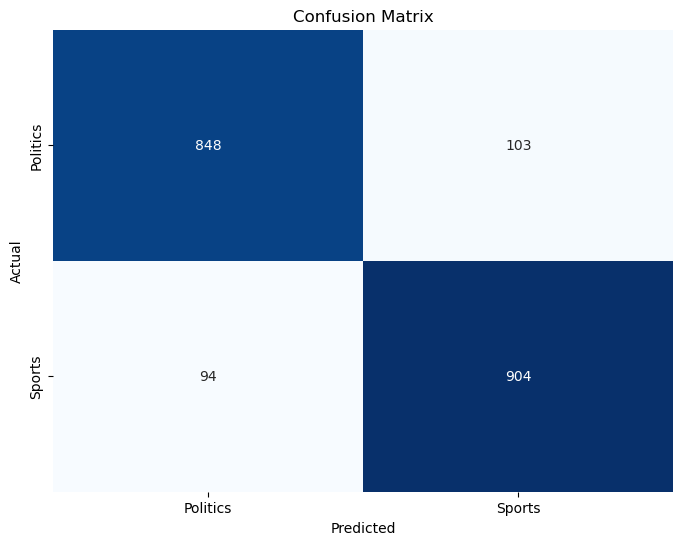

In [86]:
print("Logistic Regression:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(lr_report)

plt.figure(figsize=(8, 6))
sns.heatmap(lr_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Politics','Sports'], yticklabels=['Politics','Sports'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Naive Bayes:
Accuracy: 0.8866
              precision    recall  f1-score   support

    Politics       0.90      0.86      0.88       951
      Sports       0.87      0.91      0.89       998

    accuracy                           0.89      1949
   macro avg       0.89      0.89      0.89      1949
weighted avg       0.89      0.89      0.89      1949



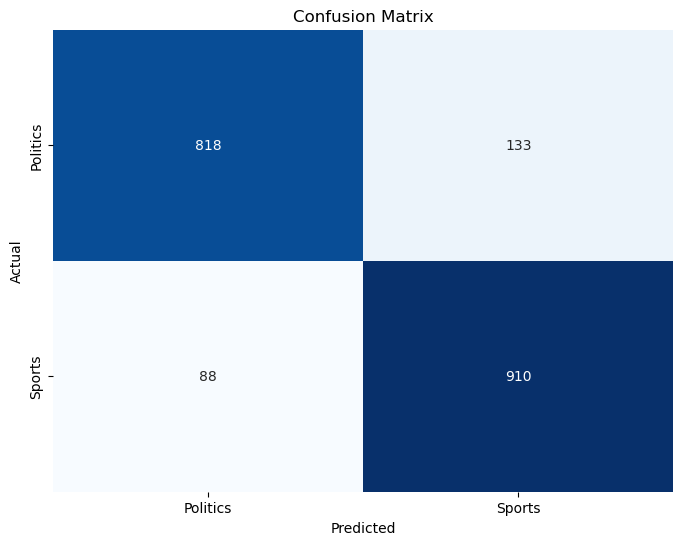

In [87]:
print("\nNaive Bayes:")
print(f"Accuracy: {nb_accuracy:.4f}")
print(nb_report)

plt.figure(figsize=(8, 6))
sns.heatmap(nb_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Politics','Sports'], yticklabels=['Politics','Sports'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

Predicting class probabilities for both models

In [88]:
nb_predictions_proba = nb_model.predict_proba(X_test)
lr_predictions_proba = lr_model.predict_proba(X_test)

Encoding labels

In [89]:
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

Calculating ROC curves

In [90]:
fpr_lr, tpr_lr, _ = roc_curve(y_test_encoded, lr_predictions_proba[:, 1])
fpr_nb, tpr_nb, _ = roc_curve(y_test_encoded, nb_predictions_proba[:, 1])

Plotting ROC curves

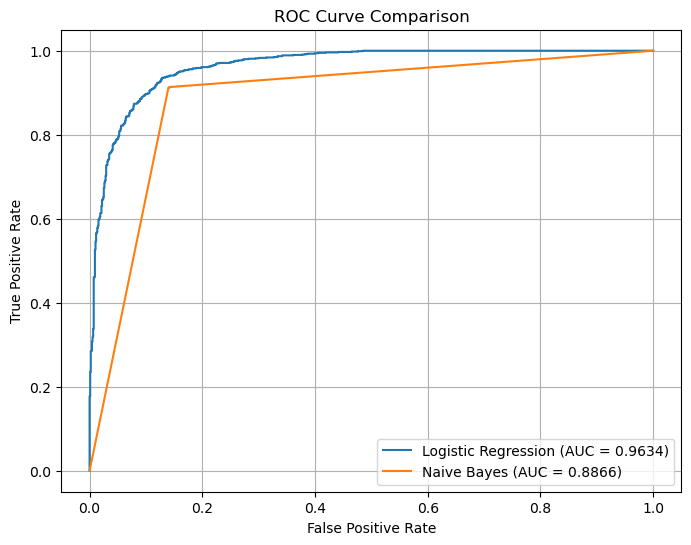

In [91]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.4f)' % auc(fpr_lr, tpr_lr))
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (AUC = %0.4f)' % auc(fpr_nb, tpr_nb))
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# Hyperparameter tuning

## Parameter grids

Define parameter grids for each model

In [92]:
lr_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'newton-cg', 'liblinear']
}
nb_model = MultinomialNB()
nb_param_grid = {
'alpha': [0.1, 1, 10],
'fit_prior': [True, False]
}

## Scalling

Scalling dataset to help with the convergence of the Logistic regression hyperparameters when tuning. Won't be used with Naive Bayes because it generates negative values that are not accepted by the Naive Bayes model.

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Grid search 

Creating grid search objects and increasing max_iter for logistic regression since it's required for convergence in this case

In [94]:
lr_grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000), param_grid=lr_param_grid, cv=5, scoring='accuracy')
nb_grid_search = GridSearchCV(nb_model, nb_param_grid, cv=5, n_jobs=-1,error_score='raise')

Fitting the grid searches to the training data

In [95]:
nb_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise', estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10], 'fit_prior': [True, False]})

In [96]:
lr_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear']},
             scoring='accuracy')

Showcasing the best parameters we got from hyperparameter tuning

In [97]:
print("Logistic Regression:")
print(f"Best parameters: {lr_grid_search.best_params_}")
print(f"Best score: {lr_grid_search.best_score_:.4f}")

Logistic Regression:
Best parameters: {'C': 0.001, 'solver': 'liblinear'}
Best score: 0.9228


In [98]:
print("\nNaive Bayes:")
print(f"Best parameters: {nb_grid_search.best_params_}")
print(f"Best score: {nb_grid_search.best_score_:.4f}")


Naive Bayes:
Best parameters: {'alpha': 0.1, 'fit_prior': True}
Best score: 0.9287


## Using the best models

In [99]:
lr_best_model = lr_grid_search.best_estimator_
nb_best_model = nb_grid_search.best_estimator_

In [100]:
lr_c_predictions = lr_best_model.predict(X_test)
nb_c_predictions = nb_best_model.predict(X_test)

## Evaluating results and efficiency

In [101]:
lr_c_accuracy = accuracy_score(y_test, lr_c_predictions)
lr_c_report = classification_report(y_test, lr_c_predictions)
lr_c_confusion_matrix = confusion_matrix(y_test, lr_c_predictions)

In [102]:
nb_c_accuracy = accuracy_score(y_test, nb_c_predictions)
nb_c_report = classification_report(y_test, nb_c_predictions,zero_division=0)
nb_c_confusion_matrix = confusion_matrix(y_test, nb_c_predictions)

Corrected Logistic Regression:
Accuracy: 0.8794
              precision    recall  f1-score   support

    Politics       0.90      0.89      0.90       951
      Sports       0.90      0.91      0.90       998

    accuracy                           0.90      1949
   macro avg       0.90      0.90      0.90      1949
weighted avg       0.90      0.90      0.90      1949



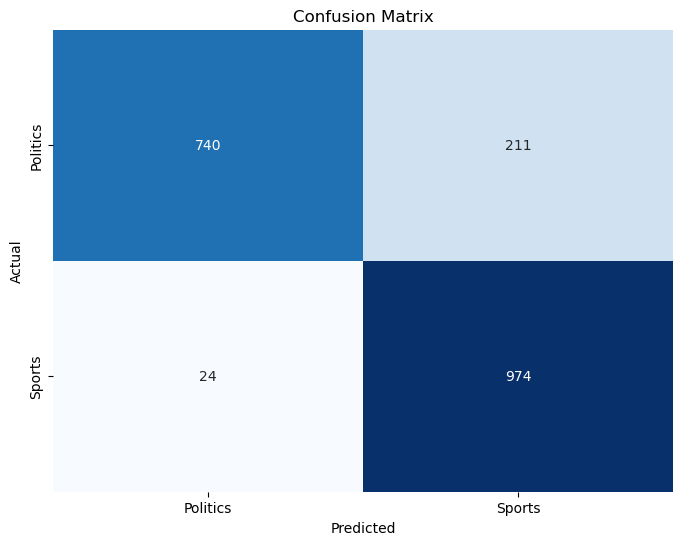

In [103]:
print("Corrected Logistic Regression:")
print(f"Accuracy: {lr_c_accuracy:.4f}")
print(lr_report)
plt.figure(figsize=(8, 6))
sns.heatmap(lr_c_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Politics','Sports'], yticklabels=['Politics','Sports'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Corrected Naive Bayes:
Accuracy: 0.9287
              precision    recall  f1-score   support

    Politics       0.90      0.86      0.88       951
      Sports       0.87      0.91      0.89       998

    accuracy                           0.89      1949
   macro avg       0.89      0.89      0.89      1949
weighted avg       0.89      0.89      0.89      1949



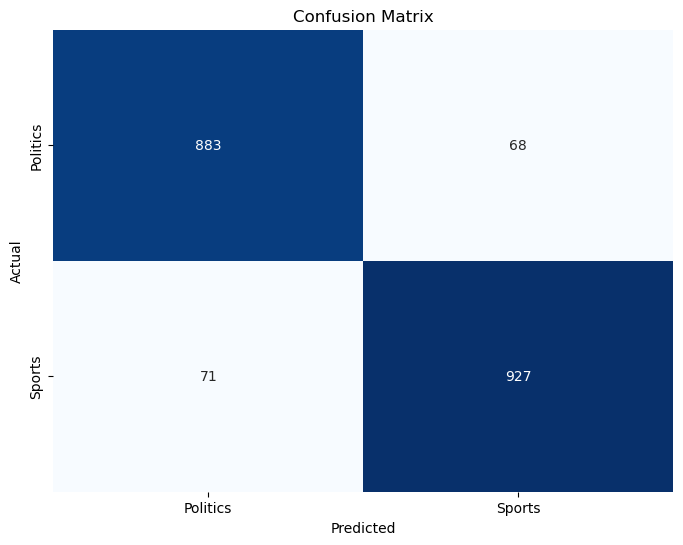

In [104]:
print("\nCorrected Naive Bayes:")
print(f"Accuracy: {nb_c_accuracy:.4f}")
print(nb_report)
plt.figure(figsize=(8, 6))
sns.heatmap(nb_c_confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Politics','Sports'], yticklabels=['Politics','Sports'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

In [105]:
nb_best_predictions_proba = nb_best_model.predict_proba(X_test)
lr_best_predictions_proba = lr_best_model.predict_proba(X_test)

In [106]:
fpr_c_lr, tpr_c_lr, _ = roc_curve(y_test_encoded, lr_best_predictions_proba[:, 1])
fpr_c_nb, tpr_c_nb, _ = roc_curve(y_test_encoded, nb_best_predictions_proba[:, 1])

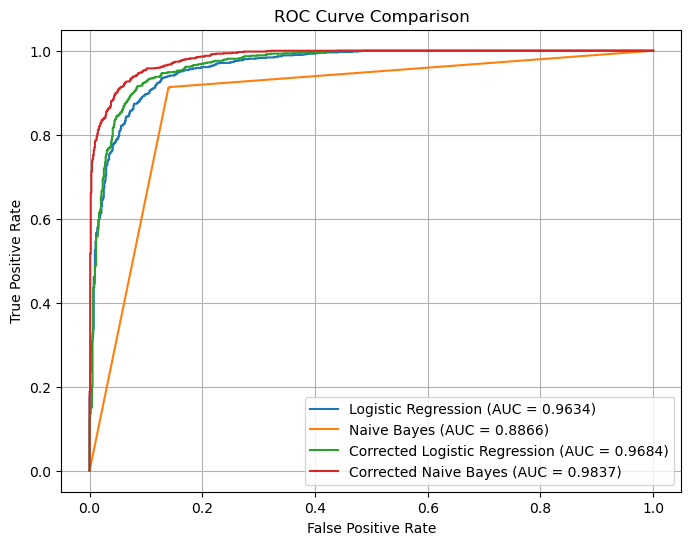

In [107]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.4f)' % auc(fpr_lr, tpr_lr))
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (AUC = %0.4f)' % auc(fpr_nb, tpr_nb))
plt.plot(fpr_c_lr, tpr_c_lr, label='Corrected Logistic Regression (AUC = %0.4f)' % auc(fpr_c_lr, tpr_c_lr))
plt.plot(fpr_c_nb, tpr_c_nb, label='Corrected Naive Bayes (AUC = %0.4f)' % auc(fpr_c_nb, tpr_c_nb))
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## interpretation


After evaluating the performance of the tested models, which include logistic regression (accuracy: 0.9067), corrected logistic regression (accuracy: 0.9174), naive Bayes(accuracy: 0.8887) , and corrected naive Bayes (accuracy: 0.9303) , it is evident that the corrected naive Bayes model outshines the others with an accuracy of 0.9303.

Notably, the assessment involved a comprehensive examination of ROC curves for all models, further confirming the superiority of the corrected naive Bayes model. 

# Using the best model on the test data

In [108]:
test.shape

(2610, 3)

In [109]:
test['Label'] = nb_best_model.predict(test_X_vect)

In [110]:
submission = test[['TweetId', 'Label']]

In [111]:
submission.to_csv("submission.csv", index=False)

# Futur improvements 


Given more time and resources, exploring a deep learning approach for tweet classification could have been a promising avenue to potentially enhance accuracy. Deep learning models, particularly those based on sophisticated architectures like BERT or LSTM, have demonstrated remarkable success in capturing intricate patterns within textual data. However, the constraint of time in this project restricted the thorough exploration of such approaches. Deep learning models often require extensive training and tuning, demanding a more comprehensive analysis and experimentation phase. While the chosen models have provided reasonable accuracy within the given constraints, a deeper dive into the realm of deep learning might unveil further insights and improvements. The decision to prioritize time efficiency underscores the pragmatic considerations in selecting a model that strikes a balance between performance and the available resources.







# Conclusion


In conclusion, the journey to find an effective model for the DeepTweets problem has been both insightful and rewarding. The comparative analysis of logistic regression and naive Bayes models, while constrained by time considerations, provided valuable insights into their respective performances. The selected corrected naive Bayes model emerged as the optimal choice, showcasing robust accuracy in distinguishing between sports and politics-related tweets. The exploration of more advanced models, such as deep learning approaches, remains a potential avenue for future endeavors, warranting a more thorough investigation when time allows.

I extend my sincere appreciation to the evaluator for their dedicated effort in following along this exploration. This journey has not only contributed to a deeper understanding of tweet classification challenges but also highlighted the significance of practical considerations in model selection. 

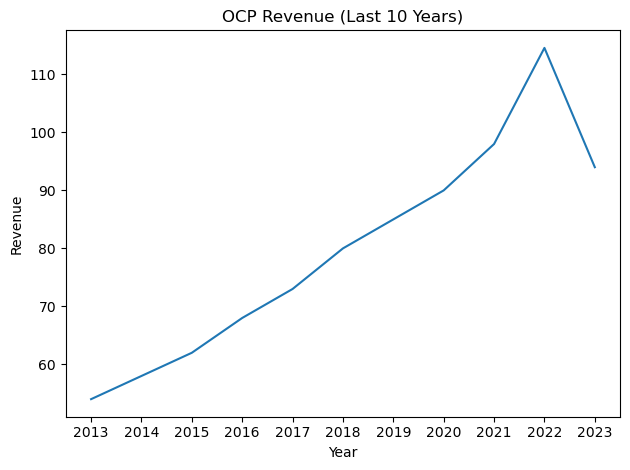

In [117]:
# Replace these values with your actual revenue data (numbers)
revenue_data = [54, 58, 62, 68, 73, 80, 85, 90, 98, 114.574, 94]  # Sample revenue data (change these)

# Years for the x-axis labels (adjust if needed)
years = ['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014','2013'][::-1]


# Plot the revenue data as a line graph
plt.plot(years, revenue_data)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Revenue')
plt.title('OCP Revenue (Last 10 Years)')

# Show the graph
plt.tight_layout()
plt.show()

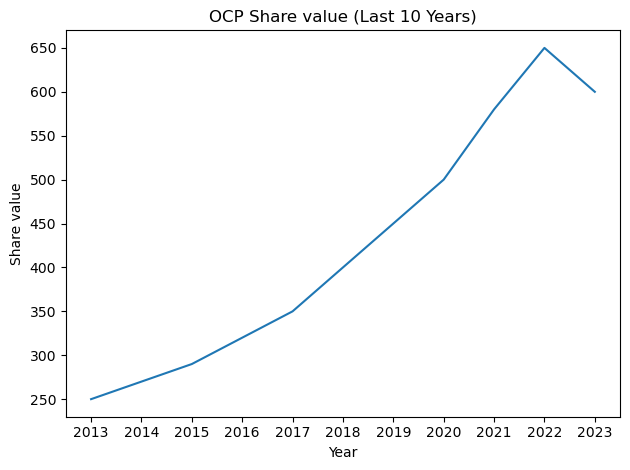

In [118]:
# Replace these values with your actual revenue data (numbers)
revenue_data = [250, 270, 290, 320, 350, 400, 450, 500, 580, 650, 600] 

# Years for the x-axis labels (adjust if needed)
years = ['2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014','2013'][::-1]


# Plot the revenue data as a line graph
plt.plot(years, revenue_data)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Share value')
plt.title('OCP Share value (Last 10 Years)')

# Show the graph
plt.tight_layout()
plt.show()